In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


In [4]:
def make_grid(nlay, nrow, ncol, lx, top0, dztopbotfact=0.1):
    # dztopbotfact can be used as a multiplier on the top and bottom layer dz
    # values so these layers are relatively thin to more precisely locate the
    # top boundary
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)

    delr = np.round(lx / ncol, 3)
    delc = 1.
    delv = top0 / (nlay - 2)
    top[:, :] = top0 + delv * dztopbotfact
    botm[0, :, :] = top0
    
    for k in range(1, nlay):
        tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    botm[nlay - 1, :, :] = 0. - delv * dztopbotfact
    
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    return (delr, delc, top, botm)

In [5]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

In [6]:
def get_model(ws, name, nlay, nrow, ncol, lx, top0, time_end,
              hydraulic_conductivity, specific_storage, porosity, 
              alpha_l, alpha_t,
              cfresh, csalt,
              nper=200, nstp=1,
              hstrt=None, cstrt=None,
              cncspd=None,
              diffusion_coefficient=0.,
              converge_continue=False,
              hhformulation=True,
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)

    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-8, 1e-8, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if hstrt is None:
        hstrt = top[0, 0]
    else:
        hstrt = {'filename': 'hstrt.bin', 'factor': 1.0, 
                 'data': hstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=0,
                                  k=hydraulic_conductivity)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=0, sy=porosity, ss=specific_storage)

    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions, denseref=1000., drhodc=0.7)
    
    # output control
    saverecord = {0: [('HEAD', 'LAST'), ('BUDGET', 'LAST')],
                  1: [('HEAD', 'LAST'), ('BUDGET', 'LAST')],
                  nper - 1: [('HEAD', 'LAST'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {'filename': 'cstrt.bin', 'factor': 1.0, 
                 'data': cstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='CENTRAL')

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=diffusion_coefficient,
                                  alh=alpha_l, ath1=alpha_t)

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    
    # constant concentration conditions
    if cncspd is not None:
        cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cncspd)

    # output control
    saverecord = {0: [('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'LAST')],
                  nper - 1: [('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'FIRST'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)
    
    obslist = [['conc1', 'concentration', (1, 0, ncol // 2)],
               ['conc2', 'concentration', (nlay - 2, 0, ncol // 2)],]
    obsdict = {'{}.obs.csv'.format(gwtname): obslist}
    obs = flopy.mf6.mfutlobs.ModflowUtlobs(gwt, continuous=obsdict)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [7]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    return head, conc, spdis, times

In [8]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

def get_boundary_patch_collection(modelgrid, ibd, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    botm = modelgrid.botm
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            if ibd[k, j] == 1:
                x0 = xv[0, j]
                x1 = xv[0, j + 1]
                z0 = zv[k, 0, j]
                z1 = zv[k + 1, 0, j]
                poly = [[x0, z0], [x1, z0], [x1, z1], [x0, z1], [x0, z0]]
                #print(poly)
                patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
                patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True)
    return pc

In [9]:
def make_figure(gwf, head, conc, spdis, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.set_aspect(1.)
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.25)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    # contours
    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.arange(.1, 1.1, .1) * csalt, 
                      linestyles = ['-'], colors=['k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.zcellcenters
        X, Y = np.meshgrid(x, y[:, 0, 0])
        u = spdis['qx']
        u = u.reshape(X.shape)
        v = spdis['qz']
        v = v.reshape(X.shape)
        sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
    
    if ax2dict is not None:
        with plt.rc_context({'axes.edgecolor':'white', 
                             'axes.facecolor':'yellow',
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'font.size': 8,
                             'axes.labelcolor': 'white',
                             }):
            if 'limits' in ax2dict:
                limits = ax2dict['limits']
            else:
                limits = [0.15, 0.22, 0.2, 0.2]
            xdata = ax2dict['xdata']
            ydata = ax2dict['ydata']
            ax2 = fig.add_axes(limits)
            ax2.plot(xdata, ydata, 'k-')
            if 'xlim' in ax2dict:
                ax2.set_xlim(*ax2dict['xlim'])
            if 'ylim' in ax2dict:
                ax2.set_ylim(*ax2dict['ylim'])
            if 'xlabel' in ax2dict:
                ax2.set_xlabel(ax2dict['xlabel'])
            if 'ylabel' in ax2dict:
                ax2.set_ylabel(ax2dict['ylabel'])
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [10]:
def make_movie(figfile, anmfile):
    from subprocess import check_output
    vcodec = 'libx264'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vb', '20M',
                           '-vcodec', vcodec,
                           '-pix_fmt', 'yuv420p',
                           anmfile])    

In [11]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc_mf6 = None

# Elder

In [12]:
rayleigh_number = 60.
rho_0 = 1000.
mu_0 = 1e-3
g = 9.81
delta_rho = 200.
drhodc = 0.7
csalt = delta_rho / drhodc * rayleigh_number / 400.
csalt = np.round(csalt, 2)
print('csalt = {}'.format(csalt))

gfact = 1.
nlay = int(52 * gfact)
nrow = 1
ncol = int(88 * gfact)
lx = 600.
lx_sz = 300.
top0 = 150.
nper = 200
nstp = 50
time_end = 73000.

# try just doing one time step
#nper = 2
#nstp = 1
#time_end = 7.3

cfresh = 0.
cstrt = 0.
porosity = 0.10
hydraulic_conductivity = 4.845e-13 * g * rho_0 / mu_0 * 24. * 3600. # m/day
hydraulic_conductivity = np.round(hydraulic_conductivity, 5)
print('hydraulic conductivity = {}'.format(hydraulic_conductivity))

specific_storage = 1.e-5 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter

diffusion_coefficient = (hydraulic_conductivity * top0 * (drhodc / rho_0) * (csalt - cfresh) 
                         / porosity / rayleigh_number)
diffusion_coefficient = np.round(diffusion_coefficient, 5)
print('diffusion coefficient = {}'.format(diffusion_coefficient))

rayleigh_calculated = (hydraulic_conductivity * top0 * (drhodc / rho_0) * (csalt - cfresh) 
                       / porosity / diffusion_coefficient)
print('rayleigh calculated = {}'.format(rayleigh_calculated))

csalt = 42.86
hydraulic conductivity = 0.41065
diffusion coefficient = 0.30801
rayleigh calculated = 59.999616733222936


inwidth 3.248031496062992


/Users/langevin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


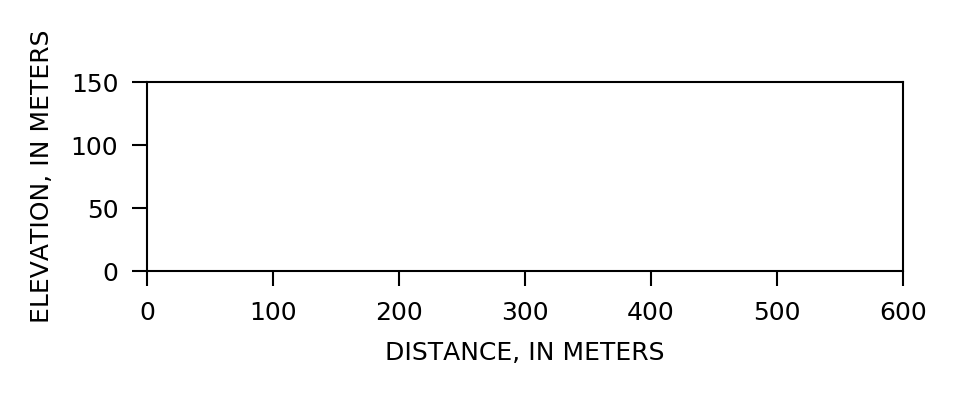

In [13]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
    ax.set_yticks([0, 50, 100, 150])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)


cmwidth = 8.25 # Groundwater full width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 1.5), dpi=300)

ax = fig.add_subplot(1, 1, 1)
ax_formatter(ax)

delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)
mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                         delr=delr, delc=delc, top=top, botm=botm)
pxs = flopy.plot.PlotCrossSection(modelgrid=mg, line={'row': 0}, ax=ax)
#pxs.plot_grid(alpha=1., lw=0.1)

ibd = np.zeros((nlay, ncol), dtype=np.int)
ibd[-1, :] = 1
pc_bot = get_boundary_patch_collection(mg, ibd, ec='none', fc='blue')
pcb = ax.add_collection(pc_bot)

x = mg.xcellcenters[0, :]
ibd = np.zeros((nlay, ncol), dtype=np.int)
idx_sz = ((x < (lx - 1.5 * lx_sz) ) | (x > (lx - lx_sz / 2.) ))
ibd[0, idx_sz] = 1
pc_top = get_boundary_patch_collection(mg, ibd, ec='none', fc='blue')
pct = ax.add_collection(pc_top)

ibd = np.zeros((nlay, ncol), dtype=np.int)
idx_sz = ((x > (lx - lx_sz) / 2.) & (x < (lx + lx_sz) / 2.))
ibd[0, idx_sz] = 1
pc_mid = get_boundary_patch_collection(mg, ibd, ec='none', fc='red')
pcm = ax.add_collection(pc_mid)

ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
plt.savefig('../Figures/pxx_elder_bcs.pdf')

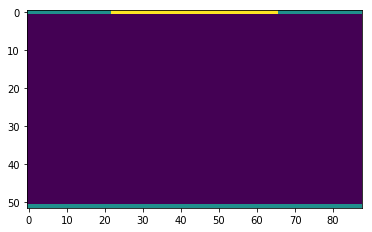

In [14]:
x = mg.xcellcenters[0, :]
cibd = np.zeros((nlay, nrow, ncol), dtype=np.int)
idx_sz = ((x < (lx - 1.5 * lx_sz) ) | (x > (lx - lx_sz / 2.) ))
cibd[0, 0, idx_sz] = 1
idx_sz = ((x > (lx - lx_sz) / 2.) & (x < (lx + lx_sz) / 2.))
cibd[0, 0, idx_sz] = 2
cibd[nlay - 1, 0, :] = 1
plt.imshow(cibd[:, 0, :])

# use low K for constant concentration cells
# should low K be for whole top layer?  Or just constant concentration cell?
if True:
    hydraulic_conductivity = np.ones((nlay, nrow, ncol)) * hydraulic_conductivity
    idx_sz = ((x > (lx - lx_sz) / 2.) & (x < (lx + lx_sz) / 2.))
    hydraulic_conductivity[0, :, idx_sz] = 1.e-8
    #hydraulic_conductivity[0, :, :] = 1.e-8
    hydraulic_conductivity[-1, :, :] = 1.e-8

In [15]:
cnclist = []
for k, i, j in zip(*np.where(cibd == 1)):
    cnclist.append([(k, i, j), 0])
for k, i, j in zip(*np.where(cibd == 2)):
    cnclist.append([(k, i, j), csalt])
cncspd = {0: cnclist}

# MODFLOW 6 Run

In [16]:
ws0 = 'temp/pxx_gwt_elderRa60'
name = 'elder'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx,
                 top0, time_end, 
                 hydraulic_conductivity, specific_storage, porosity, 
                 alpha_l, alpha_t,
                 cfresh, csalt, 
                 nper=nper, nstp=nstp,
                 cstrt=cstrt,
                 cncspd=cncspd,
                 diffusion_coefficient=diffusion_coefficient,
                 verbosity_level=1,
                 hhformulation=True)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package elder.gwfgwt...
  writing model gwf_elder...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package oc...
  writing model gwt_elder...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package cnc...
INFORMATION: maxbound in ('gwt6', 'cnc', 'dimensions') changed to 176 based on size of stress_period_data
    writing package oc...
    writing package obs_0...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HY

 Solving:  Stress period:     3    Time step:    23
 Solving:  Stress period:     3    Time step:    24
 Solving:  Stress period:     3    Time step:    25
 Solving:  Stress period:     3    Time step:    26
 Solving:  Stress period:     3    Time step:    27
 Solving:  Stress period:     3    Time step:    28
 Solving:  Stress period:     3    Time step:    29
 Solving:  Stress period:     3    Time step:    30
 Solving:  Stress period:     3    Time step:    31
 Solving:  Stress period:     3    Time step:    32
 Solving:  Stress period:     3    Time step:    33
 Solving:  Stress period:     3    Time step:    34
 Solving:  Stress period:     3    Time step:    35
 Solving:  Stress period:     3    Time step:    36
 Solving:  Stress period:     3    Time step:    37
 Solving:  Stress period:     3    Time step:    38
 Solving:  Stress period:     3    Time step:    39
 Solving:  Stress period:     3    Time step:    40
 Solving:  Stress period:     3    Time step:    41
 Solving:  S

 Solving:  Stress period:     6    Time step:    33
 Solving:  Stress period:     6    Time step:    34
 Solving:  Stress period:     6    Time step:    35
 Solving:  Stress period:     6    Time step:    36
 Solving:  Stress period:     6    Time step:    37
 Solving:  Stress period:     6    Time step:    38
 Solving:  Stress period:     6    Time step:    39
 Solving:  Stress period:     6    Time step:    40
 Solving:  Stress period:     6    Time step:    41
 Solving:  Stress period:     6    Time step:    42
 Solving:  Stress period:     6    Time step:    43
 Solving:  Stress period:     6    Time step:    44
 Solving:  Stress period:     6    Time step:    45
 Solving:  Stress period:     6    Time step:    46
 Solving:  Stress period:     6    Time step:    47
 Solving:  Stress period:     6    Time step:    48
 Solving:  Stress period:     6    Time step:    49
 Solving:  Stress period:     6    Time step:    50
 Solving:  Stress period:     7    Time step:     1
 Solving:  S

 Solving:  Stress period:     9    Time step:    45
 Solving:  Stress period:     9    Time step:    46
 Solving:  Stress period:     9    Time step:    47
 Solving:  Stress period:     9    Time step:    48
 Solving:  Stress period:     9    Time step:    49
 Solving:  Stress period:     9    Time step:    50
 Solving:  Stress period:    10    Time step:     1
 Solving:  Stress period:    10    Time step:     2
 Solving:  Stress period:    10    Time step:     3
 Solving:  Stress period:    10    Time step:     4
 Solving:  Stress period:    10    Time step:     5
 Solving:  Stress period:    10    Time step:     6
 Solving:  Stress period:    10    Time step:     7
 Solving:  Stress period:    10    Time step:     8
 Solving:  Stress period:    10    Time step:     9
 Solving:  Stress period:    10    Time step:    10
 Solving:  Stress period:    10    Time step:    11
 Solving:  Stress period:    10    Time step:    12
 Solving:  Stress period:    10    Time step:    13
 Solving:  S

 Solving:  Stress period:    13    Time step:     5
 Solving:  Stress period:    13    Time step:     6
 Solving:  Stress period:    13    Time step:     7
 Solving:  Stress period:    13    Time step:     8
 Solving:  Stress period:    13    Time step:     9
 Solving:  Stress period:    13    Time step:    10
 Solving:  Stress period:    13    Time step:    11
 Solving:  Stress period:    13    Time step:    12
 Solving:  Stress period:    13    Time step:    13
 Solving:  Stress period:    13    Time step:    14
 Solving:  Stress period:    13    Time step:    15
 Solving:  Stress period:    13    Time step:    16
 Solving:  Stress period:    13    Time step:    17
 Solving:  Stress period:    13    Time step:    18
 Solving:  Stress period:    13    Time step:    19
 Solving:  Stress period:    13    Time step:    20
 Solving:  Stress period:    13    Time step:    21
 Solving:  Stress period:    13    Time step:    22
 Solving:  Stress period:    13    Time step:    23
 Solving:  S

 Solving:  Stress period:    16    Time step:    15
 Solving:  Stress period:    16    Time step:    16
 Solving:  Stress period:    16    Time step:    17
 Solving:  Stress period:    16    Time step:    18
 Solving:  Stress period:    16    Time step:    19
 Solving:  Stress period:    16    Time step:    20
 Solving:  Stress period:    16    Time step:    21
 Solving:  Stress period:    16    Time step:    22
 Solving:  Stress period:    16    Time step:    23
 Solving:  Stress period:    16    Time step:    24
 Solving:  Stress period:    16    Time step:    25
 Solving:  Stress period:    16    Time step:    26
 Solving:  Stress period:    16    Time step:    27
 Solving:  Stress period:    16    Time step:    28
 Solving:  Stress period:    16    Time step:    29
 Solving:  Stress period:    16    Time step:    30
 Solving:  Stress period:    16    Time step:    31
 Solving:  Stress period:    16    Time step:    32
 Solving:  Stress period:    16    Time step:    33
 Solving:  S

 Solving:  Stress period:    19    Time step:    27
 Solving:  Stress period:    19    Time step:    28
 Solving:  Stress period:    19    Time step:    29
 Solving:  Stress period:    19    Time step:    30
 Solving:  Stress period:    19    Time step:    31
 Solving:  Stress period:    19    Time step:    32
 Solving:  Stress period:    19    Time step:    33
 Solving:  Stress period:    19    Time step:    34
 Solving:  Stress period:    19    Time step:    35
 Solving:  Stress period:    19    Time step:    36
 Solving:  Stress period:    19    Time step:    37
 Solving:  Stress period:    19    Time step:    38
 Solving:  Stress period:    19    Time step:    39
 Solving:  Stress period:    19    Time step:    40
 Solving:  Stress period:    19    Time step:    41
 Solving:  Stress period:    19    Time step:    42
 Solving:  Stress period:    19    Time step:    43
 Solving:  Stress period:    19    Time step:    44
 Solving:  Stress period:    19    Time step:    45
 Solving:  S

 Solving:  Stress period:    22    Time step:    36
 Solving:  Stress period:    22    Time step:    37
 Solving:  Stress period:    22    Time step:    38
 Solving:  Stress period:    22    Time step:    39
 Solving:  Stress period:    22    Time step:    40
 Solving:  Stress period:    22    Time step:    41
 Solving:  Stress period:    22    Time step:    42
 Solving:  Stress period:    22    Time step:    43
 Solving:  Stress period:    22    Time step:    44
 Solving:  Stress period:    22    Time step:    45
 Solving:  Stress period:    22    Time step:    46
 Solving:  Stress period:    22    Time step:    47
 Solving:  Stress period:    22    Time step:    48
 Solving:  Stress period:    22    Time step:    49
 Solving:  Stress period:    22    Time step:    50
 Solving:  Stress period:    23    Time step:     1
 Solving:  Stress period:    23    Time step:     2
 Solving:  Stress period:    23    Time step:     3
 Solving:  Stress period:    23    Time step:     4
 Solving:  S

 Solving:  Stress period:    25    Time step:    47
 Solving:  Stress period:    25    Time step:    48
 Solving:  Stress period:    25    Time step:    49
 Solving:  Stress period:    25    Time step:    50
 Solving:  Stress period:    26    Time step:     1
 Solving:  Stress period:    26    Time step:     2
 Solving:  Stress period:    26    Time step:     3
 Solving:  Stress period:    26    Time step:     4
 Solving:  Stress period:    26    Time step:     5
 Solving:  Stress period:    26    Time step:     6
 Solving:  Stress period:    26    Time step:     7
 Solving:  Stress period:    26    Time step:     8
 Solving:  Stress period:    26    Time step:     9
 Solving:  Stress period:    26    Time step:    10
 Solving:  Stress period:    26    Time step:    11
 Solving:  Stress period:    26    Time step:    12
 Solving:  Stress period:    26    Time step:    13
 Solving:  Stress period:    26    Time step:    14
 Solving:  Stress period:    26    Time step:    15
 Solving:  S

 Solving:  Stress period:    29    Time step:     9
 Solving:  Stress period:    29    Time step:    10
 Solving:  Stress period:    29    Time step:    11
 Solving:  Stress period:    29    Time step:    12
 Solving:  Stress period:    29    Time step:    13
 Solving:  Stress period:    29    Time step:    14
 Solving:  Stress period:    29    Time step:    15
 Solving:  Stress period:    29    Time step:    16
 Solving:  Stress period:    29    Time step:    17
 Solving:  Stress period:    29    Time step:    18
 Solving:  Stress period:    29    Time step:    19
 Solving:  Stress period:    29    Time step:    20
 Solving:  Stress period:    29    Time step:    21
 Solving:  Stress period:    29    Time step:    22
 Solving:  Stress period:    29    Time step:    23
 Solving:  Stress period:    29    Time step:    24
 Solving:  Stress period:    29    Time step:    25
 Solving:  Stress period:    29    Time step:    26
 Solving:  Stress period:    29    Time step:    27
 Solving:  S

 Solving:  Stress period:    32    Time step:    23
 Solving:  Stress period:    32    Time step:    24
 Solving:  Stress period:    32    Time step:    25
 Solving:  Stress period:    32    Time step:    26
 Solving:  Stress period:    32    Time step:    27
 Solving:  Stress period:    32    Time step:    28
 Solving:  Stress period:    32    Time step:    29
 Solving:  Stress period:    32    Time step:    30
 Solving:  Stress period:    32    Time step:    31
 Solving:  Stress period:    32    Time step:    32
 Solving:  Stress period:    32    Time step:    33
 Solving:  Stress period:    32    Time step:    34
 Solving:  Stress period:    32    Time step:    35
 Solving:  Stress period:    32    Time step:    36
 Solving:  Stress period:    32    Time step:    37
 Solving:  Stress period:    32    Time step:    38
 Solving:  Stress period:    32    Time step:    39
 Solving:  Stress period:    32    Time step:    40
 Solving:  Stress period:    32    Time step:    41
 Solving:  S

 Solving:  Stress period:    35    Time step:    35
 Solving:  Stress period:    35    Time step:    36
 Solving:  Stress period:    35    Time step:    37
 Solving:  Stress period:    35    Time step:    38
 Solving:  Stress period:    35    Time step:    39
 Solving:  Stress period:    35    Time step:    40
 Solving:  Stress period:    35    Time step:    41
 Solving:  Stress period:    35    Time step:    42
 Solving:  Stress period:    35    Time step:    43
 Solving:  Stress period:    35    Time step:    44
 Solving:  Stress period:    35    Time step:    45
 Solving:  Stress period:    35    Time step:    46
 Solving:  Stress period:    35    Time step:    47
 Solving:  Stress period:    35    Time step:    48
 Solving:  Stress period:    35    Time step:    49
 Solving:  Stress period:    35    Time step:    50
 Solving:  Stress period:    36    Time step:     1
 Solving:  Stress period:    36    Time step:     2
 Solving:  Stress period:    36    Time step:     3
 Solving:  S

 Solving:  Stress period:    39    Time step:     3
 Solving:  Stress period:    39    Time step:     4
 Solving:  Stress period:    39    Time step:     5
 Solving:  Stress period:    39    Time step:     6
 Solving:  Stress period:    39    Time step:     7
 Solving:  Stress period:    39    Time step:     8
 Solving:  Stress period:    39    Time step:     9
 Solving:  Stress period:    39    Time step:    10
 Solving:  Stress period:    39    Time step:    11
 Solving:  Stress period:    39    Time step:    12
 Solving:  Stress period:    39    Time step:    13
 Solving:  Stress period:    39    Time step:    14
 Solving:  Stress period:    39    Time step:    15
 Solving:  Stress period:    39    Time step:    16
 Solving:  Stress period:    39    Time step:    17
 Solving:  Stress period:    39    Time step:    18
 Solving:  Stress period:    39    Time step:    19
 Solving:  Stress period:    39    Time step:    20
 Solving:  Stress period:    39    Time step:    21
 Solving:  S

 Solving:  Stress period:    42    Time step:    19
 Solving:  Stress period:    42    Time step:    20
 Solving:  Stress period:    42    Time step:    21
 Solving:  Stress period:    42    Time step:    22
 Solving:  Stress period:    42    Time step:    23
 Solving:  Stress period:    42    Time step:    24
 Solving:  Stress period:    42    Time step:    25
 Solving:  Stress period:    42    Time step:    26
 Solving:  Stress period:    42    Time step:    27
 Solving:  Stress period:    42    Time step:    28
 Solving:  Stress period:    42    Time step:    29
 Solving:  Stress period:    42    Time step:    30
 Solving:  Stress period:    42    Time step:    31
 Solving:  Stress period:    42    Time step:    32
 Solving:  Stress period:    42    Time step:    33
 Solving:  Stress period:    42    Time step:    34
 Solving:  Stress period:    42    Time step:    35
 Solving:  Stress period:    42    Time step:    36
 Solving:  Stress period:    42    Time step:    37
 Solving:  S

 Solving:  Stress period:    45    Time step:    31
 Solving:  Stress period:    45    Time step:    32
 Solving:  Stress period:    45    Time step:    33
 Solving:  Stress period:    45    Time step:    34
 Solving:  Stress period:    45    Time step:    35
 Solving:  Stress period:    45    Time step:    36
 Solving:  Stress period:    45    Time step:    37
 Solving:  Stress period:    45    Time step:    38
 Solving:  Stress period:    45    Time step:    39
 Solving:  Stress period:    45    Time step:    40
 Solving:  Stress period:    45    Time step:    41
 Solving:  Stress period:    45    Time step:    42
 Solving:  Stress period:    45    Time step:    43
 Solving:  Stress period:    45    Time step:    44
 Solving:  Stress period:    45    Time step:    45
 Solving:  Stress period:    45    Time step:    46
 Solving:  Stress period:    45    Time step:    47
 Solving:  Stress period:    45    Time step:    48
 Solving:  Stress period:    45    Time step:    49
 Solving:  S

 Solving:  Stress period:    48    Time step:    43
 Solving:  Stress period:    48    Time step:    44
 Solving:  Stress period:    48    Time step:    45
 Solving:  Stress period:    48    Time step:    46
 Solving:  Stress period:    48    Time step:    47
 Solving:  Stress period:    48    Time step:    48
 Solving:  Stress period:    48    Time step:    49
 Solving:  Stress period:    48    Time step:    50
 Solving:  Stress period:    49    Time step:     1
 Solving:  Stress period:    49    Time step:     2
 Solving:  Stress period:    49    Time step:     3
 Solving:  Stress period:    49    Time step:     4
 Solving:  Stress period:    49    Time step:     5
 Solving:  Stress period:    49    Time step:     6
 Solving:  Stress period:    49    Time step:     7
 Solving:  Stress period:    49    Time step:     8
 Solving:  Stress period:    49    Time step:     9
 Solving:  Stress period:    49    Time step:    10
 Solving:  Stress period:    49    Time step:    11
 Solving:  S

 Solving:  Stress period:    52    Time step:    10
 Solving:  Stress period:    52    Time step:    11
 Solving:  Stress period:    52    Time step:    12
 Solving:  Stress period:    52    Time step:    13
 Solving:  Stress period:    52    Time step:    14
 Solving:  Stress period:    52    Time step:    15
 Solving:  Stress period:    52    Time step:    16
 Solving:  Stress period:    52    Time step:    17
 Solving:  Stress period:    52    Time step:    18
 Solving:  Stress period:    52    Time step:    19
 Solving:  Stress period:    52    Time step:    20
 Solving:  Stress period:    52    Time step:    21
 Solving:  Stress period:    52    Time step:    22
 Solving:  Stress period:    52    Time step:    23
 Solving:  Stress period:    52    Time step:    24
 Solving:  Stress period:    52    Time step:    25
 Solving:  Stress period:    52    Time step:    26
 Solving:  Stress period:    52    Time step:    27
 Solving:  Stress period:    52    Time step:    28
 Solving:  S

 Solving:  Stress period:    55    Time step:    22
 Solving:  Stress period:    55    Time step:    23
 Solving:  Stress period:    55    Time step:    24
 Solving:  Stress period:    55    Time step:    25
 Solving:  Stress period:    55    Time step:    26
 Solving:  Stress period:    55    Time step:    27
 Solving:  Stress period:    55    Time step:    28
 Solving:  Stress period:    55    Time step:    29
 Solving:  Stress period:    55    Time step:    30
 Solving:  Stress period:    55    Time step:    31
 Solving:  Stress period:    55    Time step:    32
 Solving:  Stress period:    55    Time step:    33
 Solving:  Stress period:    55    Time step:    34
 Solving:  Stress period:    55    Time step:    35
 Solving:  Stress period:    55    Time step:    36
 Solving:  Stress period:    55    Time step:    37
 Solving:  Stress period:    55    Time step:    38
 Solving:  Stress period:    55    Time step:    39
 Solving:  Stress period:    55    Time step:    40
 Solving:  S

 Solving:  Stress period:    58    Time step:    33
 Solving:  Stress period:    58    Time step:    34
 Solving:  Stress period:    58    Time step:    35
 Solving:  Stress period:    58    Time step:    36
 Solving:  Stress period:    58    Time step:    37
 Solving:  Stress period:    58    Time step:    38
 Solving:  Stress period:    58    Time step:    39
 Solving:  Stress period:    58    Time step:    40
 Solving:  Stress period:    58    Time step:    41
 Solving:  Stress period:    58    Time step:    42
 Solving:  Stress period:    58    Time step:    43
 Solving:  Stress period:    58    Time step:    44
 Solving:  Stress period:    58    Time step:    45
 Solving:  Stress period:    58    Time step:    46
 Solving:  Stress period:    58    Time step:    47
 Solving:  Stress period:    58    Time step:    48
 Solving:  Stress period:    58    Time step:    49
 Solving:  Stress period:    58    Time step:    50
 Solving:  Stress period:    59    Time step:     1
 Solving:  S

 Solving:  Stress period:    61    Time step:    41
 Solving:  Stress period:    61    Time step:    42
 Solving:  Stress period:    61    Time step:    43
 Solving:  Stress period:    61    Time step:    44
 Solving:  Stress period:    61    Time step:    45
 Solving:  Stress period:    61    Time step:    46
 Solving:  Stress period:    61    Time step:    47
 Solving:  Stress period:    61    Time step:    48
 Solving:  Stress period:    61    Time step:    49
 Solving:  Stress period:    61    Time step:    50
 Solving:  Stress period:    62    Time step:     1
 Solving:  Stress period:    62    Time step:     2
 Solving:  Stress period:    62    Time step:     3
 Solving:  Stress period:    62    Time step:     4
 Solving:  Stress period:    62    Time step:     5
 Solving:  Stress period:    62    Time step:     6
 Solving:  Stress period:    62    Time step:     7
 Solving:  Stress period:    62    Time step:     8
 Solving:  Stress period:    62    Time step:     9
 Solving:  S

 Solving:  Stress period:    65    Time step:     4
 Solving:  Stress period:    65    Time step:     5
 Solving:  Stress period:    65    Time step:     6
 Solving:  Stress period:    65    Time step:     7
 Solving:  Stress period:    65    Time step:     8
 Solving:  Stress period:    65    Time step:     9
 Solving:  Stress period:    65    Time step:    10
 Solving:  Stress period:    65    Time step:    11
 Solving:  Stress period:    65    Time step:    12
 Solving:  Stress period:    65    Time step:    13
 Solving:  Stress period:    65    Time step:    14
 Solving:  Stress period:    65    Time step:    15
 Solving:  Stress period:    65    Time step:    16
 Solving:  Stress period:    65    Time step:    17
 Solving:  Stress period:    65    Time step:    18
 Solving:  Stress period:    65    Time step:    19
 Solving:  Stress period:    65    Time step:    20
 Solving:  Stress period:    65    Time step:    21
 Solving:  Stress period:    65    Time step:    22
 Solving:  S

 Solving:  Stress period:    68    Time step:    17
 Solving:  Stress period:    68    Time step:    18
 Solving:  Stress period:    68    Time step:    19
 Solving:  Stress period:    68    Time step:    20
 Solving:  Stress period:    68    Time step:    21
 Solving:  Stress period:    68    Time step:    22
 Solving:  Stress period:    68    Time step:    23
 Solving:  Stress period:    68    Time step:    24
 Solving:  Stress period:    68    Time step:    25
 Solving:  Stress period:    68    Time step:    26
 Solving:  Stress period:    68    Time step:    27
 Solving:  Stress period:    68    Time step:    28
 Solving:  Stress period:    68    Time step:    29
 Solving:  Stress period:    68    Time step:    30
 Solving:  Stress period:    68    Time step:    31
 Solving:  Stress period:    68    Time step:    32
 Solving:  Stress period:    68    Time step:    33
 Solving:  Stress period:    68    Time step:    34
 Solving:  Stress period:    68    Time step:    35
 Solving:  S

 Solving:  Stress period:    71    Time step:    30
 Solving:  Stress period:    71    Time step:    31
 Solving:  Stress period:    71    Time step:    32
 Solving:  Stress period:    71    Time step:    33
 Solving:  Stress period:    71    Time step:    34
 Solving:  Stress period:    71    Time step:    35
 Solving:  Stress period:    71    Time step:    36
 Solving:  Stress period:    71    Time step:    37
 Solving:  Stress period:    71    Time step:    38
 Solving:  Stress period:    71    Time step:    39
 Solving:  Stress period:    71    Time step:    40
 Solving:  Stress period:    71    Time step:    41
 Solving:  Stress period:    71    Time step:    42
 Solving:  Stress period:    71    Time step:    43
 Solving:  Stress period:    71    Time step:    44
 Solving:  Stress period:    71    Time step:    45
 Solving:  Stress period:    71    Time step:    46
 Solving:  Stress period:    71    Time step:    47
 Solving:  Stress period:    71    Time step:    48
 Solving:  S

 Solving:  Stress period:    74    Time step:    45
 Solving:  Stress period:    74    Time step:    46
 Solving:  Stress period:    74    Time step:    47
 Solving:  Stress period:    74    Time step:    48
 Solving:  Stress period:    74    Time step:    49
 Solving:  Stress period:    74    Time step:    50
 Solving:  Stress period:    75    Time step:     1
 Solving:  Stress period:    75    Time step:     2
 Solving:  Stress period:    75    Time step:     3
 Solving:  Stress period:    75    Time step:     4
 Solving:  Stress period:    75    Time step:     5
 Solving:  Stress period:    75    Time step:     6
 Solving:  Stress period:    75    Time step:     7
 Solving:  Stress period:    75    Time step:     8
 Solving:  Stress period:    75    Time step:     9
 Solving:  Stress period:    75    Time step:    10
 Solving:  Stress period:    75    Time step:    11
 Solving:  Stress period:    75    Time step:    12
 Solving:  Stress period:    75    Time step:    13
 Solving:  S

 Solving:  Stress period:    78    Time step:     7
 Solving:  Stress period:    78    Time step:     8
 Solving:  Stress period:    78    Time step:     9
 Solving:  Stress period:    78    Time step:    10
 Solving:  Stress period:    78    Time step:    11
 Solving:  Stress period:    78    Time step:    12
 Solving:  Stress period:    78    Time step:    13
 Solving:  Stress period:    78    Time step:    14
 Solving:  Stress period:    78    Time step:    15
 Solving:  Stress period:    78    Time step:    16
 Solving:  Stress period:    78    Time step:    17
 Solving:  Stress period:    78    Time step:    18
 Solving:  Stress period:    78    Time step:    19
 Solving:  Stress period:    78    Time step:    20
 Solving:  Stress period:    78    Time step:    21
 Solving:  Stress period:    78    Time step:    22
 Solving:  Stress period:    78    Time step:    23
 Solving:  Stress period:    78    Time step:    24
 Solving:  Stress period:    78    Time step:    25
 Solving:  S

 Solving:  Stress period:    81    Time step:    27
 Solving:  Stress period:    81    Time step:    28
 Solving:  Stress period:    81    Time step:    29
 Solving:  Stress period:    81    Time step:    30
 Solving:  Stress period:    81    Time step:    31
 Solving:  Stress period:    81    Time step:    32
 Solving:  Stress period:    81    Time step:    33
 Solving:  Stress period:    81    Time step:    34
 Solving:  Stress period:    81    Time step:    35
 Solving:  Stress period:    81    Time step:    36
 Solving:  Stress period:    81    Time step:    37
 Solving:  Stress period:    81    Time step:    38
 Solving:  Stress period:    81    Time step:    39
 Solving:  Stress period:    81    Time step:    40
 Solving:  Stress period:    81    Time step:    41
 Solving:  Stress period:    81    Time step:    42
 Solving:  Stress period:    81    Time step:    43
 Solving:  Stress period:    81    Time step:    44
 Solving:  Stress period:    81    Time step:    45
 Solving:  S

 Solving:  Stress period:    84    Time step:    39
 Solving:  Stress period:    84    Time step:    40
 Solving:  Stress period:    84    Time step:    41
 Solving:  Stress period:    84    Time step:    42
 Solving:  Stress period:    84    Time step:    43
 Solving:  Stress period:    84    Time step:    44
 Solving:  Stress period:    84    Time step:    45
 Solving:  Stress period:    84    Time step:    46
 Solving:  Stress period:    84    Time step:    47
 Solving:  Stress period:    84    Time step:    48
 Solving:  Stress period:    84    Time step:    49
 Solving:  Stress period:    84    Time step:    50
 Solving:  Stress period:    85    Time step:     1
 Solving:  Stress period:    85    Time step:     2
 Solving:  Stress period:    85    Time step:     3
 Solving:  Stress period:    85    Time step:     4
 Solving:  Stress period:    85    Time step:     5
 Solving:  Stress period:    85    Time step:     6
 Solving:  Stress period:    85    Time step:     7
 Solving:  S

 Solving:  Stress period:    88    Time step:     1
 Solving:  Stress period:    88    Time step:     2
 Solving:  Stress period:    88    Time step:     3
 Solving:  Stress period:    88    Time step:     4
 Solving:  Stress period:    88    Time step:     5
 Solving:  Stress period:    88    Time step:     6
 Solving:  Stress period:    88    Time step:     7
 Solving:  Stress period:    88    Time step:     8
 Solving:  Stress period:    88    Time step:     9
 Solving:  Stress period:    88    Time step:    10
 Solving:  Stress period:    88    Time step:    11
 Solving:  Stress period:    88    Time step:    12
 Solving:  Stress period:    88    Time step:    13
 Solving:  Stress period:    88    Time step:    14
 Solving:  Stress period:    88    Time step:    15
 Solving:  Stress period:    88    Time step:    16
 Solving:  Stress period:    88    Time step:    17
 Solving:  Stress period:    88    Time step:    18
 Solving:  Stress period:    88    Time step:    19
 Solving:  S

 Solving:  Stress period:    91    Time step:    20
 Solving:  Stress period:    91    Time step:    21
 Solving:  Stress period:    91    Time step:    22
 Solving:  Stress period:    91    Time step:    23
 Solving:  Stress period:    91    Time step:    24
 Solving:  Stress period:    91    Time step:    25
 Solving:  Stress period:    91    Time step:    26
 Solving:  Stress period:    91    Time step:    27
 Solving:  Stress period:    91    Time step:    28
 Solving:  Stress period:    91    Time step:    29
 Solving:  Stress period:    91    Time step:    30
 Solving:  Stress period:    91    Time step:    31
 Solving:  Stress period:    91    Time step:    32
 Solving:  Stress period:    91    Time step:    33
 Solving:  Stress period:    91    Time step:    34
 Solving:  Stress period:    91    Time step:    35
 Solving:  Stress period:    91    Time step:    36
 Solving:  Stress period:    91    Time step:    37
 Solving:  Stress period:    91    Time step:    38
 Solving:  S

 Solving:  Stress period:    94    Time step:    32
 Solving:  Stress period:    94    Time step:    33
 Solving:  Stress period:    94    Time step:    34
 Solving:  Stress period:    94    Time step:    35
 Solving:  Stress period:    94    Time step:    36
 Solving:  Stress period:    94    Time step:    37
 Solving:  Stress period:    94    Time step:    38
 Solving:  Stress period:    94    Time step:    39
 Solving:  Stress period:    94    Time step:    40
 Solving:  Stress period:    94    Time step:    41
 Solving:  Stress period:    94    Time step:    42
 Solving:  Stress period:    94    Time step:    43
 Solving:  Stress period:    94    Time step:    44
 Solving:  Stress period:    94    Time step:    45
 Solving:  Stress period:    94    Time step:    46
 Solving:  Stress period:    94    Time step:    47
 Solving:  Stress period:    94    Time step:    48
 Solving:  Stress period:    94    Time step:    49
 Solving:  Stress period:    94    Time step:    50
 Solving:  S

 Solving:  Stress period:    97    Time step:    44
 Solving:  Stress period:    97    Time step:    45
 Solving:  Stress period:    97    Time step:    46
 Solving:  Stress period:    97    Time step:    47
 Solving:  Stress period:    97    Time step:    48
 Solving:  Stress period:    97    Time step:    49
 Solving:  Stress period:    97    Time step:    50
 Solving:  Stress period:    98    Time step:     1
 Solving:  Stress period:    98    Time step:     2
 Solving:  Stress period:    98    Time step:     3
 Solving:  Stress period:    98    Time step:     4
 Solving:  Stress period:    98    Time step:     5
 Solving:  Stress period:    98    Time step:     6
 Solving:  Stress period:    98    Time step:     7
 Solving:  Stress period:    98    Time step:     8
 Solving:  Stress period:    98    Time step:     9
 Solving:  Stress period:    98    Time step:    10
 Solving:  Stress period:    98    Time step:    11
 Solving:  Stress period:    98    Time step:    12
 Solving:  S

 Solving:  Stress period:   101    Time step:     8
 Solving:  Stress period:   101    Time step:     9
 Solving:  Stress period:   101    Time step:    10
 Solving:  Stress period:   101    Time step:    11
 Solving:  Stress period:   101    Time step:    12
 Solving:  Stress period:   101    Time step:    13
 Solving:  Stress period:   101    Time step:    14
 Solving:  Stress period:   101    Time step:    15
 Solving:  Stress period:   101    Time step:    16
 Solving:  Stress period:   101    Time step:    17
 Solving:  Stress period:   101    Time step:    18
 Solving:  Stress period:   101    Time step:    19
 Solving:  Stress period:   101    Time step:    20
 Solving:  Stress period:   101    Time step:    21
 Solving:  Stress period:   101    Time step:    22
 Solving:  Stress period:   101    Time step:    23
 Solving:  Stress period:   101    Time step:    24
 Solving:  Stress period:   101    Time step:    25
 Solving:  Stress period:   101    Time step:    26
 Solving:  S

 Solving:  Stress period:   104    Time step:    23
 Solving:  Stress period:   104    Time step:    24
 Solving:  Stress period:   104    Time step:    25
 Solving:  Stress period:   104    Time step:    26
 Solving:  Stress period:   104    Time step:    27
 Solving:  Stress period:   104    Time step:    28
 Solving:  Stress period:   104    Time step:    29
 Solving:  Stress period:   104    Time step:    30
 Solving:  Stress period:   104    Time step:    31
 Solving:  Stress period:   104    Time step:    32
 Solving:  Stress period:   104    Time step:    33
 Solving:  Stress period:   104    Time step:    34
 Solving:  Stress period:   104    Time step:    35
 Solving:  Stress period:   104    Time step:    36
 Solving:  Stress period:   104    Time step:    37
 Solving:  Stress period:   104    Time step:    38
 Solving:  Stress period:   104    Time step:    39
 Solving:  Stress period:   104    Time step:    40
 Solving:  Stress period:   104    Time step:    41
 Solving:  S

 Solving:  Stress period:   107    Time step:    36
 Solving:  Stress period:   107    Time step:    37
 Solving:  Stress period:   107    Time step:    38
 Solving:  Stress period:   107    Time step:    39
 Solving:  Stress period:   107    Time step:    40
 Solving:  Stress period:   107    Time step:    41
 Solving:  Stress period:   107    Time step:    42
 Solving:  Stress period:   107    Time step:    43
 Solving:  Stress period:   107    Time step:    44
 Solving:  Stress period:   107    Time step:    45
 Solving:  Stress period:   107    Time step:    46
 Solving:  Stress period:   107    Time step:    47
 Solving:  Stress period:   107    Time step:    48
 Solving:  Stress period:   107    Time step:    49
 Solving:  Stress period:   107    Time step:    50
 Solving:  Stress period:   108    Time step:     1
 Solving:  Stress period:   108    Time step:     2
 Solving:  Stress period:   108    Time step:     3
 Solving:  Stress period:   108    Time step:     4
 Solving:  S

 Solving:  Stress period:   111    Time step:     3
 Solving:  Stress period:   111    Time step:     4
 Solving:  Stress period:   111    Time step:     5
 Solving:  Stress period:   111    Time step:     6
 Solving:  Stress period:   111    Time step:     7
 Solving:  Stress period:   111    Time step:     8
 Solving:  Stress period:   111    Time step:     9
 Solving:  Stress period:   111    Time step:    10
 Solving:  Stress period:   111    Time step:    11
 Solving:  Stress period:   111    Time step:    12
 Solving:  Stress period:   111    Time step:    13
 Solving:  Stress period:   111    Time step:    14
 Solving:  Stress period:   111    Time step:    15
 Solving:  Stress period:   111    Time step:    16
 Solving:  Stress period:   111    Time step:    17
 Solving:  Stress period:   111    Time step:    18
 Solving:  Stress period:   111    Time step:    19
 Solving:  Stress period:   111    Time step:    20
 Solving:  Stress period:   111    Time step:    21
 Solving:  S

 Solving:  Stress period:   114    Time step:    16
 Solving:  Stress period:   114    Time step:    17
 Solving:  Stress period:   114    Time step:    18
 Solving:  Stress period:   114    Time step:    19
 Solving:  Stress period:   114    Time step:    20
 Solving:  Stress period:   114    Time step:    21
 Solving:  Stress period:   114    Time step:    22
 Solving:  Stress period:   114    Time step:    23
 Solving:  Stress period:   114    Time step:    24
 Solving:  Stress period:   114    Time step:    25
 Solving:  Stress period:   114    Time step:    26
 Solving:  Stress period:   114    Time step:    27
 Solving:  Stress period:   114    Time step:    28
 Solving:  Stress period:   114    Time step:    29
 Solving:  Stress period:   114    Time step:    30
 Solving:  Stress period:   114    Time step:    31
 Solving:  Stress period:   114    Time step:    32
 Solving:  Stress period:   114    Time step:    33
 Solving:  Stress period:   114    Time step:    34
 Solving:  S

 Solving:  Stress period:   117    Time step:    37
 Solving:  Stress period:   117    Time step:    38
 Solving:  Stress period:   117    Time step:    39
 Solving:  Stress period:   117    Time step:    40
 Solving:  Stress period:   117    Time step:    41
 Solving:  Stress period:   117    Time step:    42
 Solving:  Stress period:   117    Time step:    43
 Solving:  Stress period:   117    Time step:    44
 Solving:  Stress period:   117    Time step:    45
 Solving:  Stress period:   117    Time step:    46
 Solving:  Stress period:   117    Time step:    47
 Solving:  Stress period:   117    Time step:    48
 Solving:  Stress period:   117    Time step:    49
 Solving:  Stress period:   117    Time step:    50
 Solving:  Stress period:   118    Time step:     1
 Solving:  Stress period:   118    Time step:     2
 Solving:  Stress period:   118    Time step:     3
 Solving:  Stress period:   118    Time step:     4
 Solving:  Stress period:   118    Time step:     5
 Solving:  S

 Solving:  Stress period:   121    Time step:     6
 Solving:  Stress period:   121    Time step:     7
 Solving:  Stress period:   121    Time step:     8
 Solving:  Stress period:   121    Time step:     9
 Solving:  Stress period:   121    Time step:    10
 Solving:  Stress period:   121    Time step:    11
 Solving:  Stress period:   121    Time step:    12
 Solving:  Stress period:   121    Time step:    13
 Solving:  Stress period:   121    Time step:    14
 Solving:  Stress period:   121    Time step:    15
 Solving:  Stress period:   121    Time step:    16
 Solving:  Stress period:   121    Time step:    17
 Solving:  Stress period:   121    Time step:    18
 Solving:  Stress period:   121    Time step:    19
 Solving:  Stress period:   121    Time step:    20
 Solving:  Stress period:   121    Time step:    21
 Solving:  Stress period:   121    Time step:    22
 Solving:  Stress period:   121    Time step:    23
 Solving:  Stress period:   121    Time step:    24
 Solving:  S

 Solving:  Stress period:   124    Time step:    25
 Solving:  Stress period:   124    Time step:    26
 Solving:  Stress period:   124    Time step:    27
 Solving:  Stress period:   124    Time step:    28
 Solving:  Stress period:   124    Time step:    29
 Solving:  Stress period:   124    Time step:    30
 Solving:  Stress period:   124    Time step:    31
 Solving:  Stress period:   124    Time step:    32
 Solving:  Stress period:   124    Time step:    33
 Solving:  Stress period:   124    Time step:    34
 Solving:  Stress period:   124    Time step:    35
 Solving:  Stress period:   124    Time step:    36
 Solving:  Stress period:   124    Time step:    37
 Solving:  Stress period:   124    Time step:    38
 Solving:  Stress period:   124    Time step:    39
 Solving:  Stress period:   124    Time step:    40
 Solving:  Stress period:   124    Time step:    41
 Solving:  Stress period:   124    Time step:    42
 Solving:  Stress period:   124    Time step:    43
 Solving:  S

 Solving:  Stress period:   127    Time step:    44
 Solving:  Stress period:   127    Time step:    45
 Solving:  Stress period:   127    Time step:    46
 Solving:  Stress period:   127    Time step:    47
 Solving:  Stress period:   127    Time step:    48
 Solving:  Stress period:   127    Time step:    49
 Solving:  Stress period:   127    Time step:    50
 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   128    Time step:     2
 Solving:  Stress period:   128    Time step:     3
 Solving:  Stress period:   128    Time step:     4
 Solving:  Stress period:   128    Time step:     5
 Solving:  Stress period:   128    Time step:     6
 Solving:  Stress period:   128    Time step:     7
 Solving:  Stress period:   128    Time step:     8
 Solving:  Stress period:   128    Time step:     9
 Solving:  Stress period:   128    Time step:    10
 Solving:  Stress period:   128    Time step:    11
 Solving:  Stress period:   128    Time step:    12
 Solving:  S

 Solving:  Stress period:   131    Time step:    12
 Solving:  Stress period:   131    Time step:    13
 Solving:  Stress period:   131    Time step:    14
 Solving:  Stress period:   131    Time step:    15
 Solving:  Stress period:   131    Time step:    16
 Solving:  Stress period:   131    Time step:    17
 Solving:  Stress period:   131    Time step:    18
 Solving:  Stress period:   131    Time step:    19
 Solving:  Stress period:   131    Time step:    20
 Solving:  Stress period:   131    Time step:    21
 Solving:  Stress period:   131    Time step:    22
 Solving:  Stress period:   131    Time step:    23
 Solving:  Stress period:   131    Time step:    24
 Solving:  Stress period:   131    Time step:    25
 Solving:  Stress period:   131    Time step:    26
 Solving:  Stress period:   131    Time step:    27
 Solving:  Stress period:   131    Time step:    28
 Solving:  Stress period:   131    Time step:    29
 Solving:  Stress period:   131    Time step:    30
 Solving:  S

 Solving:  Stress period:   134    Time step:    32
 Solving:  Stress period:   134    Time step:    33
 Solving:  Stress period:   134    Time step:    34
 Solving:  Stress period:   134    Time step:    35
 Solving:  Stress period:   134    Time step:    36
 Solving:  Stress period:   134    Time step:    37
 Solving:  Stress period:   134    Time step:    38
 Solving:  Stress period:   134    Time step:    39
 Solving:  Stress period:   134    Time step:    40
 Solving:  Stress period:   134    Time step:    41
 Solving:  Stress period:   134    Time step:    42
 Solving:  Stress period:   134    Time step:    43
 Solving:  Stress period:   134    Time step:    44
 Solving:  Stress period:   134    Time step:    45
 Solving:  Stress period:   134    Time step:    46
 Solving:  Stress period:   134    Time step:    47
 Solving:  Stress period:   134    Time step:    48
 Solving:  Stress period:   134    Time step:    49
 Solving:  Stress period:   134    Time step:    50
 Solving:  S

 Solving:  Stress period:   137    Time step:    40
 Solving:  Stress period:   137    Time step:    41
 Solving:  Stress period:   137    Time step:    42
 Solving:  Stress period:   137    Time step:    43
 Solving:  Stress period:   137    Time step:    44
 Solving:  Stress period:   137    Time step:    45
 Solving:  Stress period:   137    Time step:    46
 Solving:  Stress period:   137    Time step:    47
 Solving:  Stress period:   137    Time step:    48
 Solving:  Stress period:   137    Time step:    49
 Solving:  Stress period:   137    Time step:    50
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   138    Time step:     2
 Solving:  Stress period:   138    Time step:     3
 Solving:  Stress period:   138    Time step:     4
 Solving:  Stress period:   138    Time step:     5
 Solving:  Stress period:   138    Time step:     6
 Solving:  Stress period:   138    Time step:     7
 Solving:  Stress period:   138    Time step:     8
 Solving:  S

 Solving:  Stress period:   141    Time step:     9
 Solving:  Stress period:   141    Time step:    10
 Solving:  Stress period:   141    Time step:    11
 Solving:  Stress period:   141    Time step:    12
 Solving:  Stress period:   141    Time step:    13
 Solving:  Stress period:   141    Time step:    14
 Solving:  Stress period:   141    Time step:    15
 Solving:  Stress period:   141    Time step:    16
 Solving:  Stress period:   141    Time step:    17
 Solving:  Stress period:   141    Time step:    18
 Solving:  Stress period:   141    Time step:    19
 Solving:  Stress period:   141    Time step:    20
 Solving:  Stress period:   141    Time step:    21
 Solving:  Stress period:   141    Time step:    22
 Solving:  Stress period:   141    Time step:    23
 Solving:  Stress period:   141    Time step:    24
 Solving:  Stress period:   141    Time step:    25
 Solving:  Stress period:   141    Time step:    26
 Solving:  Stress period:   141    Time step:    27
 Solving:  S

 Solving:  Stress period:   144    Time step:    18
 Solving:  Stress period:   144    Time step:    19
 Solving:  Stress period:   144    Time step:    20
 Solving:  Stress period:   144    Time step:    21
 Solving:  Stress period:   144    Time step:    22
 Solving:  Stress period:   144    Time step:    23
 Solving:  Stress period:   144    Time step:    24
 Solving:  Stress period:   144    Time step:    25
 Solving:  Stress period:   144    Time step:    26
 Solving:  Stress period:   144    Time step:    27
 Solving:  Stress period:   144    Time step:    28
 Solving:  Stress period:   144    Time step:    29
 Solving:  Stress period:   144    Time step:    30
 Solving:  Stress period:   144    Time step:    31
 Solving:  Stress period:   144    Time step:    32
 Solving:  Stress period:   144    Time step:    33
 Solving:  Stress period:   144    Time step:    34
 Solving:  Stress period:   144    Time step:    35
 Solving:  Stress period:   144    Time step:    36
 Solving:  S

 Solving:  Stress period:   147    Time step:    27
 Solving:  Stress period:   147    Time step:    28
 Solving:  Stress period:   147    Time step:    29
 Solving:  Stress period:   147    Time step:    30
 Solving:  Stress period:   147    Time step:    31
 Solving:  Stress period:   147    Time step:    32
 Solving:  Stress period:   147    Time step:    33
 Solving:  Stress period:   147    Time step:    34
 Solving:  Stress period:   147    Time step:    35
 Solving:  Stress period:   147    Time step:    36
 Solving:  Stress period:   147    Time step:    37
 Solving:  Stress period:   147    Time step:    38
 Solving:  Stress period:   147    Time step:    39
 Solving:  Stress period:   147    Time step:    40
 Solving:  Stress period:   147    Time step:    41
 Solving:  Stress period:   147    Time step:    42
 Solving:  Stress period:   147    Time step:    43
 Solving:  Stress period:   147    Time step:    44
 Solving:  Stress period:   147    Time step:    45
 Solving:  S

 Solving:  Stress period:   150    Time step:    47
 Solving:  Stress period:   150    Time step:    48
 Solving:  Stress period:   150    Time step:    49
 Solving:  Stress period:   150    Time step:    50
 Solving:  Stress period:   151    Time step:     1
 Solving:  Stress period:   151    Time step:     2
 Solving:  Stress period:   151    Time step:     3
 Solving:  Stress period:   151    Time step:     4
 Solving:  Stress period:   151    Time step:     5
 Solving:  Stress period:   151    Time step:     6
 Solving:  Stress period:   151    Time step:     7
 Solving:  Stress period:   151    Time step:     8
 Solving:  Stress period:   151    Time step:     9
 Solving:  Stress period:   151    Time step:    10
 Solving:  Stress period:   151    Time step:    11
 Solving:  Stress period:   151    Time step:    12
 Solving:  Stress period:   151    Time step:    13
 Solving:  Stress period:   151    Time step:    14
 Solving:  Stress period:   151    Time step:    15
 Solving:  S

 Solving:  Stress period:   154    Time step:    14
 Solving:  Stress period:   154    Time step:    15
 Solving:  Stress period:   154    Time step:    16
 Solving:  Stress period:   154    Time step:    17
 Solving:  Stress period:   154    Time step:    18
 Solving:  Stress period:   154    Time step:    19
 Solving:  Stress period:   154    Time step:    20
 Solving:  Stress period:   154    Time step:    21
 Solving:  Stress period:   154    Time step:    22
 Solving:  Stress period:   154    Time step:    23
 Solving:  Stress period:   154    Time step:    24
 Solving:  Stress period:   154    Time step:    25
 Solving:  Stress period:   154    Time step:    26
 Solving:  Stress period:   154    Time step:    27
 Solving:  Stress period:   154    Time step:    28
 Solving:  Stress period:   154    Time step:    29
 Solving:  Stress period:   154    Time step:    30
 Solving:  Stress period:   154    Time step:    31
 Solving:  Stress period:   154    Time step:    32
 Solving:  S

 Solving:  Stress period:   157    Time step:    33
 Solving:  Stress period:   157    Time step:    34
 Solving:  Stress period:   157    Time step:    35
 Solving:  Stress period:   157    Time step:    36
 Solving:  Stress period:   157    Time step:    37
 Solving:  Stress period:   157    Time step:    38
 Solving:  Stress period:   157    Time step:    39
 Solving:  Stress period:   157    Time step:    40
 Solving:  Stress period:   157    Time step:    41
 Solving:  Stress period:   157    Time step:    42
 Solving:  Stress period:   157    Time step:    43
 Solving:  Stress period:   157    Time step:    44
 Solving:  Stress period:   157    Time step:    45
 Solving:  Stress period:   157    Time step:    46
 Solving:  Stress period:   157    Time step:    47
 Solving:  Stress period:   157    Time step:    48
 Solving:  Stress period:   157    Time step:    49
 Solving:  Stress period:   157    Time step:    50
 Solving:  Stress period:   158    Time step:     1
 Solving:  S

 Solving:  Stress period:   160    Time step:    44
 Solving:  Stress period:   160    Time step:    45
 Solving:  Stress period:   160    Time step:    46
 Solving:  Stress period:   160    Time step:    47
 Solving:  Stress period:   160    Time step:    48
 Solving:  Stress period:   160    Time step:    49
 Solving:  Stress period:   160    Time step:    50
 Solving:  Stress period:   161    Time step:     1
 Solving:  Stress period:   161    Time step:     2
 Solving:  Stress period:   161    Time step:     3
 Solving:  Stress period:   161    Time step:     4
 Solving:  Stress period:   161    Time step:     5
 Solving:  Stress period:   161    Time step:     6
 Solving:  Stress period:   161    Time step:     7
 Solving:  Stress period:   161    Time step:     8
 Solving:  Stress period:   161    Time step:     9
 Solving:  Stress period:   161    Time step:    10
 Solving:  Stress period:   161    Time step:    11
 Solving:  Stress period:   161    Time step:    12
 Solving:  S

 Solving:  Stress period:   164    Time step:    11
 Solving:  Stress period:   164    Time step:    12
 Solving:  Stress period:   164    Time step:    13
 Solving:  Stress period:   164    Time step:    14
 Solving:  Stress period:   164    Time step:    15
 Solving:  Stress period:   164    Time step:    16
 Solving:  Stress period:   164    Time step:    17
 Solving:  Stress period:   164    Time step:    18
 Solving:  Stress period:   164    Time step:    19
 Solving:  Stress period:   164    Time step:    20
 Solving:  Stress period:   164    Time step:    21
 Solving:  Stress period:   164    Time step:    22
 Solving:  Stress period:   164    Time step:    23
 Solving:  Stress period:   164    Time step:    24
 Solving:  Stress period:   164    Time step:    25
 Solving:  Stress period:   164    Time step:    26
 Solving:  Stress period:   164    Time step:    27
 Solving:  Stress period:   164    Time step:    28
 Solving:  Stress period:   164    Time step:    29
 Solving:  S

 Solving:  Stress period:   167    Time step:    19
 Solving:  Stress period:   167    Time step:    20
 Solving:  Stress period:   167    Time step:    21
 Solving:  Stress period:   167    Time step:    22
 Solving:  Stress period:   167    Time step:    23
 Solving:  Stress period:   167    Time step:    24
 Solving:  Stress period:   167    Time step:    25
 Solving:  Stress period:   167    Time step:    26
 Solving:  Stress period:   167    Time step:    27
 Solving:  Stress period:   167    Time step:    28
 Solving:  Stress period:   167    Time step:    29
 Solving:  Stress period:   167    Time step:    30
 Solving:  Stress period:   167    Time step:    31
 Solving:  Stress period:   167    Time step:    32
 Solving:  Stress period:   167    Time step:    33
 Solving:  Stress period:   167    Time step:    34
 Solving:  Stress period:   167    Time step:    35
 Solving:  Stress period:   167    Time step:    36
 Solving:  Stress period:   167    Time step:    37
 Solving:  S

 Solving:  Stress period:   170    Time step:    33
 Solving:  Stress period:   170    Time step:    34
 Solving:  Stress period:   170    Time step:    35
 Solving:  Stress period:   170    Time step:    36
 Solving:  Stress period:   170    Time step:    37
 Solving:  Stress period:   170    Time step:    38
 Solving:  Stress period:   170    Time step:    39
 Solving:  Stress period:   170    Time step:    40
 Solving:  Stress period:   170    Time step:    41
 Solving:  Stress period:   170    Time step:    42
 Solving:  Stress period:   170    Time step:    43
 Solving:  Stress period:   170    Time step:    44
 Solving:  Stress period:   170    Time step:    45
 Solving:  Stress period:   170    Time step:    46
 Solving:  Stress period:   170    Time step:    47
 Solving:  Stress period:   170    Time step:    48
 Solving:  Stress period:   170    Time step:    49
 Solving:  Stress period:   170    Time step:    50
 Solving:  Stress period:   171    Time step:     1
 Solving:  S

 Solving:  Stress period:   173    Time step:    46
 Solving:  Stress period:   173    Time step:    47
 Solving:  Stress period:   173    Time step:    48
 Solving:  Stress period:   173    Time step:    49
 Solving:  Stress period:   173    Time step:    50
 Solving:  Stress period:   174    Time step:     1
 Solving:  Stress period:   174    Time step:     2
 Solving:  Stress period:   174    Time step:     3
 Solving:  Stress period:   174    Time step:     4
 Solving:  Stress period:   174    Time step:     5
 Solving:  Stress period:   174    Time step:     6
 Solving:  Stress period:   174    Time step:     7
 Solving:  Stress period:   174    Time step:     8
 Solving:  Stress period:   174    Time step:     9
 Solving:  Stress period:   174    Time step:    10
 Solving:  Stress period:   174    Time step:    11
 Solving:  Stress period:   174    Time step:    12
 Solving:  Stress period:   174    Time step:    13
 Solving:  Stress period:   174    Time step:    14
 Solving:  S

 Solving:  Stress period:   177    Time step:     8
 Solving:  Stress period:   177    Time step:     9
 Solving:  Stress period:   177    Time step:    10
 Solving:  Stress period:   177    Time step:    11
 Solving:  Stress period:   177    Time step:    12
 Solving:  Stress period:   177    Time step:    13
 Solving:  Stress period:   177    Time step:    14
 Solving:  Stress period:   177    Time step:    15
 Solving:  Stress period:   177    Time step:    16
 Solving:  Stress period:   177    Time step:    17
 Solving:  Stress period:   177    Time step:    18
 Solving:  Stress period:   177    Time step:    19
 Solving:  Stress period:   177    Time step:    20
 Solving:  Stress period:   177    Time step:    21
 Solving:  Stress period:   177    Time step:    22
 Solving:  Stress period:   177    Time step:    23
 Solving:  Stress period:   177    Time step:    24
 Solving:  Stress period:   177    Time step:    25
 Solving:  Stress period:   177    Time step:    26
 Solving:  S

 Solving:  Stress period:   180    Time step:    19
 Solving:  Stress period:   180    Time step:    20
 Solving:  Stress period:   180    Time step:    21
 Solving:  Stress period:   180    Time step:    22
 Solving:  Stress period:   180    Time step:    23
 Solving:  Stress period:   180    Time step:    24
 Solving:  Stress period:   180    Time step:    25
 Solving:  Stress period:   180    Time step:    26
 Solving:  Stress period:   180    Time step:    27
 Solving:  Stress period:   180    Time step:    28
 Solving:  Stress period:   180    Time step:    29
 Solving:  Stress period:   180    Time step:    30
 Solving:  Stress period:   180    Time step:    31
 Solving:  Stress period:   180    Time step:    32
 Solving:  Stress period:   180    Time step:    33
 Solving:  Stress period:   180    Time step:    34
 Solving:  Stress period:   180    Time step:    35
 Solving:  Stress period:   180    Time step:    36
 Solving:  Stress period:   180    Time step:    37
 Solving:  S

 Solving:  Stress period:   183    Time step:    27
 Solving:  Stress period:   183    Time step:    28
 Solving:  Stress period:   183    Time step:    29
 Solving:  Stress period:   183    Time step:    30
 Solving:  Stress period:   183    Time step:    31
 Solving:  Stress period:   183    Time step:    32
 Solving:  Stress period:   183    Time step:    33
 Solving:  Stress period:   183    Time step:    34
 Solving:  Stress period:   183    Time step:    35
 Solving:  Stress period:   183    Time step:    36
 Solving:  Stress period:   183    Time step:    37
 Solving:  Stress period:   183    Time step:    38
 Solving:  Stress period:   183    Time step:    39
 Solving:  Stress period:   183    Time step:    40
 Solving:  Stress period:   183    Time step:    41
 Solving:  Stress period:   183    Time step:    42
 Solving:  Stress period:   183    Time step:    43
 Solving:  Stress period:   183    Time step:    44
 Solving:  Stress period:   183    Time step:    45
 Solving:  S

 Solving:  Stress period:   186    Time step:    37
 Solving:  Stress period:   186    Time step:    38
 Solving:  Stress period:   186    Time step:    39
 Solving:  Stress period:   186    Time step:    40
 Solving:  Stress period:   186    Time step:    41
 Solving:  Stress period:   186    Time step:    42
 Solving:  Stress period:   186    Time step:    43
 Solving:  Stress period:   186    Time step:    44
 Solving:  Stress period:   186    Time step:    45
 Solving:  Stress period:   186    Time step:    46
 Solving:  Stress period:   186    Time step:    47
 Solving:  Stress period:   186    Time step:    48
 Solving:  Stress period:   186    Time step:    49
 Solving:  Stress period:   186    Time step:    50
 Solving:  Stress period:   187    Time step:     1
 Solving:  Stress period:   187    Time step:     2
 Solving:  Stress period:   187    Time step:     3
 Solving:  Stress period:   187    Time step:     4
 Solving:  Stress period:   187    Time step:     5
 Solving:  S

 Solving:  Stress period:   190    Time step:     1
 Solving:  Stress period:   190    Time step:     2
 Solving:  Stress period:   190    Time step:     3
 Solving:  Stress period:   190    Time step:     4
 Solving:  Stress period:   190    Time step:     5
 Solving:  Stress period:   190    Time step:     6
 Solving:  Stress period:   190    Time step:     7
 Solving:  Stress period:   190    Time step:     8
 Solving:  Stress period:   190    Time step:     9
 Solving:  Stress period:   190    Time step:    10
 Solving:  Stress period:   190    Time step:    11
 Solving:  Stress period:   190    Time step:    12
 Solving:  Stress period:   190    Time step:    13
 Solving:  Stress period:   190    Time step:    14
 Solving:  Stress period:   190    Time step:    15
 Solving:  Stress period:   190    Time step:    16
 Solving:  Stress period:   190    Time step:    17
 Solving:  Stress period:   190    Time step:    18
 Solving:  Stress period:   190    Time step:    19
 Solving:  S

 Solving:  Stress period:   193    Time step:    12
 Solving:  Stress period:   193    Time step:    13
 Solving:  Stress period:   193    Time step:    14
 Solving:  Stress period:   193    Time step:    15
 Solving:  Stress period:   193    Time step:    16
 Solving:  Stress period:   193    Time step:    17
 Solving:  Stress period:   193    Time step:    18
 Solving:  Stress period:   193    Time step:    19
 Solving:  Stress period:   193    Time step:    20
 Solving:  Stress period:   193    Time step:    21
 Solving:  Stress period:   193    Time step:    22
 Solving:  Stress period:   193    Time step:    23
 Solving:  Stress period:   193    Time step:    24
 Solving:  Stress period:   193    Time step:    25
 Solving:  Stress period:   193    Time step:    26
 Solving:  Stress period:   193    Time step:    27
 Solving:  Stress period:   193    Time step:    28
 Solving:  Stress period:   193    Time step:    29
 Solving:  Stress period:   193    Time step:    30
 Solving:  S

 Solving:  Stress period:   196    Time step:    27
 Solving:  Stress period:   196    Time step:    28
 Solving:  Stress period:   196    Time step:    29
 Solving:  Stress period:   196    Time step:    30
 Solving:  Stress period:   196    Time step:    31
 Solving:  Stress period:   196    Time step:    32
 Solving:  Stress period:   196    Time step:    33
 Solving:  Stress period:   196    Time step:    34
 Solving:  Stress period:   196    Time step:    35
 Solving:  Stress period:   196    Time step:    36
 Solving:  Stress period:   196    Time step:    37
 Solving:  Stress period:   196    Time step:    38
 Solving:  Stress period:   196    Time step:    39
 Solving:  Stress period:   196    Time step:    40
 Solving:  Stress period:   196    Time step:    41
 Solving:  Stress period:   196    Time step:    42
 Solving:  Stress period:   196    Time step:    43
 Solving:  Stress period:   196    Time step:    44
 Solving:  Stress period:   196    Time step:    45
 Solving:  S

 Solving:  Stress period:   199    Time step:    43
 Solving:  Stress period:   199    Time step:    44
 Solving:  Stress period:   199    Time step:    45
 Solving:  Stress period:   199    Time step:    46
 Solving:  Stress period:   199    Time step:    47
 Solving:  Stress period:   199    Time step:    48
 Solving:  Stress period:   199    Time step:    49
 Solving:  Stress period:   199    Time step:    50
 Solving:  Stress period:   200    Time step:     1
 Solving:  Stress period:   200    Time step:     2
 Solving:  Stress period:   200    Time step:     3
 Solving:  Stress period:   200    Time step:     4
 Solving:  Stress period:   200    Time step:     5
 Solving:  Stress period:   200    Time step:     6
 Solving:  Stress period:   200    Time step:     7
 Solving:  Stress period:   200    Time step:     8
 Solving:  Stress period:   200    Time step:     9
 Solving:  Stress period:   200    Time step:    10
 Solving:  Stress period:   200    Time step:    11
 Solving:  S

In [17]:
# load results
head0, conc_mf6, spdis0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_elder')

(300, 600)

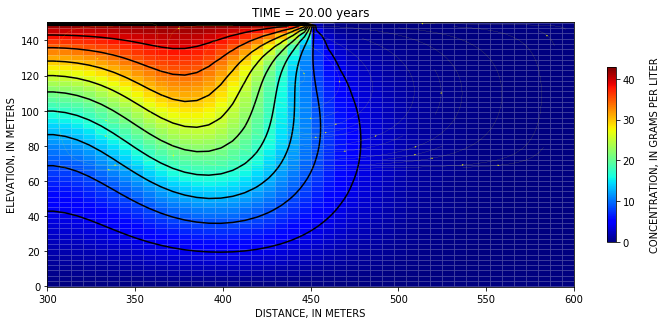

In [18]:
kper = 19
ax = make_figure(gwf, head0[kper], conc_mf6[kper], spdis0[kper], 
                 times0[kper], top0, streamplot=True, csalt=csalt)
ax.set_xlim(300, 600)

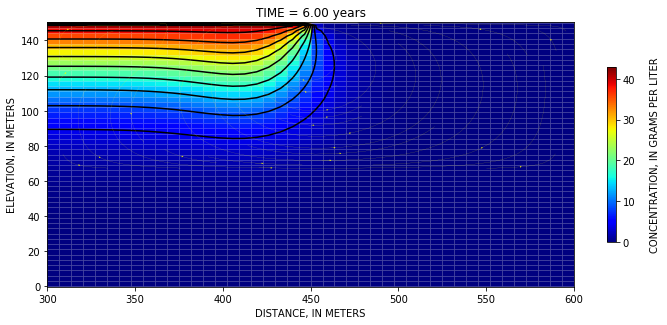

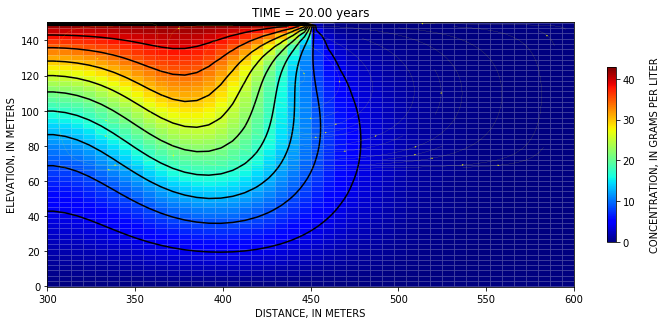

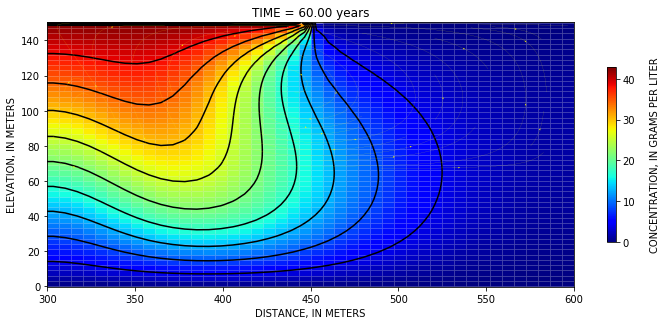

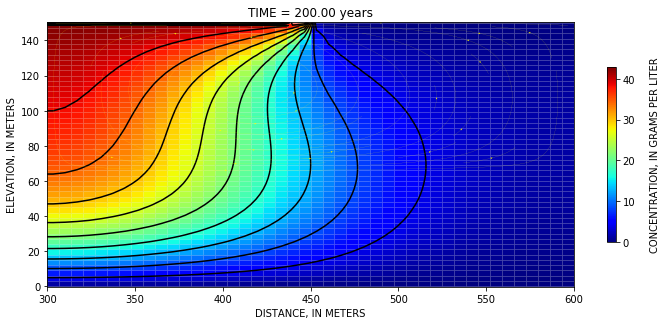

In [19]:
for t in [6, 20, 60, 200]:

    kper = t - 1
    ax = make_figure(gwf, head0[kper], conc_mf6[kper], spdis0[kper], 
                     times0[kper], top0, streamplot=True, csalt=csalt)
    ax.set_xlim(300, 600)

(300, 600)

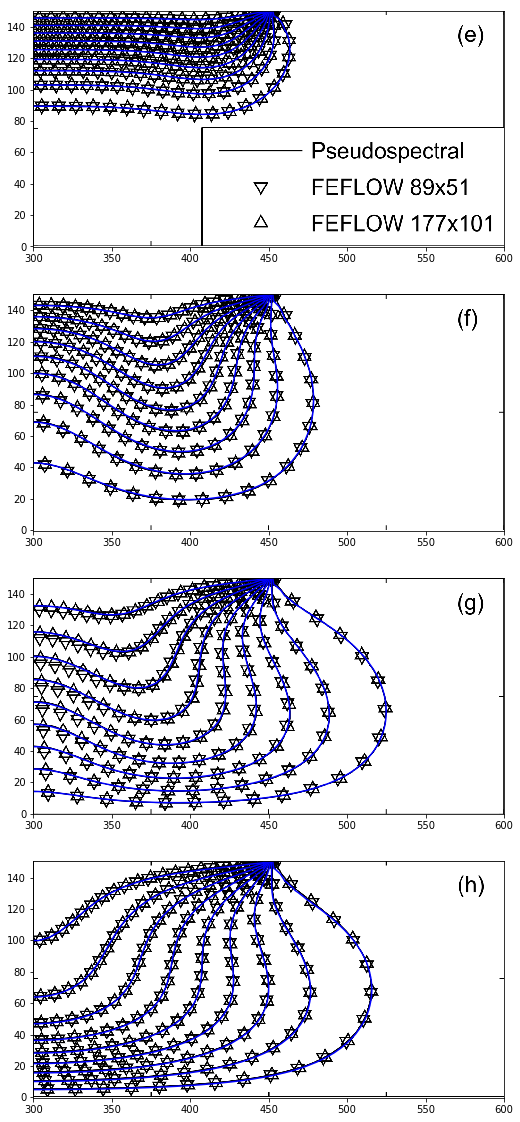

In [20]:
import matplotlib.image as mpimg

imglist = []
fname = os.path.join('data', 'elder_low_ra_t0p03.png')
img = mpimg.imread(fname)
imglist.append(img)
fname = os.path.join('data', 'elder_low_ra_t0p1.png')
img = mpimg.imread(fname)
imglist.append(img)
fname = os.path.join('data', 'elder_low_ra_t0p3.png')
img = mpimg.imread(fname)
imglist.append(img)
fname = os.path.join('data', 'elder_low_ra_t1.png')
img = mpimg.imread(fname)
imglist.append(img)

fig = plt.figure(figsize=(10, 20))
contour_color = 'b'

ax = plt.subplot(4, 1, 1)
kper = 6 - 1
img = imglist[0]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_mf6[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

ax = plt.subplot(4, 1, 2)
kper = 20 - 1
img = imglist[1]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_mf6[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

ax = plt.subplot(4, 1, 3)
kper = 60 - 1
img = imglist[2]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_mf6[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

ax = plt.subplot(4, 1, 4)
kper = 200 - 1
img = imglist[3]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_mf6[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

In [21]:
make_png = False
if make_png:

    pngdir = os.path.join(ws0, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc_mf6.shape[0], 1)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        make_figure(gwf, head0[kper], conc_mf6[kper], spdis0[kper], 
                    times0[kper], top0,
                    streamplot=True, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

# SEAWAT run

In [22]:
model_ws = 'temp/pxx_gwt_elder_seawat'
fname = os.path.join(model_ws, 'MT3D001.UCN')
if os.path.isfile(fname):
    os.remove(fname)
m = flopy.seawat.Seawat(modelname=name, model_ws=model_ws, exe_name='swt_v4')
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper, 
                            delr, delc, top = top, botm = botm, 
                            perlen=time_end/nper, nstp=nstp, steady=False)
bas = flopy.modflow.ModflowBas(m, ibound=1, strt=top0)
lpf = flopy.modflow.ModflowLpf(m, laytyp=0, hk=hydraulic_conductivity, 
                               vka=hydraulic_conductivity, ss=specific_storage)
oc = flopy.modflow.ModflowOc(m)
pcg = flopy.modflow.ModflowPcg(m, mxiter=20, iter1=10, hclose=1.e-8, rclose=1.e-8)
timprs = 365. * np.array([6, 20, 60, 200])
obslist = [[1, 0, ncol//2], [nlay - 2, 0, ncol//2]]
btn = flopy.mt3d.Mt3dBtn(m, prsity=porosity, nprs=timprs.shape[0], timprs=timprs, dt0=365., 
                         obs=obslist)
adv = flopy.mt3d.Mt3dAdv(m, percel=0.1, mixelm=0, nadvfd=2)
dsp = flopy.mt3d.Mt3dDsp(m, al=0, dmcoef=diffusion_coefficient)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=100, cclose=1.e-8)
ssmlist = []
for k, i, j in zip(*np.where(cibd == 1)):
    ssmlist.append([k, i, j, cfresh, -1])
for k, i, j in zip(*np.where(cibd == 2)):
    ssmlist.append([k, i, j, csalt, -1])
cncspd = {0: cnclist}
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssmlist)
vdf = flopy.seawat.SeawatVdf(m, iwtable=0, firstdt=0.001,
                            denseslp=0.7, denseref=rho_0)
m.write_input()
m.run_model()

FloPy is using the following  executable to run the model: /Users/langevin/langevin/bin/mac/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: elder.nam                                                                                                                                                                                               
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/11/04  8:26:12


 STRESS PERIOD NO.    1

  ST

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1298E-01  [K,I,J]    4    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1561E-03  [K,I,J]    2    1   26
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2091E-05  [K,I,J]    3    1   26
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2027E-07  [K,I,J]    7    1   66
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1876E-09  [K,I,J]    5    1   67

  STRESS PERIOD    1 TIME STEP   21 FROM TIME =   146.00     TO    153.30    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   153.30    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1226E-01  [K,I,J]    4    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1448E-03  [K,I,J]    2    1   26
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1955E-05  [K,I,J]    3    1   26
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1824E-07  [K,I,J]    7    1   66
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1710E-09  [K,I,J]    5    1   67

  STRESS PERIOD    1 TIME STEP   22 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6315E-02  [K,I,J]    6    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5087E-04  [K,I,J]    2    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7356E-06  [K,I,J]    3    1   27
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7688E-08  [K,I,J]    6    1   65

  STRESS PERIOD    1 TIME STEP   43 FROM TIME =   306.60     TO    313.90    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   313.90    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6172E-02  [K,I,J]    6    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4912E-04  [K,I,J]    2    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7110E-06  [K,I,J]    3    1   27
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7390E-08  [K,I,J]    6    1   65

  STRESS PERIOD    1 TIME STEP   44 FROM TIME =   313.90     TO    321.20    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   321.20    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3515E-08  [K,I,J]    7    1   64

  STRESS PERIOD    2 TIME STEP   16 FROM TIME =   474.50     TO    481.80    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   481.80    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4121E-02  [K,I,J]    7    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2611E-04  [K,I,J]    2    1   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3832E-06  [K,I,J]    3    1   28
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3460E-08  [K,I,J]    7    1   64

  STRESS PERIOD    2 TIME STEP   17 FROM TIME =   481.80     TO    489.10    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   489.10    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4062E-02  [K,I,J]    7    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2555E-04  [K,I,J]    2    1   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3750E-06  [K,I,J]    3    1   28
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3124E-02  [K,I,J]    8    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1694E-04  [K,I,J]    2    1   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2469E-06  [K,I,J]    3    1   29
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2420E-08  [K,I,J]    7    1   64

  STRESS PERIOD    2 TIME STEP   40 FROM TIME =   649.70     TO    657.00    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   657.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3093E-02  [K,I,J]    8    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1667E-04  [K,I,J]    2    1   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2430E-06  [K,I,J]    3    1   29
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2384E-08  [K,I,J]    7    1   64

  STRESS PERIOD    2 TIME STEP   41 FROM TIME =   657.00     TO    664.30    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   664.30    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD    3 TIME STEP   13 FROM TIME =   817.60     TO    824.90    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   824.90    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2540E-02  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1208E-04  [K,I,J]    2    1   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1749E-06  [K,I,J]    3    1   29
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1715E-08  [K,I,J]    7    1   64

  STRESS PERIOD    3 TIME STEP   14 FROM TIME =   824.90     TO    832.20    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   832.20    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2520E-02  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1193E-04  [K,I,J]    2    1   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1726E-06  [K,I,J]    3    1   29
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1692E-08  [K,I,J]    7    1   64

  STRESS PERIOD    3 TIME STEP   15 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2162E-02  [K,I,J]   10    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9305E-05  [K,I,J]    2    1   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1324E-06  [K,I,J]    3    1   30
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1337E-08  [K,I,J]    7    1   63

  STRESS PERIOD    3 TIME STEP   37 FROM TIME =   992.80     TO    1000.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1000.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2149E-02  [K,I,J]   10    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9208E-05  [K,I,J]    2    1   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1310E-06  [K,I,J]    3    1   30
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1325E-08  [K,I,J]    7    1   63

  STRESS PERIOD    3 TIME STEP   38 FROM TIME =   1000.1     TO    1007.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1007.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1885E-02  [K,I,J]   11    1   60
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7438E-05  [K,I,J]    2    1   30
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1039E-06  [K,I,J]    3    1   30
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1081E-08  [K,I,J]    7    1   63

  STRESS PERIOD    4 TIME STEP   11 FROM TIME =   1168.0     TO    1175.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1175.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1876E-02  [K,I,J]   11    1   60
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7376E-05  [K,I,J]    2    1   30
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1030E-06  [K,I,J]    3    1   30
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1071E-08  [K,I,J]    7    1   63

  STRESS PERIOD    4 TIME STEP   12 FROM TIME =   1175.3     TO    1182.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1182.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1687E-02  [K,I,J]   11    1   60
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6150E-05  [K,I,J]    2    1   30
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8346E-07  [K,I,J]    3    1   31
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8762E-09  [K,I,J]    7    1   63

  STRESS PERIOD    4 TIME STEP   35 FROM TIME =   1343.2     TO    1350.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1350.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1679E-02  [K,I,J]   11    1   60
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6104E-05  [K,I,J]    2    1   30
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8278E-07  [K,I,J]    3    1   31
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8686E-09  [K,I,J]    7    1   63

  STRESS PERIOD    4 TIME STEP   36 FROM TIME =   1350.5     TO    1357.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1357.8    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1531E-02  [K,I,J]   12    1   60
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5196E-05  [K,I,J]    2    1   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7208E-07  [K,I,J]    8    1   62
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7126E-09  [K,I,J]    7    1   63

  STRESS PERIOD    5 TIME STEP    9 FROM TIME =   1518.4     TO    1525.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1525.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1525E-02  [K,I,J]   12    1   60
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5163E-05  [K,I,J]    2    1   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7171E-07  [K,I,J]    8    1   62
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7065E-09  [K,I,J]    7    1   63

  STRESS PERIOD    5 TIME STEP   10 FROM TIME =   1525.7     TO    1533.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1533.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1407E-02  [K,I,J]   13    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4507E-05  [K,I,J]    2    1   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6357E-07  [K,I,J]    8    1   62
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6021E-09  [K,I,J]    8    1   62

  STRESS PERIOD    5 TIME STEP   33 FROM TIME =   1693.6     TO    1700.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1700.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1402E-02  [K,I,J]   13    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4481E-05  [K,I,J]    2    1   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6323E-07  [K,I,J]    8    1   62
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5983E-09  [K,I,J]    8    1   62

  STRESS PERIOD    5 TIME STEP   34 FROM TIME =   1700.9     TO    1708.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1708.2    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1311E-02  [K,I,J]   13    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3953E-05  [K,I,J]    2    1   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5581E-07  [K,I,J]    8    1   62
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5308E-09  [K,I,J]    5    1   66

  STRESS PERIOD    6 TIME STEP    7 FROM TIME =   1868.8     TO    1876.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1876.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1307E-02  [K,I,J]   13    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3932E-05  [K,I,J]    2    1   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5551E-07  [K,I,J]    8    1   62
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5290E-09  [K,I,J]    5    1   66

  STRESS PERIOD    6 TIME STEP    8 FROM TIME =   1876.1     TO    1883.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   1883.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1227E-02  [K,I,J]   14    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3491E-05  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4993E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4888E-09  [K,I,J]    5    1   66

  STRESS PERIOD    6 TIME STEP   32 FROM TIME =   2051.3     TO    2058.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2058.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1224E-02  [K,I,J]   14    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3476E-05  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4974E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4872E-09  [K,I,J]    5    1   66

  STRESS PERIOD    6 TIME STEP   33 FROM TIME =   2058.6     TO    2065.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2065.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1153E-02  [K,I,J]   15    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3137E-05  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4534E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4529E-09  [K,I,J]    5    1   66

  STRESS PERIOD    7 TIME STEP    7 FROM TIME =   2233.8     TO    2241.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2241.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1151E-02  [K,I,J]   15    1   59
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3124E-05  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4514E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4524E-09  [K,I,J]    5    1   66

  STRESS PERIOD    7 TIME STEP    8 FROM TIME =   2241.1     TO    2248.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2248.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1095E-02  [K,I,J]   15    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2841E-05  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4098E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4303E-09  [K,I,J]    3    1   33

  STRESS PERIOD    7 TIME STEP   31 FROM TIME =   2409.0     TO    2416.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2416.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1093E-02  [K,I,J]   15    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2830E-05  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4080E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4295E-09  [K,I,J]    3    1   33

  STRESS PERIOD    7 TIME STEP   32 FROM TIME =   2416.3     TO    2423.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2423.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2585E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3684E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4230E-09  [K,I,J]    3    1   23

  STRESS PERIOD    8 TIME STEP    5 FROM TIME =   2584.2     TO    2591.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2591.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1045E-02  [K,I,J]   16    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2576E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3667E-07  [K,I,J]    9    1   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4231E-09  [K,I,J]    3    1   23

  STRESS PERIOD    8 TIME STEP    6 FROM TIME =   2591.5     TO    2598.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2598.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1044E-02  [K,I,J]   16    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1004E-02  [K,I,J]   16    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2385E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3463E-07  [K,I,J]    2    1   57
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4352E-09  [K,I,J]    3    1   24

  STRESS PERIOD    8 TIME STEP   29 FROM TIME =   2759.4     TO    2766.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2766.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1002E-02  [K,I,J]   16    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2377E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3459E-07  [K,I,J]    2    1   57
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4357E-09  [K,I,J]    3    1   24

  STRESS PERIOD    8 TIME STEP   30 FROM TIME =   2766.7     TO    2774.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2774.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9657E-03  [K,I,J]   17    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2206E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3374E-07  [K,I,J]    2    1   57
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4447E-09  [K,I,J]    3    1   24

  STRESS PERIOD    9 TIME STEP    3 FROM TIME =   2934.6     TO    2941.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2941.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9641E-03  [K,I,J]   17    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2199E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3370E-07  [K,I,J]    2    1   57
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4450E-09  [K,I,J]    3    1   24

  STRESS PERIOD    9 TIME STEP    4 FROM TIME =   2941.9     TO    2949.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   2949.2    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD    9 TIME STEP   27 FROM TIME =   3109.8     TO    3117.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3117.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9286E-03  [K,I,J]   18    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2036E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3319E-07  [K,I,J]    2    1   56
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4506E-09  [K,I,J]    3    1   24

  STRESS PERIOD    9 TIME STEP   28 FROM TIME =   3117.1     TO    3124.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3124.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9273E-03  [K,I,J]   18    1   58
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2030E-05  [K,I,J]    2    1   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3318E-07  [K,I,J]    2    1   56
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4508E-09  [K,I,J]    3    1   24

  STRESS PERIOD    9 TIME STEP   29 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8984E-03  [K,I,J]   18    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1899E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3294E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4529E-09  [K,I,J]    3    1   24

 STRESS PERIOD NO.   10

  STRESS PERIOD   10 TIME STEP    1 FROM TIME =   3285.0     TO    3292.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3292.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8973E-03  [K,I,J]   18    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1894E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3293E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4529E-09  [K,I,J]    3    1   24

  STRESS PERIOD   10 TIME STEP    2 FROM TIME =   3292.3     TO    3299.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3299.6    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1781E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3284E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4525E-09  [K,I,J]    3    1   24

  STRESS PERIOD   10 TIME STEP   25 FROM TIME =   3460.2     TO    3467.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3467.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8704E-03  [K,I,J]   18    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3283E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4524E-09  [K,I,J]    3    1   24

  STRESS PERIOD   10 TIME STEP   26 FROM TIME =   3467.5     TO    3474.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3474.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8695E-03  [K,I,J]   19    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8470E-03  [K,I,J]   19    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1666E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3273E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4525E-09  [K,I,J]    3    1   25

  STRESS PERIOD   10 TIME STEP   50 FROM TIME =   3642.7     TO    3650.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3650.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8460E-03  [K,I,J]   19    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1662E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3272E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4526E-09  [K,I,J]    3    1   25

 STRESS PERIOD NO.   11

  STRESS PERIOD   11 TIME STEP    1 FROM TIME =   3650.0     TO    3657.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3657.3    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8241E-03  [K,I,J]   20    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1563E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3261E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4522E-09  [K,I,J]    3    1   25

  STRESS PERIOD   11 TIME STEP   24 FROM TIME =   3817.9     TO    3825.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3825.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8232E-03  [K,I,J]   20    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1559E-05  [K,I,J]    2    1   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3260E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4522E-09  [K,I,J]    3    1   25

  STRESS PERIOD   11 TIME STEP   25 FROM TIME =   3825.2     TO    3832.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   3832.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8011E-03  [K,I,J]   21    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1469E-05  [K,I,J]    2    1   55
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3246E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4494E-09  [K,I,J]    3    1   25

  STRESS PERIOD   11 TIME STEP   49 FROM TIME =   4000.4     TO    4007.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4007.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8003E-03  [K,I,J]   21    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1465E-05  [K,I,J]    2    1   55
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3246E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4492E-09  [K,I,J]    3    1   25

  STRESS PERIOD   11 TIME STEP   50 FROM TIME =   4007.7     TO    4015.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4015.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7806E-03  [K,I,J]   21    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1383E-05  [K,I,J]    2    1   55
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3228E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4442E-09  [K,I,J]    3    1   25

  STRESS PERIOD   12 TIME STEP   24 FROM TIME =   4182.9     TO    4190.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4190.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7797E-03  [K,I,J]   21    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1379E-05  [K,I,J]    2    1   55
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3227E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4440E-09  [K,I,J]    3    1   25

  STRESS PERIOD   12 TIME STEP   25 FROM TIME =   4190.2     TO    4197.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4197.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7614E-03  [K,I,J]   22    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1305E-05  [K,I,J]    2    1   35
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3206E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4374E-09  [K,I,J]    3    1   25

  STRESS PERIOD   12 TIME STEP   48 FROM TIME =   4358.1     TO    4365.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4365.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7606E-03  [K,I,J]   22    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1301E-05  [K,I,J]    2    1   35
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3205E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4370E-09  [K,I,J]    3    1   25

  STRESS PERIOD   12 TIME STEP   49 FROM TIME =   4365.4     TO    4372.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4372.7    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD   13 TIME STEP   22 FROM TIME =   4533.3     TO    4540.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4540.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7420E-03  [K,I,J]   23    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1231E-05  [K,I,J]    2    1   23
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3178E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4284E-09  [K,I,J]    3    1   25

  STRESS PERIOD   13 TIME STEP   23 FROM TIME =   4540.6     TO    4547.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4547.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7413E-03  [K,I,J]   23    1   57
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1228E-05  [K,I,J]    2    1   23
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3176E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4280E-09  [K,I,J]    3    1   25

  STRESS PERIOD   13 TIME STEP   24 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7251E-03  [K,I,J]   22    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1168E-05  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3144E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4184E-09  [K,I,J]    3    1   25

  STRESS PERIOD   13 TIME STEP   47 FROM TIME =   4715.8     TO    4723.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4723.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7244E-03  [K,I,J]   22    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1166E-05  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3142E-07  [K,I,J]    2    1   66
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4179E-09  [K,I,J]    3    1   25

  STRESS PERIOD   13 TIME STEP   48 FROM TIME =   4723.1     TO    4730.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4730.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7107E-03  [K,I,J]   23    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1111E-05  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3130E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4076E-09  [K,I,J]    3    1   25

  STRESS PERIOD   14 TIME STEP   20 FROM TIME =   4883.7     TO    4891.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4891.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7100E-03  [K,I,J]   23    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1108E-05  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3129E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4071E-09  [K,I,J]    3    1   25

  STRESS PERIOD   14 TIME STEP   21 FROM TIME =   4891.0     TO    4898.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   4898.3    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6941E-03  [K,I,J]   24    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1048E-05  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3103E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3942E-09  [K,I,J]    3    1   25

  STRESS PERIOD   14 TIME STEP   46 FROM TIME =   5073.5     TO    5080.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5080.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6935E-03  [K,I,J]   24    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1045E-05  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3102E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3936E-09  [K,I,J]    3    1   25

  STRESS PERIOD   14 TIME STEP   47 FROM TIME =   5080.8     TO    5088.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5088.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6778E-03  [K,I,J]   24    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9870E-06  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3062E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3796E-09  [K,I,J]    3    1   25

  STRESS PERIOD   15 TIME STEP   22 FROM TIME =   5263.3     TO    5270.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5270.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6771E-03  [K,I,J]   24    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9847E-06  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3060E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3791E-09  [K,I,J]    3    1   25

  STRESS PERIOD   15 TIME STEP   23 FROM TIME =   5270.6     TO    5277.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5277.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6624E-03  [K,I,J]   25    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9281E-06  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3007E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3642E-09  [K,I,J]    3    1   25

  STRESS PERIOD   15 TIME STEP   48 FROM TIME =   5453.1     TO    5460.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5460.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6617E-03  [K,I,J]   25    1   56
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9258E-06  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3004E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3636E-09  [K,I,J]    3    1   25

  STRESS PERIOD   15 TIME STEP   49 FROM TIME =   5460.4     TO    5467.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5467.7    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6469E-03  [K,I,J]   26    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8723E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2937E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3480E-09  [K,I,J]    3    1   25

  STRESS PERIOD   16 TIME STEP   24 FROM TIME =   5642.9     TO    5650.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5650.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6463E-03  [K,I,J]   26    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8704E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2934E-07  [K,I,J]    2    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3474E-09  [K,I,J]    3    1   25

  STRESS PERIOD   16 TIME STEP   25 FROM TIME =   5650.2     TO    5657.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5657.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6312E-03  [K,I,J]   27    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8245E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2869E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3313E-09  [K,I,J]    3    1   25

  STRESS PERIOD   16 TIME STEP   50 FROM TIME =   5832.7     TO    5840.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5840.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6306E-03  [K,I,J]   27    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8227E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2866E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3307E-09  [K,I,J]    3    1   25

 STRESS PERIOD NO.   17

  STRESS PERIOD   17 TIME STEP    1 FROM TIME =   5840.0     TO    5847.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   5847.3    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6160E-03  [K,I,J]   27    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7782E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2798E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3141E-09  [K,I,J]    3    1   25

  STRESS PERIOD   17 TIME STEP   26 FROM TIME =   6022.5     TO    6029.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6029.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6153E-03  [K,I,J]   27    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7765E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2795E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3135E-09  [K,I,J]    3    1   25

  STRESS PERIOD   17 TIME STEP   27 FROM TIME =   6029.8     TO    6037.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6037.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6009E-03  [K,I,J]   28    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7334E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2716E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2967E-09  [K,I,J]    3    1   25

  STRESS PERIOD   18 TIME STEP    2 FROM TIME =   6212.3     TO    6219.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6219.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6003E-03  [K,I,J]   28    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7317E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2713E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2960E-09  [K,I,J]    3    1   25

  STRESS PERIOD   18 TIME STEP    3 FROM TIME =   6219.6     TO    6226.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6226.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5855E-03  [K,I,J]   29    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6901E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2625E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2806E-09  [K,I,J]    3    1   26

  STRESS PERIOD   18 TIME STEP   28 FROM TIME =   6402.1     TO    6409.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6409.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5850E-03  [K,I,J]   29    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6885E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2621E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2800E-09  [K,I,J]    3    1   26

  STRESS PERIOD   18 TIME STEP   29 FROM TIME =   6409.4     TO    6416.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6416.7    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5701E-03  [K,I,J]   29    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6485E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2525E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2646E-09  [K,I,J]    3    1   26

  STRESS PERIOD   19 TIME STEP    4 FROM TIME =   6591.9     TO    6599.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6599.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5695E-03  [K,I,J]   29    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6469E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2521E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2640E-09  [K,I,J]    3    1   26

  STRESS PERIOD   19 TIME STEP    5 FROM TIME =   6599.2     TO    6606.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6606.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5550E-03  [K,I,J]   30    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6085E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2420E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2484E-09  [K,I,J]    3    1   26

  STRESS PERIOD   19 TIME STEP   30 FROM TIME =   6781.7     TO    6789.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6789.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5544E-03  [K,I,J]   30    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6070E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2416E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2478E-09  [K,I,J]    3    1   26

  STRESS PERIOD   19 TIME STEP   31 FROM TIME =   6789.0     TO    6796.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6796.3    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5394E-03  [K,I,J]   31    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5704E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2310E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2321E-09  [K,I,J]    3    1   26

  STRESS PERIOD   20 TIME STEP    6 FROM TIME =   6971.5     TO    6978.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6978.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5388E-03  [K,I,J]   31    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5690E-06  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2306E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2315E-09  [K,I,J]    3    1   26

  STRESS PERIOD   20 TIME STEP    7 FROM TIME =   6978.8     TO    6986.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   6986.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5239E-03  [K,I,J]   31    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5357E-06  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2198E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2158E-09  [K,I,J]    3    1   26

  STRESS PERIOD   20 TIME STEP   32 FROM TIME =   7161.3     TO    7168.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7168.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5232E-03  [K,I,J]   31    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5345E-06  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2194E-07  [K,I,J]    2    1   53
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2152E-09  [K,I,J]    3    1   26

  STRESS PERIOD   20 TIME STEP   33 FROM TIME =   7168.6     TO    7175.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7175.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5073E-06  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2103E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2008E-09  [K,I,J]    3    1   26

  STRESS PERIOD   21 TIME STEP    7 FROM TIME =   7343.8     TO    7351.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7351.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5082E-03  [K,I,J]   32    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5061E-06  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2101E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2002E-09  [K,I,J]    3    1   26

  STRESS PERIOD   21 TIME STEP    8 FROM TIME =   7351.1     TO    7358.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7358.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5076E-03  [K,I,J]   32    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. D


  STRESS PERIOD   21 TIME STEP   32 FROM TIME =   7526.3     TO    7533.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7533.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4927E-03  [K,I,J]   32    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4790E-06  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2014E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1847E-09  [K,I,J]    3    1   26

  STRESS PERIOD   21 TIME STEP   33 FROM TIME =   7533.6     TO    7540.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7540.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4921E-03  [K,I,J]   32    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4779E-06  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2010E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1841E-09  [K,I,J]    3    1   26

  STRESS PERIOD   21 TIME STEP   34 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4770E-03  [K,I,J]   33    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4614E-06  [K,I,J]   36    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1922E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1690E-09  [K,I,J]    3    1   26

  STRESS PERIOD   22 TIME STEP    9 FROM TIME =   7723.4     TO    7730.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7730.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4764E-03  [K,I,J]   33    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4612E-06  [K,I,J]   36    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1919E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1684E-09  [K,I,J]    3    1   26

  STRESS PERIOD   22 TIME STEP   10 FROM TIME =   7730.7     TO    7738.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7738.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4605E-03  [K,I,J]   33    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4549E-06  [K,I,J]   37    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1833E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1544E-09  [K,I,J]    3    1   27

  STRESS PERIOD   22 TIME STEP   35 FROM TIME =   7913.2     TO    7920.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7920.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4598E-03  [K,I,J]   33    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4547E-06  [K,I,J]   37    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1829E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1539E-09  [K,I,J]    3    1   27

  STRESS PERIOD   22 TIME STEP   36 FROM TIME =   7920.5     TO    7927.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   7927.8    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4445E-03  [K,I,J]   34    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4482E-06  [K,I,J]   37    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1746E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1411E-09  [K,I,J]    3    1   27

  STRESS PERIOD   23 TIME STEP   11 FROM TIME =   8103.0     TO    8110.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8110.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4439E-03  [K,I,J]   34    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4479E-06  [K,I,J]   37    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1743E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1406E-09  [K,I,J]    3    1   27

  STRESS PERIOD   23 TIME STEP   12 FROM TIME =   8110.3     TO    8117.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8117.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4278E-03  [K,I,J]   34    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4397E-06  [K,I,J]   37    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1662E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1282E-09  [K,I,J]    3    1   27

  STRESS PERIOD   23 TIME STEP   37 FROM TIME =   8292.8     TO    8300.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8300.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4271E-03  [K,I,J]   34    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4393E-06  [K,I,J]   37    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1659E-07  [K,I,J]    2    1   52
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1277E-09  [K,I,J]    3    1   27

  STRESS PERIOD   23 TIME STEP   38 FROM TIME =   8300.1     TO    8307.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8307.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4115E-03  [K,I,J]   35    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4295E-06  [K,I,J]   38    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1591E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1158E-09  [K,I,J]    3    1   27

  STRESS PERIOD   24 TIME STEP   13 FROM TIME =   8482.6     TO    8489.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8489.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4108E-03  [K,I,J]   35    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4292E-06  [K,I,J]   38    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1589E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1154E-09  [K,I,J]    3    1   27

  STRESS PERIOD   24 TIME STEP   14 FROM TIME =   8489.9     TO    8497.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8497.2    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3948E-03  [K,I,J]   35    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4196E-06  [K,I,J]   38    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1535E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1040E-09  [K,I,J]    3    1   28

  STRESS PERIOD   24 TIME STEP   39 FROM TIME =   8672.4     TO    8679.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8679.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3941E-03  [K,I,J]   35    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4192E-06  [K,I,J]   38    1   64
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1533E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1036E-09  [K,I,J]    3    1   28

  STRESS PERIOD   24 TIME STEP   40 FROM TIME =   8679.7     TO    8687.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8687.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3780E-03  [K,I,J]   36    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4120E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1482E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9547E-10  [K,I,J]   51    1   29

  STRESS PERIOD   25 TIME STEP   15 FROM TIME =   8862.2     TO    8869.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8869.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3774E-03  [K,I,J]   36    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4118E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1480E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9539E-10  [K,I,J]   51    1   29

  STRESS PERIOD   25 TIME STEP   16 FROM TIME =   8869.5     TO    8876.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   8876.8    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3616E-03  [K,I,J]   36    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4054E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1433E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9320E-10  [K,I,J]   51    1   29

  STRESS PERIOD   25 TIME STEP   41 FROM TIME =   9052.0     TO    9059.3    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9059.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3610E-03  [K,I,J]   36    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4051E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1431E-07  [K,I,J]    2    1   51
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9311E-10  [K,I,J]   51    1   29

  STRESS PERIOD   25 TIME STEP   42 FROM TIME =   9059.3     TO    9066.6    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9066.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3450E-03  [K,I,J]   36    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3974E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1395E-07  [K,I,J]    2    1   50
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9069E-10  [K,I,J]   51    1   29

  STRESS PERIOD   26 TIME STEP   17 FROM TIME =   9241.8     TO    9249.1    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9249.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3444E-03  [K,I,J]   36    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3970E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1394E-07  [K,I,J]    2    1   50
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9059E-10  [K,I,J]   51    1   29

  STRESS PERIOD   26 TIME STEP   18 FROM TIME =   9249.1     TO    9256.4    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9256.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3284E-03  [K,I,J]   37    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3882E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1371E-07  [K,I,J]    2    1   50
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8800E-10  [K,I,J]   51    1   29

  STRESS PERIOD   26 TIME STEP   43 FROM TIME =   9431.6     TO    9438.9    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9438.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3278E-03  [K,I,J]   37    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3878E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1370E-07  [K,I,J]    2    1   50
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8790E-10  [K,I,J]   51    1   29

  STRESS PERIOD   26 TIME STEP   44 FROM TIME =   9438.9     TO    9446.2    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9446.2    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3124E-03  [K,I,J]   37    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3779E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1349E-07  [K,I,J]    2    1   50
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8516E-10  [K,I,J]   51    1   29

  STRESS PERIOD   27 TIME STEP   19 FROM TIME =   9621.4     TO    9628.7    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9628.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3118E-03  [K,I,J]   37    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3775E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1348E-07  [K,I,J]    2    1   50
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8504E-10  [K,I,J]   51    1   29

  STRESS PERIOD   27 TIME STEP   20 FROM TIME =   9628.7     TO    9636.0    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9636.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2965E-03  [K,I,J]   37    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3667E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1341E-07  [K,I,J]    2    1   49
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8219E-10  [K,I,J]   51    1   29

  STRESS PERIOD   27 TIME STEP   45 FROM TIME =   9811.2     TO    9818.5    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9818.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2959E-03  [K,I,J]   37    1   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3663E-06  [K,I,J]   37    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1341E-07  [K,I,J]    2    1   49
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8207E-10  [K,I,J]   51    1   29

  STRESS PERIOD   27 TIME STEP   46 FROM TIME =   9818.5     TO    9825.8    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   9825.8    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2807E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3554E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1339E-07  [K,I,J]    2    1   49
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7911E-10  [K,I,J]   51    1   29

  STRESS PERIOD   28 TIME STEP   21 FROM TIME =   10001.     TO    10008.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10008.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2802E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3549E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1339E-07  [K,I,J]    2    1   49
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7899E-10  [K,I,J]   51    1   29

  STRESS PERIOD   28 TIME STEP   22 FROM TIME =   10008.     TO    10016.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10016.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2659E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3434E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1349E-07  [K,I,J]    2    1   48
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7594E-10  [K,I,J]   51    1   29

  STRESS PERIOD   28 TIME STEP   47 FROM TIME =   10191.     TO    10198.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10198.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2653E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3429E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1350E-07  [K,I,J]    2    1   48
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7582E-10  [K,I,J]   51    1   29

  STRESS PERIOD   28 TIME STEP   48 FROM TIME =   10198.     TO    10205.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10205.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2513E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3308E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1365E-07  [K,I,J]    2    1   47
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7270E-10  [K,I,J]   51    1   29

  STRESS PERIOD   29 TIME STEP   23 FROM TIME =   10381.     TO    10388.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10388.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2507E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3303E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1366E-07  [K,I,J]    2    1   47
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7257E-10  [K,I,J]   51    1   29

  STRESS PERIOD   29 TIME STEP   24 FROM TIME =   10388.     TO    10395.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10395.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2371E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3197E-06  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1386E-07  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7276E-10  [K,I,J]    3    1   49

  STRESS PERIOD   29 TIME STEP   49 FROM TIME =   10570.     TO    10578.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10578.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2365E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3200E-06  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1387E-07  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7279E-10  [K,I,J]    3    1   49

  STRESS PERIOD   29 TIME STEP   50 FROM TIME =   10578.     TO    10585.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10585.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3268E-06  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1408E-07  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7417E-10  [K,I,J]    3    1   48

  STRESS PERIOD   30 TIME STEP   25 FROM TIME =   10760.     TO    10767.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10767.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2228E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3271E-06  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1409E-07  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7422E-10  [K,I,J]    3    1   48

  STRESS PERIOD   30 TIME STEP   26 FROM TIME =   10767.     TO    10775.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10775.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2223E-03  [K,I,J]   37    1   34
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7552E-10  [K,I,J]    3    1   48

 STRESS PERIOD NO.   31

  STRESS PERIOD   31 TIME STEP    1 FROM TIME =   10950.     TO    10957.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10957.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2097E-03  [K,I,J]   37    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3335E-06  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1427E-07  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7557E-10  [K,I,J]    3    1   48

  STRESS PERIOD   31 TIME STEP    2 FROM TIME =   10957.     TO    10965.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   10965.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2093E-03  [K,I,J]   37    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3337E-06  [K,I,J]    2    1   46
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1427E-07  [K,I,J]    2    1   46
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1972E-03  [K,I,J]   37    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3396E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1443E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7681E-10  [K,I,J]    3    1   48

  STRESS PERIOD   31 TIME STEP   29 FROM TIME =   11154.     TO    11162.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11162.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1968E-03  [K,I,J]   37    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3398E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1443E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7686E-10  [K,I,J]    3    1   48

  STRESS PERIOD   31 TIME STEP   30 FROM TIME =   11162.     TO    11169.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11169.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1856E-03  [K,I,J]   37    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3451E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1453E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7783E-10  [K,I,J]    3    1   48

  STRESS PERIOD   32 TIME STEP    5 FROM TIME =   11344.     TO    11351.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11351.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1852E-03  [K,I,J]   37    1   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3453E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1453E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7787E-10  [K,I,J]    3    1   48

  STRESS PERIOD   32 TIME STEP    6 FROM TIME =   11351.     TO    11359.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11359.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1762E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3500E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1459E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7869E-10  [K,I,J]    3    1   48

  STRESS PERIOD   32 TIME STEP   32 FROM TIME =   11541.     TO    11549.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11549.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1762E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3502E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1459E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7872E-10  [K,I,J]    3    1   48

  STRESS PERIOD   32 TIME STEP   33 FROM TIME =   11549.     TO    11556.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11556.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1764E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3543E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1460E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7943E-10  [K,I,J]    3    1   47

  STRESS PERIOD   33 TIME STEP   10 FROM TIME =   11746.     TO    11753.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11753.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1764E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3544E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1460E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7946E-10  [K,I,J]    3    1   47

  STRESS PERIOD   33 TIME STEP   11 FROM TIME =   11753.     TO    11760.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11760.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1764E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3578E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1455E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8015E-10  [K,I,J]    3    1   47

  STRESS PERIOD   33 TIME STEP   38 FROM TIME =   11950.     TO    11957.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11957.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1764E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3579E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1455E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8017E-10  [K,I,J]    3    1   47

  STRESS PERIOD   33 TIME STEP   39 FROM TIME =   11957.     TO    11965.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   11965.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1764E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3604E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1446E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8062E-10  [K,I,J]    3    1   47

  STRESS PERIOD   34 TIME STEP   16 FROM TIME =   12154.     TO    12162.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12162.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1764E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3605E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1446E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8063E-10  [K,I,J]    3    1   47

  STRESS PERIOD   34 TIME STEP   17 FROM TIME =   12162.     TO    12169.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12169.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1763E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3622E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1433E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8086E-10  [K,I,J]    3    1   47

  STRESS PERIOD   34 TIME STEP   44 FROM TIME =   12359.     TO    12366.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12366.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1763E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3623E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1432E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8086E-10  [K,I,J]    3    1   47

  STRESS PERIOD   34 TIME STEP   45 FROM TIME =   12366.     TO    12373.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12373.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1760E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3634E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1415E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8087E-10  [K,I,J]    3    1   47

  STRESS PERIOD   35 TIME STEP   22 FROM TIME =   12563.     TO    12571.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12571.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1760E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3634E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1414E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8086E-10  [K,I,J]    3    1   47

  STRESS PERIOD   35 TIME STEP   23 FROM TIME =   12571.     TO    12578.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12578.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1757E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1394E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8066E-10  [K,I,J]    3    1   47

  STRESS PERIOD   35 TIME STEP   50 FROM TIME =   12768.     TO    12775.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12775.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1756E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3638E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1393E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8065E-10  [K,I,J]    3    1   47

 STRESS PERIOD NO.   36

  STRESS PERIOD   36 TIME STEP    1 FROM TIME =   12775.     TO    12782.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12782.    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1751E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3635E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1370E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8026E-10  [K,I,J]    3    1   47

  STRESS PERIOD   36 TIME STEP   28 FROM TIME =   12972.     TO    12979.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12979.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1751E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3635E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1369E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8024E-10  [K,I,J]    3    1   47

  STRESS PERIOD   36 TIME STEP   29 FROM TIME =   12979.     TO    12987.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   12987.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1745E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3627E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1343E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7968E-10  [K,I,J]    3    1   47

  STRESS PERIOD   37 TIME STEP    6 FROM TIME =   13176.     TO    13184.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13184.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1745E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3626E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1342E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7965E-10  [K,I,J]    3    1   47

  STRESS PERIOD   37 TIME STEP    7 FROM TIME =   13184.     TO    13191.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13191.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1738E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3613E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1314E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7893E-10  [K,I,J]    3    1   47

  STRESS PERIOD   37 TIME STEP   34 FROM TIME =   13381.     TO    13388.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13388.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1737E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3612E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1313E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7890E-10  [K,I,J]    3    1   47

  STRESS PERIOD   37 TIME STEP   35 FROM TIME =   13388.     TO    13395.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13395.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1729E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3593E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1284E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7803E-10  [K,I,J]    3    1   47

  STRESS PERIOD   38 TIME STEP   12 FROM TIME =   13585.     TO    13593.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13593.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1729E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3592E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1283E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7800E-10  [K,I,J]    3    1   47

  STRESS PERIOD   38 TIME STEP   13 FROM TIME =   13593.     TO    13600.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13600.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1720E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3569E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1252E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7701E-10  [K,I,J]    3    1   47

  STRESS PERIOD   38 TIME STEP   40 FROM TIME =   13790.     TO    13797.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13797.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1720E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3568E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1251E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7698E-10  [K,I,J]    3    1   47

  STRESS PERIOD   38 TIME STEP   41 FROM TIME =   13797.     TO    13804.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   13804.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1710E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3541E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1220E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7589E-10  [K,I,J]    3    1   47

  STRESS PERIOD   39 TIME STEP   18 FROM TIME =   13994.     TO    14001.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14001.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1710E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3540E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1219E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7584E-10  [K,I,J]    3    1   47

  STRESS PERIOD   39 TIME STEP   19 FROM TIME =   14001.     TO    14009.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14009.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1700E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3509E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1187E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7467E-10  [K,I,J]    3    1   47

  STRESS PERIOD   39 TIME STEP   46 FROM TIME =   14198.     TO    14206.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14206.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1699E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3508E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1186E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7462E-10  [K,I,J]    3    1   47

  STRESS PERIOD   39 TIME STEP   47 FROM TIME =   14206.     TO    14213.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14213.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1689E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3474E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1155E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7337E-10  [K,I,J]    3    1   47

  STRESS PERIOD   40 TIME STEP   24 FROM TIME =   14403.     TO    14410.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14410.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1688E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3472E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1154E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7332E-10  [K,I,J]    3    1   47

  STRESS PERIOD   40 TIME STEP   25 FROM TIME =   14410.     TO    14417.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14417.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1677E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3436E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1123E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7202E-10  [K,I,J]    3    1   47

  STRESS PERIOD   41 TIME STEP    2 FROM TIME =   14607.     TO    14615.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14615.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1677E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3434E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1121E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7197E-10  [K,I,J]    3    1   47

  STRESS PERIOD   41 TIME STEP    3 FROM TIME =   14615.     TO    14622.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14622.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1665E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3395E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1091E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7062E-10  [K,I,J]    3    1   47

  STRESS PERIOD   41 TIME STEP   30 FROM TIME =   14812.     TO    14819.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14819.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1665E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3393E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1090E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7057E-10  [K,I,J]    3    1   47

  STRESS PERIOD   41 TIME STEP   31 FROM TIME =   14819.     TO    14826.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   14826.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1653E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3352E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1060E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6919E-10  [K,I,J]    3    1   47

  STRESS PERIOD   42 TIME STEP    8 FROM TIME =   15016.     TO    15023.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15023.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1652E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3351E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1059E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6913E-10  [K,I,J]    3    1   47

  STRESS PERIOD   42 TIME STEP    9 FROM TIME =   15023.     TO    15031.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15031.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD   42 TIME STEP   35 FROM TIME =   15213.     TO    15220.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15220.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1641E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3308E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1029E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6773E-10  [K,I,J]    3    1   47

  STRESS PERIOD   42 TIME STEP   36 FROM TIME =   15220.     TO    15228.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15228.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1640E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3306E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1028E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6768E-10  [K,I,J]    3    1   47

  STRESS PERIOD   42 TIME STEP   37 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1628E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3263E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1001E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6633E-10  [K,I,J]    3    1   47

  STRESS PERIOD   43 TIME STEP   13 FROM TIME =   15418.     TO    15425.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15425.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1628E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3262E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9998E-08  [K,I,J]    2    1   45

  STRESS PERIOD   43 TIME STEP   14 FROM TIME =   15425.     TO    15432.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15432.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1628E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1615E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3213E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9703E-08  [K,I,J]    2    1   45

  STRESS PERIOD   43 TIME STEP   43 FROM TIME =   15637.     TO    15644.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15644.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1614E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3211E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9693E-08  [K,I,J]    2    1   45

  STRESS PERIOD   43 TIME STEP   44 FROM TIME =   15644.     TO    15651.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15651.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1614E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3209E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3163E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9418E-08  [K,I,J]    2    1   45

  STRESS PERIOD   44 TIME STEP   22 FROM TIME =   15848.     TO    15856.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15856.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1601E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3161E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9408E-08  [K,I,J]    2    1   45

  STRESS PERIOD   44 TIME STEP   23 FROM TIME =   15856.     TO    15863.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   15863.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1601E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3159E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9399E-08  [K,I,J]    2    1   45

  STRESS PERIOD   44 TIME STEP   24 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1589E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3113E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9144E-08  [K,I,J]    2    1   45

 STRESS PERIOD NO.   45

  STRESS PERIOD   45 TIME STEP    1 FROM TIME =   16060.     TO    16067.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16067.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1588E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3111E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9135E-08  [K,I,J]    2    1   45

  STRESS PERIOD   45 TIME STEP    2 FROM TIME =   16067.     TO    16075.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16075.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1588E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3109E-06  [K,I,J]    2    1   45
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1575E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3060E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8872E-08  [K,I,J]    2    1   45

  STRESS PERIOD   45 TIME STEP   31 FROM TIME =   16279.     TO    16286.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16286.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1575E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3058E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8863E-08  [K,I,J]    2    1   45

  STRESS PERIOD   45 TIME STEP   32 FROM TIME =   16286.     TO    16294.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16294.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1574E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3057E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1562E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3007E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8612E-08  [K,I,J]    2    1   45

  STRESS PERIOD   46 TIME STEP   11 FROM TIME =   16498.     TO    16505.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16505.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1562E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3006E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8603E-08  [K,I,J]    2    1   45

  STRESS PERIOD   46 TIME STEP   12 FROM TIME =   16505.     TO    16513.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16513.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1561E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3004E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   46 TIME STEP   40 FROM TIME =   16710.     TO    16717.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16717.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1549E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2955E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8363E-08  [K,I,J]    2    1   45

  STRESS PERIOD   46 TIME STEP   41 FROM TIME =   16717.     TO    16724.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16724.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1549E-03  [K,I,J]   20    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2953E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8355E-08  [K,I,J]    2    1   45

  STRESS PERIOD   46 TIME STEP   42 FROM TIME =   16724.     TO    16732.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16732.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1537E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2904E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8132E-08  [K,I,J]    2    1   45

  STRESS PERIOD   47 TIME STEP   20 FROM TIME =   16929.     TO    16936.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16936.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1536E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2902E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8125E-08  [K,I,J]    2    1   45

  STRESS PERIOD   47 TIME STEP   21 FROM TIME =   16936.     TO    16943.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   16943.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1536E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2901E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1525E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2852E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7904E-08  [K,I,J]    2    1   45

  STRESS PERIOD   47 TIME STEP   50 FROM TIME =   17148.     TO    17155.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17155.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1525E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2851E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7897E-08  [K,I,J]    2    1   45

 STRESS PERIOD NO.   48

  STRESS PERIOD   48 TIME STEP    1 FROM TIME =   17155.     TO    17162.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17162.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1525E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2849E-06  [K,I,J]    2    1   45
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1515E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2803E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7693E-08  [K,I,J]    2    1   45

  STRESS PERIOD   48 TIME STEP   29 FROM TIME =   17359.     TO    17367.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17367.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1514E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2801E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7686E-08  [K,I,J]    2    1   45

  STRESS PERIOD   48 TIME STEP   30 FROM TIME =   17367.     TO    17374.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17374.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1514E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2799E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   49 TIME STEP    7 FROM TIME =   17564.     TO    17571.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17571.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1504E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2753E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7492E-08  [K,I,J]    2    1   45

  STRESS PERIOD   49 TIME STEP    8 FROM TIME =   17571.     TO    17578.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17578.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1504E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2752E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7485E-08  [K,I,J]    2    1   45

  STRESS PERIOD   49 TIME STEP    9 FROM TIME =   17578.     TO    17586.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17586.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1494E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2705E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7298E-08  [K,I,J]    2    1   45

  STRESS PERIOD   49 TIME STEP   37 FROM TIME =   17783.     TO    17790.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17790.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1494E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2703E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7292E-08  [K,I,J]    2    1   45

  STRESS PERIOD   49 TIME STEP   38 FROM TIME =   17790.     TO    17797.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   17797.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1493E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2702E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1484E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2656E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7108E-08  [K,I,J]    2    1   45

  STRESS PERIOD   50 TIME STEP   17 FROM TIME =   18002.     TO    18009.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18009.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1483E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2654E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7101E-08  [K,I,J]    2    1   45

  STRESS PERIOD   50 TIME STEP   18 FROM TIME =   18009.     TO    18016.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18016.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1483E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2653E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   50 TIME STEP   46 FROM TIME =   18213.     TO    18221.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18221.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1474E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2608E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6925E-08  [K,I,J]    2    1   45

  STRESS PERIOD   50 TIME STEP   47 FROM TIME =   18221.     TO    18228.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18228.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1474E-03  [K,I,J]   21    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2606E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6919E-08  [K,I,J]    2    1   45

  STRESS PERIOD   50 TIME STEP   48 FROM TIME =   18228.     TO    18235.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18235.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1465E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2560E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6751E-08  [K,I,J]    2    1   45

  STRESS PERIOD   51 TIME STEP   27 FROM TIME =   18440.     TO    18447.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18447.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1465E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2559E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6746E-08  [K,I,J]    2    1   45

  STRESS PERIOD   51 TIME STEP   28 FROM TIME =   18447.     TO    18454.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18454.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1465E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2557E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1457E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2514E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6585E-08  [K,I,J]    2    1   45

  STRESS PERIOD   52 TIME STEP    7 FROM TIME =   18659.     TO    18666.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18666.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1457E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2512E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6580E-08  [K,I,J]    2    1   45

  STRESS PERIOD   52 TIME STEP    8 FROM TIME =   18666.     TO    18673.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18673.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1457E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2511E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1450E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2469E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6427E-08  [K,I,J]    2    1   45

  STRESS PERIOD   52 TIME STEP   37 FROM TIME =   18878.     TO    18885.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18885.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1450E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2467E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6422E-08  [K,I,J]    2    1   45

  STRESS PERIOD   52 TIME STEP   38 FROM TIME =   18885.     TO    18892.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   18892.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1450E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2466E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1443E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2426E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6282E-08  [K,I,J]    2    1   45

  STRESS PERIOD   53 TIME STEP   16 FROM TIME =   19089.     TO    19097.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19097.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1443E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2424E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6277E-08  [K,I,J]    2    1   45

  STRESS PERIOD   53 TIME STEP   17 FROM TIME =   19097.     TO    19104.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19104.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1443E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2423E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1437E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2385E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6148E-08  [K,I,J]    2    1   45

  STRESS PERIOD   53 TIME STEP   44 FROM TIME =   19294.     TO    19301.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19301.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1437E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2384E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6143E-08  [K,I,J]    2    1   45

  STRESS PERIOD   53 TIME STEP   45 FROM TIME =   19301.     TO    19308.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19308.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1437E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2383E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1431E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2346E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6021E-08  [K,I,J]    2    1   45

  STRESS PERIOD   54 TIME STEP   22 FROM TIME =   19498.     TO    19506.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19506.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1431E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2344E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6016E-08  [K,I,J]    2    1   45

  STRESS PERIOD   54 TIME STEP   23 FROM TIME =   19506.     TO    19513.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19513.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1431E-03  [K,I,J]   22    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2343E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1427E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2306E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5895E-08  [K,I,J]    2    1   45

 STRESS PERIOD NO.   55

  STRESS PERIOD   55 TIME STEP    1 FROM TIME =   19710.     TO    19717.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19717.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1427E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2304E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5891E-08  [K,I,J]    2    1   45

  STRESS PERIOD   55 TIME STEP    2 FROM TIME =   19717.     TO    19725.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19725.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1427E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2303E-06  [K,I,J]    2    1   45
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1423E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2267E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5777E-08  [K,I,J]    2    1   45

  STRESS PERIOD   55 TIME STEP   30 FROM TIME =   19922.     TO    19929.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19929.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1423E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2265E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5773E-08  [K,I,J]    2    1   45

  STRESS PERIOD   55 TIME STEP   31 FROM TIME =   19929.     TO    19936.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   19936.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1423E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2264E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1419E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2227E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5661E-08  [K,I,J]    2    1   45

  STRESS PERIOD   56 TIME STEP   10 FROM TIME =   20141.     TO    20148.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20148.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1419E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2226E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5657E-08  [K,I,J]    2    1   45

  STRESS PERIOD   56 TIME STEP   11 FROM TIME =   20148.     TO    20155.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20155.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1419E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2225E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   56 TIME STEP   39 FROM TIME =   20352.     TO    20360.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20360.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1415E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2189E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5553E-08  [K,I,J]    2    1   45

  STRESS PERIOD   56 TIME STEP   40 FROM TIME =   20360.     TO    20367.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20367.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1415E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2187E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5549E-08  [K,I,J]    2    1   45

  STRESS PERIOD   56 TIME STEP   41 FROM TIME =   20367.     TO    20374.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20374.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD   57 TIME STEP   18 FROM TIME =   20564.     TO    20571.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20571.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1412E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2152E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5454E-08  [K,I,J]    2    1   45

  STRESS PERIOD   57 TIME STEP   19 FROM TIME =   20571.     TO    20579.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20579.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1412E-03  [K,I,J]   23    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2151E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5451E-08  [K,I,J]    2    1   45

  STRESS PERIOD   57 TIME STEP   20 FROM TIME =   20579.     TO    20586.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20586.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2119E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5369E-08  [K,I,J]    2    1   45

  STRESS PERIOD   57 TIME STEP   46 FROM TIME =   20768.     TO    20776.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20776.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1411E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2118E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5366E-08  [K,I,J]    2    1   45

  STRESS PERIOD   57 TIME STEP   47 FROM TIME =   20776.     TO    20783.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20783.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1411E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2117E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5363E-08  [K,I,J]    2    1   45

  STRESS PERIOD   57 TIME STEP   48 FRO


  STRESS PERIOD   58 TIME STEP   25 FROM TIME =   20980.     TO    20987.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20987.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1410E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2083E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5281E-08  [K,I,J]    2    1   45

  STRESS PERIOD   58 TIME STEP   26 FROM TIME =   20987.     TO    20995.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   20995.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1410E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2082E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5278E-08  [K,I,J]    2    1   45

  STRESS PERIOD   58 TIME STEP   27 FROM TIME =   20995.     TO    21002.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21002.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1409E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2051E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5205E-08  [K,I,J]    2    1   45

  STRESS PERIOD   59 TIME STEP    4 FROM TIME =   21192.     TO    21199.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21199.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1409E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2050E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5203E-08  [K,I,J]    2    1   45

  STRESS PERIOD   59 TIME STEP    5 FROM TIME =   21199.     TO    21206.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21206.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1409E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2048E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1408E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2018E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5133E-08  [K,I,J]    2    1   45

  STRESS PERIOD   59 TIME STEP   33 FROM TIME =   21404.     TO    21411.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21411.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1408E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2017E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5131E-08  [K,I,J]    2    1   45

  STRESS PERIOD   59 TIME STEP   34 FROM TIME =   21411.     TO    21418.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21418.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1408E-03  [K,I,J]   24    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2015E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1407E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1986E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5069E-08  [K,I,J]    2    1   45

  STRESS PERIOD   60 TIME STEP   11 FROM TIME =   21608.     TO    21615.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21615.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1407E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1985E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5067E-08  [K,I,J]    2    1   45

  STRESS PERIOD   60 TIME STEP   12 FROM TIME =   21615.     TO    21623.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21623.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1408E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1984E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1409E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1954E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5009E-08  [K,I,J]    2    1   45

  STRESS PERIOD   60 TIME STEP   40 FROM TIME =   21820.     TO    21827.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21827.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1409E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1953E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5007E-08  [K,I,J]    2    1   45

  STRESS PERIOD   60 TIME STEP   41 FROM TIME =   21827.     TO    21834.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   21834.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1409E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1952E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   61 TIME STEP   18 FROM TIME =   22024.     TO    22031.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22031.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1410E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1923E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4954E-08  [K,I,J]    2    1   45

  STRESS PERIOD   61 TIME STEP   19 FROM TIME =   22031.     TO    22039.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22039.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1410E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1922E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4953E-08  [K,I,J]    2    1   45

  STRESS PERIOD   61 TIME STEP   20 FROM TIME =   22039.     TO    22046.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22046.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1411E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1894E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4908E-08  [K,I,J]    2    1   45

  STRESS PERIOD   61 TIME STEP   46 FROM TIME =   22228.     TO    22236.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22236.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1411E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1893E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4907E-08  [K,I,J]    2    1   45

  STRESS PERIOD   61 TIME STEP   47 FROM TIME =   22236.     TO    22243.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22243.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1411E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1892E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1413E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1864E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4866E-08  [K,I,J]    2    1   45

  STRESS PERIOD   62 TIME STEP   24 FROM TIME =   22433.     TO    22440.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22440.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1413E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1863E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4864E-08  [K,I,J]    2    1   45

  STRESS PERIOD   62 TIME STEP   25 FROM TIME =   22440.     TO    22447.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22447.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1413E-03  [K,I,J]   25    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1862E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4828E-08  [K,I,J]    2    1   45

  STRESS PERIOD   63 TIME STEP    2 FROM TIME =   22637.     TO    22645.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22645.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1415E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1834E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4827E-08  [K,I,J]    2    1   45

  STRESS PERIOD   63 TIME STEP    3 FROM TIME =   22645.     TO    22652.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22652.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1415E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1833E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4825E-08  [K,I,J]    2    1   45

  STRESS PERIOD   63 TIME STEP    4 FROM TIME =   22652.     TO    22659.    

 Transport Step:    1   Step Size:   7.3

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1418E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1805E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4792E-08  [K,I,J]    2    1   45

  STRESS PERIOD   63 TIME STEP   32 FROM TIME =   22856.     TO    22864.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22864.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1418E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1804E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4791E-08  [K,I,J]    2    1   45

  STRESS PERIOD   63 TIME STEP   33 FROM TIME =   22864.     TO    22871.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   22871.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1418E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1803E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1421E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1775E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4763E-08  [K,I,J]    2    1   45

  STRESS PERIOD   64 TIME STEP   11 FROM TIME =   23068.     TO    23075.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23075.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1421E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1774E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4762E-08  [K,I,J]    2    1   45

  STRESS PERIOD   64 TIME STEP   12 FROM TIME =   23075.     TO    23083.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23083.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1421E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1773E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1425E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1746E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4736E-08  [K,I,J]    2    1   45

  STRESS PERIOD   64 TIME STEP   41 FROM TIME =   23287.     TO    23294.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23294.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1425E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1745E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4735E-08  [K,I,J]    2    1   45

  STRESS PERIOD   64 TIME STEP   42 FROM TIME =   23294.     TO    23302.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23302.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1425E-03  [K,I,J]   26    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1744E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1428E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1716E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4713E-08  [K,I,J]    2    1   45

  STRESS PERIOD   65 TIME STEP   21 FROM TIME =   23506.     TO    23513.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23513.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1428E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1715E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4713E-08  [K,I,J]    2    1   45

  STRESS PERIOD   65 TIME STEP   22 FROM TIME =   23513.     TO    23521.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23521.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1428E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1714E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1433E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1687E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4693E-08  [K,I,J]    2    1   45

 STRESS PERIOD NO.   66

  STRESS PERIOD   66 TIME STEP    1 FROM TIME =   23725.     TO    23732.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23732.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1433E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1686E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4693E-08  [K,I,J]    2    1   45

  STRESS PERIOD   66 TIME STEP    2 FROM TIME =   23732.     TO    23740.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23740.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1433E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1685E-06  [K,I,J]    2    1   45
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1438E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1658E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4676E-08  [K,I,J]    2    1   45

  STRESS PERIOD   66 TIME STEP   31 FROM TIME =   23944.     TO    23951.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23951.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1438E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1657E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4676E-08  [K,I,J]    2    1   45

  STRESS PERIOD   66 TIME STEP   32 FROM TIME =   23951.     TO    23959.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   23959.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1438E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1656E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1443E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1631E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4662E-08  [K,I,J]    2    1   45

  STRESS PERIOD   67 TIME STEP   10 FROM TIME =   24156.     TO    24163.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24163.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1443E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1630E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4661E-08  [K,I,J]    2    1   45

  STRESS PERIOD   67 TIME STEP   11 FROM TIME =   24163.     TO    24170.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24170.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1443E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1629E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1447E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1602E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4648E-08  [K,I,J]    2    1   45

  STRESS PERIOD   67 TIME STEP   40 FROM TIME =   24375.     TO    24382.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24382.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1447E-03  [K,I,J]   27    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1601E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4647E-08  [K,I,J]    2    1   45

  STRESS PERIOD   67 TIME STEP   41 FROM TIME =   24382.     TO    24389.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24389.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1448E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1600E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1453E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1575E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4635E-08  [K,I,J]    2    1   45

  STRESS PERIOD   68 TIME STEP   19 FROM TIME =   24586.     TO    24594.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24594.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1454E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1574E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4634E-08  [K,I,J]    2    1   45

  STRESS PERIOD   68 TIME STEP   20 FROM TIME =   24594.     TO    24601.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24601.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1454E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1573E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1459E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1548E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4622E-08  [K,I,J]    2    1   45

  STRESS PERIOD   68 TIME STEP   48 FROM TIME =   24798.     TO    24805.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24805.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1459E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1547E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4622E-08  [K,I,J]    2    1   45

  STRESS PERIOD   68 TIME STEP   49 FROM TIME =   24805.     TO    24813.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   24813.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1460E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1546E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1465E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1522E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4610E-08  [K,I,J]    2    1   45

  STRESS PERIOD   69 TIME STEP   26 FROM TIME =   25002.     TO    25010.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25010.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1465E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1521E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4609E-08  [K,I,J]    2    1   45

  STRESS PERIOD   69 TIME STEP   27 FROM TIME =   25010.     TO    25017.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25017.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1465E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1521E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1471E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1495E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4595E-08  [K,I,J]    2    1   45

  STRESS PERIOD   70 TIME STEP    6 FROM TIME =   25221.     TO    25229.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25229.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1471E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1494E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4595E-08  [K,I,J]    2    1   45

  STRESS PERIOD   70 TIME STEP    7 FROM TIME =   25229.     TO    25236.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25236.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1471E-03  [K,I,J]   28    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1493E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1477E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1467E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4580E-08  [K,I,J]    2    1   45

  STRESS PERIOD   70 TIME STEP   36 FROM TIME =   25440.     TO    25448.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25448.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1478E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1466E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4579E-08  [K,I,J]    2    1   45

  STRESS PERIOD   70 TIME STEP   37 FROM TIME =   25448.     TO    25455.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25455.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1478E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1465E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1484E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1440E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4562E-08  [K,I,J]    2    1   45

  STRESS PERIOD   71 TIME STEP   16 FROM TIME =   25659.     TO    25667.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25667.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1485E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1439E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4561E-08  [K,I,J]    2    1   45

  STRESS PERIOD   71 TIME STEP   17 FROM TIME =   25667.     TO    25674.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25674.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1485E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1438E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1491E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1413E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4542E-08  [K,I,J]    2    1   45

  STRESS PERIOD   71 TIME STEP   46 FROM TIME =   25878.     TO    25886.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25886.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1491E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1412E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4541E-08  [K,I,J]    2    1   45

  STRESS PERIOD   71 TIME STEP   47 FROM TIME =   25886.     TO    25893.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   25893.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1492E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1411E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1497E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1386E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4520E-08  [K,I,J]    2    1   45

  STRESS PERIOD   72 TIME STEP   25 FROM TIME =   26090.     TO    26097.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26097.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1497E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1386E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4519E-08  [K,I,J]    2    1   45

  STRESS PERIOD   72 TIME STEP   26 FROM TIME =   26097.     TO    26105.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26105.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1498E-03  [K,I,J]   29    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1385E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1503E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1361E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4496E-08  [K,I,J]    2    1   45

  STRESS PERIOD   73 TIME STEP    3 FROM TIME =   26295.     TO    26302.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26302.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1504E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1360E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4496E-08  [K,I,J]    2    1   45

  STRESS PERIOD   73 TIME STEP    4 FROM TIME =   26302.     TO    26309.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26309.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1504E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1359E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1510E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1336E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4470E-08  [K,I,J]    2    1   45

  STRESS PERIOD   73 TIME STEP   31 FROM TIME =   26499.     TO    26506.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26506.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1510E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1335E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4469E-08  [K,I,J]    2    1   45

  STRESS PERIOD   73 TIME STEP   32 FROM TIME =   26506.     TO    26514.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26514.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1511E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1334E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1517E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1311E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4440E-08  [K,I,J]    2    1   45

  STRESS PERIOD   74 TIME STEP    9 FROM TIME =   26703.     TO    26711.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26711.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1517E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1310E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4439E-08  [K,I,J]    2    1   45

  STRESS PERIOD   74 TIME STEP   10 FROM TIME =   26711.     TO    26718.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26718.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1517E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1309E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   74 TIME STEP   37 FROM TIME =   26908.     TO    26915.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26915.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1523E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1284E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4406E-08  [K,I,J]    2    1   45

  STRESS PERIOD   74 TIME STEP   38 FROM TIME =   26915.     TO    26922.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26922.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1523E-03  [K,I,J]   30    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1284E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4405E-08  [K,I,J]    2    1   45

  STRESS PERIOD   74 TIME STEP   39 FROM TIME =   26922.     TO    26930.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   26930.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1528E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1258E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4369E-08  [K,I,J]    2    1   45

  STRESS PERIOD   75 TIME STEP   17 FROM TIME =   27127.     TO    27134.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27134.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1529E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1257E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4368E-08  [K,I,J]    2    1   45

  STRESS PERIOD   75 TIME STEP   18 FROM TIME =   27134.     TO    27141.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27141.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1529E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1257E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4329E-08  [K,I,J]    2    1   45

  STRESS PERIOD   75 TIME STEP   45 FROM TIME =   27331.     TO    27338.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27338.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1535E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1232E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4328E-08  [K,I,J]    2    1   45

  STRESS PERIOD   75 TIME STEP   46 FROM TIME =   27338.     TO    27346.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27346.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1535E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1231E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4326E-08  [K,I,J]    2    1   45

  STRESS PERIOD   75 TIME STEP   47 FROM TIME =   27346.     TO    27353.    

 Transport Step:    1   Step Size:   7.3


  STRESS PERIOD   76 TIME STEP   23 FROM TIME =   27536.     TO    27543.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27543.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1541E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1207E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4285E-08  [K,I,J]    2    1   45

  STRESS PERIOD   76 TIME STEP   24 FROM TIME =   27543.     TO    27550.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27550.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1541E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1206E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4283E-08  [K,I,J]    2    1   45

  STRESS PERIOD   76 TIME STEP   25 FROM TIME =   27550.     TO    27557.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27557.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1183E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4240E-08  [K,I,J]    2    1   45

 STRESS PERIOD NO.   77

  STRESS PERIOD   77 TIME STEP    1 FROM TIME =   27740.     TO    27747.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27747.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1547E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1182E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4239E-08  [K,I,J]    2    1   45

  STRESS PERIOD   77 TIME STEP    2 FROM TIME =   27747.     TO    27755.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27755.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1547E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1181E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4237E-08  [K,I,J]    2    1   45

  STRESS PERIO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1551E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1158E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4191E-08  [K,I,J]    2    1   45

  STRESS PERIOD   77 TIME STEP   29 FROM TIME =   27944.     TO    27952.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27952.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1551E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1157E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4189E-08  [K,I,J]    2    1   45

  STRESS PERIOD   77 TIME STEP   30 FROM TIME =   27952.     TO    27959.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   27959.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1551E-03  [K,I,J]   31    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1156E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1556E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1132E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4138E-08  [K,I,J]    2    1   45

  STRESS PERIOD   78 TIME STEP    7 FROM TIME =   28149.     TO    28156.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28156.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1556E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1132E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4136E-08  [K,I,J]    2    1   45

  STRESS PERIOD   78 TIME STEP    8 FROM TIME =   28156.     TO    28163.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28163.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1556E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1131E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   78 TIME STEP   35 FROM TIME =   28353.     TO    28360.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28360.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1561E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1106E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4080E-08  [K,I,J]    2    1   45

  STRESS PERIOD   78 TIME STEP   36 FROM TIME =   28360.     TO    28368.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28368.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1562E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1106E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4078E-08  [K,I,J]    2    1   45

  STRESS PERIOD   78 TIME STEP   37 FROM TIME =   28368.     TO    28375.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28375.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1566E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1081E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4021E-08  [K,I,J]    2    1   45

  STRESS PERIOD   79 TIME STEP   14 FROM TIME =   28565.     TO    28572.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28572.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1566E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1080E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4019E-08  [K,I,J]    2    1   45

  STRESS PERIOD   79 TIME STEP   15 FROM TIME =   28572.     TO    28579.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28579.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1566E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1079E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3957E-08  [K,I,J]    2    1   45

  STRESS PERIOD   79 TIME STEP   43 FROM TIME =   28777.     TO    28784.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28784.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1569E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1054E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3955E-08  [K,I,J]    2    1   45

  STRESS PERIOD   79 TIME STEP   44 FROM TIME =   28784.     TO    28791.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28791.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1570E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1053E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3952E-08  [K,I,J]    2    1   45

  STRESS PERIOD   79 TIME STEP   45 FROM TIME =   28791.     TO    28798.    

 Transport Step:    1   Step Size:   7.3

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1572E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1029E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3890E-08  [K,I,J]    2    1   45

  STRESS PERIOD   80 TIME STEP   22 FROM TIME =   28988.     TO    28996.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   28996.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1572E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1028E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3887E-08  [K,I,J]    2    1   45

  STRESS PERIOD   80 TIME STEP   23 FROM TIME =   28996.     TO    29003.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29003.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1572E-03  [K,I,J]   32    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1027E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D


 STRESS PERIOD NO.   81

  STRESS PERIOD   81 TIME STEP    1 FROM TIME =   29200.     TO    29207.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29207.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1576E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1002E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3817E-08  [K,I,J]    2    1   45

  STRESS PERIOD   81 TIME STEP    2 FROM TIME =   29207.     TO    29215.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29215.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1576E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1001E-06  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3815E-08  [K,I,J]    2    1   45

  STRESS PERIOD   81 TIME STEP    3 FROM TIME =   29215.     TO    29222.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29222.    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1578E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9763E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3744E-08  [K,I,J]    2    1   45

  STRESS PERIOD   81 TIME STEP   31 FROM TIME =   29419.     TO    29426.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29426.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1579E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9754E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3742E-08  [K,I,J]    2    1   45

  STRESS PERIOD   81 TIME STEP   32 FROM TIME =   29426.     TO    29434.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29434.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1579E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9745E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9494E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3666E-08  [K,I,J]    2    1   45

  STRESS PERIOD   82 TIME STEP   11 FROM TIME =   29638.     TO    29645.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29645.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9485E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3663E-08  [K,I,J]    2    1   45

  STRESS PERIOD   82 TIME STEP   12 FROM TIME =   29645.     TO    29653.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29653.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9476E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9236E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3588E-08  [K,I,J]    2    1   45

  STRESS PERIOD   82 TIME STEP   40 FROM TIME =   29850.     TO    29857.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29857.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9227E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3586E-08  [K,I,J]    2    1   45

  STRESS PERIOD   82 TIME STEP   41 FROM TIME =   29857.     TO    29864.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   29864.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-03  [K,I,J]   33    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9218E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3583E-08  [K,I,J]    2    1   45

  STRESS PERIOD   82 TIME STEP   42 FRO

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8986E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3511E-08  [K,I,J]    2    1   45

  STRESS PERIOD   83 TIME STEP   18 FROM TIME =   30054.     TO    30061.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30061.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8978E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3508E-08  [K,I,J]    2    1   45

  STRESS PERIOD   83 TIME STEP   19 FROM TIME =   30061.     TO    30069.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30069.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8969E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3505E-08  [K,I,J]    2    1   45

  STRESS PERIOD   83 TIME STEP   20 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8738E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3432E-08  [K,I,J]    2    1   45

  STRESS PERIOD   83 TIME STEP   46 FROM TIME =   30258.     TO    30266.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30266.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8729E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3429E-08  [K,I,J]    2    1   45

  STRESS PERIOD   83 TIME STEP   47 FROM TIME =   30266.     TO    30273.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30273.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8720E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8491E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3352E-08  [K,I,J]    2    1   45

  STRESS PERIOD   84 TIME STEP   24 FROM TIME =   30463.     TO    30470.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30470.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8482E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3349E-08  [K,I,J]    2    1   45

  STRESS PERIOD   84 TIME STEP   25 FROM TIME =   30470.     TO    30477.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30477.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1580E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8473E-07  [K,I,J]    2    1   45
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8336E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3270E-08  [K,I,J]    2    1   45

  STRESS PERIOD   85 TIME STEP    2 FROM TIME =   30667.     TO    30675.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30675.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1578E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8336E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3267E-08  [K,I,J]    2    1   45

  STRESS PERIOD   85 TIME STEP    3 FROM TIME =   30675.     TO    30682.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30682.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1578E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8337E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3264E-08  [K,I,J]    2    1   32

  STRESS PERIOD   85 TIME STEP    4 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1575E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8341E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3279E-08  [K,I,J]    2    1   32

  STRESS PERIOD   85 TIME STEP   30 FROM TIME =   30872.     TO    30879.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30879.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1575E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8341E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3280E-08  [K,I,J]    2    1   32

  STRESS PERIOD   85 TIME STEP   31 FROM TIME =   30879.     TO    30886.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   30886.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1575E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8341E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8341E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3294E-08  [K,I,J]    2    1   32

  STRESS PERIOD   86 TIME STEP    9 FROM TIME =   31083.     TO    31091.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31091.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1570E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8341E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3294E-08  [K,I,J]    2    1   32

  STRESS PERIOD   86 TIME STEP   10 FROM TIME =   31091.     TO    31098.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31098.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1570E-03  [K,I,J]   34    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8341E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3294E-08  [K,I,J]    2    1   32

  STRESS PERIOD   86 TIME STEP   11 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1566E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8337E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3305E-08  [K,I,J]    2    1   32

  STRESS PERIOD   86 TIME STEP   37 FROM TIME =   31288.     TO    31295.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31295.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1566E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8337E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3305E-08  [K,I,J]    2    1   32

  STRESS PERIOD   86 TIME STEP   38 FROM TIME =   31295.     TO    31302.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31302.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1566E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8337E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1561E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8329E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3314E-08  [K,I,J]    2    1   32

  STRESS PERIOD   87 TIME STEP   15 FROM TIME =   31492.     TO    31499.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31499.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1561E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8329E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3314E-08  [K,I,J]    2    1   32

  STRESS PERIOD   87 TIME STEP   16 FROM TIME =   31499.     TO    31507.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31507.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1561E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8328E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1555E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8317E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3320E-08  [K,I,J]    2    1   32

  STRESS PERIOD   87 TIME STEP   43 FROM TIME =   31697.     TO    31704.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31704.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1555E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8316E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3321E-08  [K,I,J]    2    1   32

  STRESS PERIOD   87 TIME STEP   44 FROM TIME =   31704.     TO    31711.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31711.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1555E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8316E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1548E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8300E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3324E-08  [K,I,J]    2    1   32

  STRESS PERIOD   88 TIME STEP   21 FROM TIME =   31901.     TO    31908.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31908.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1548E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8299E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3325E-08  [K,I,J]    2    1   32

  STRESS PERIOD   88 TIME STEP   22 FROM TIME =   31908.     TO    31916.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   31916.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1547E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8298E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1539E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8303E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3326E-08  [K,I,J]    2    1   32

  STRESS PERIOD   88 TIME STEP   49 FROM TIME =   32105.     TO    32113.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32113.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1539E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8305E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3326E-08  [K,I,J]    2    1   32

  STRESS PERIOD   88 TIME STEP   50 FROM TIME =   32113.     TO    32120.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32120.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1538E-03  [K,I,J]   35    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8307E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1529E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8350E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3325E-08  [K,I,J]    2    1   32

  STRESS PERIOD   89 TIME STEP   27 FROM TIME =   32310.     TO    32317.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32317.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1529E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8352E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3325E-08  [K,I,J]    2    1   32

  STRESS PERIOD   89 TIME STEP   28 FROM TIME =   32317.     TO    32324.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32324.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1528E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8353E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3322E-08  [K,I,J]    2    1   32

  STRESS PERIOD   90 TIME STEP    4 FROM TIME =   32507.     TO    32514.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32514.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1519E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8390E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3322E-08  [K,I,J]    2    1   32

  STRESS PERIOD   90 TIME STEP    5 FROM TIME =   32514.     TO    32521.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32521.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1519E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8392E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3322E-08  [K,I,J]    2    1   32

  STRESS PERIOD   90 TIME STEP    6 FROM TIME =   32521.     TO    32529.    

 Transport Step:    1   Step Size:   7.3

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1509E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8422E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3317E-08  [K,I,J]    2    1   32

  STRESS PERIOD   90 TIME STEP   32 FROM TIME =   32711.     TO    32719.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32719.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1509E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8423E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3316E-08  [K,I,J]    2    1   32

  STRESS PERIOD   90 TIME STEP   33 FROM TIME =   32719.     TO    32726.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32726.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1508E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8424E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1497E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8447E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3309E-08  [K,I,J]    2    1   32

  STRESS PERIOD   91 TIME STEP   10 FROM TIME =   32916.     TO    32923.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32923.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1497E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8448E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3308E-08  [K,I,J]    2    1   32

  STRESS PERIOD   91 TIME STEP   11 FROM TIME =   32923.     TO    32930.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   32930.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1496E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8448E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1484E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8464E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3298E-08  [K,I,J]    2    1   32

  STRESS PERIOD   91 TIME STEP   38 FROM TIME =   33120.     TO    33127.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33127.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1483E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8464E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3298E-08  [K,I,J]    2    1   32

  STRESS PERIOD   91 TIME STEP   39 FROM TIME =   33127.     TO    33135.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33135.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1483E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8465E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1469E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8472E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3286E-08  [K,I,J]    2    1   32

  STRESS PERIOD   92 TIME STEP   16 FROM TIME =   33324.     TO    33332.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33332.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1468E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8472E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3285E-08  [K,I,J]    2    1   32

  STRESS PERIOD   92 TIME STEP   17 FROM TIME =   33332.     TO    33339.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33339.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1468E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8473E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1453E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8472E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3271E-08  [K,I,J]    2    1   32

  STRESS PERIOD   92 TIME STEP   44 FROM TIME =   33529.     TO    33536.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33536.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1452E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8472E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3271E-08  [K,I,J]    2    1   32

  STRESS PERIOD   92 TIME STEP   45 FROM TIME =   33536.     TO    33543.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33543.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1452E-03  [K,I,J]   36    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8472E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3256E-08  [K,I,J]    2    1   32

  STRESS PERIOD   93 TIME STEP   20 FROM TIME =   33719.     TO    33726.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33726.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1437E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8464E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3255E-08  [K,I,J]    2    1   32

  STRESS PERIOD   93 TIME STEP   21 FROM TIME =   33726.     TO    33733.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33733.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1436E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8464E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3254E-08  [K,I,J]    2    1   32

  STRESS PERIOD   93 TIME STEP   22 FROM TIME =   33733.     TO    33741.    

 Transport Step:    1   Step Size:   7.3

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1421E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8448E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3237E-08  [K,I,J]    2    1   32

  STRESS PERIOD   93 TIME STEP   48 FROM TIME =   33923.     TO    33930.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33930.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1420E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8447E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3236E-08  [K,I,J]    2    1   32

  STRESS PERIOD   93 TIME STEP   49 FROM TIME =   33930.     TO    33938.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   33938.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1420E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8446E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1403E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8422E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3216E-08  [K,I,J]    2    1   32

  STRESS PERIOD   94 TIME STEP   26 FROM TIME =   34127.     TO    34135.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34135.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1403E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8421E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3215E-08  [K,I,J]    2    1   32

  STRESS PERIOD   94 TIME STEP   27 FROM TIME =   34135.     TO    34142.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34142.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1402E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8420E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1384E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8388E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3193E-08  [K,I,J]    2    1   32

  STRESS PERIOD   95 TIME STEP    4 FROM TIME =   34332.     TO    34339.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34339.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1384E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8386E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3192E-08  [K,I,J]    2    1   32

  STRESS PERIOD   95 TIME STEP    5 FROM TIME =   34339.     TO    34346.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34346.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1383E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8385E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   95 TIME STEP   28 FROM TIME =   34507.     TO    34514.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34514.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1367E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8349E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3170E-08  [K,I,J]    2    1   32

  STRESS PERIOD   95 TIME STEP   29 FROM TIME =   34514.     TO    34522.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34522.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1366E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8347E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3169E-08  [K,I,J]    2    1   32

  STRESS PERIOD   95 TIME STEP   30 FROM TIME =   34522.     TO    34529.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34529.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1346E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8300E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3145E-08  [K,I,J]    2    1   33

  STRESS PERIOD   96 TIME STEP    6 FROM TIME =   34711.     TO    34719.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34719.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1346E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8298E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3144E-08  [K,I,J]    2    1   33

  STRESS PERIOD   96 TIME STEP    7 FROM TIME =   34719.     TO    34726.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34726.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1345E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8296E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   96 TIME STEP   34 FROM TIME =   34916.     TO    34923.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34923.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1324E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8238E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3117E-08  [K,I,J]    2    1   33

  STRESS PERIOD   96 TIME STEP   35 FROM TIME =   34923.     TO    34930.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34930.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1323E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8235E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3116E-08  [K,I,J]    2    1   33

  STRESS PERIOD   96 TIME STEP   36 FROM TIME =   34930.     TO    34938.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   34938.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1302E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8172E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3088E-08  [K,I,J]    2    1   33

  STRESS PERIOD   97 TIME STEP   12 FROM TIME =   35120.     TO    35128.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35128.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1301E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8169E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3087E-08  [K,I,J]    2    1   33

  STRESS PERIOD   97 TIME STEP   13 FROM TIME =   35128.     TO    35135.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35135.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1300E-03  [K,I,J]   37    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8166E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1278E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8095E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3057E-08  [K,I,J]    2    1   33

  STRESS PERIOD   97 TIME STEP   40 FROM TIME =   35325.     TO    35332.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35332.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1277E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8092E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3056E-08  [K,I,J]    2    1   33

  STRESS PERIOD   97 TIME STEP   41 FROM TIME =   35332.     TO    35339.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35339.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1276E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8089E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D


  STRESS PERIOD   98 TIME STEP   19 FROM TIME =   35536.     TO    35544.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35544.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1253E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8003E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3022E-08  [K,I,J]    2    1   33

  STRESS PERIOD   98 TIME STEP   20 FROM TIME =   35544.     TO    35551.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35551.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1252E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8000E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3020E-08  [K,I,J]    2    1   33

  STRESS PERIOD   98 TIME STEP   21 FROM TIME =   35551.     TO    35558.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35558.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD   98 TIME STEP   48 FROM TIME =   35748.     TO    35755.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35755.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1228E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7906E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2986E-08  [K,I,J]    2    1   33

  STRESS PERIOD   98 TIME STEP   49 FROM TIME =   35755.     TO    35763.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35763.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1227E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7903E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2984E-08  [K,I,J]    2    1   33

  STRESS PERIOD   98 TIME STEP   50 FROM TIME =   35763.     TO    35770.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35770.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD   99 TIME STEP   27 FROM TIME =   35960.     TO    35967.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35967.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1202E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7801E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2948E-08  [K,I,J]    2    1   33

  STRESS PERIOD   99 TIME STEP   28 FROM TIME =   35967.     TO    35974.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35974.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1201E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7797E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2947E-08  [K,I,J]    2    1   33

  STRESS PERIOD   99 TIME STEP   29 FROM TIME =   35974.     TO    35982.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   35982.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1176E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7688E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2909E-08  [K,I,J]    2    1   33

  STRESS PERIOD  100 TIME STEP    7 FROM TIME =   36179.     TO    36186.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36186.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1175E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7684E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2907E-08  [K,I,J]    2    1   33

  STRESS PERIOD  100 TIME STEP    8 FROM TIME =   36186.     TO    36193.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36193.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1174E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7679E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1149E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7567E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2868E-08  [K,I,J]    2    1   33

  STRESS PERIOD  100 TIME STEP   36 FROM TIME =   36390.     TO    36398.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36398.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1148E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7563E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2866E-08  [K,I,J]    2    1   33

  STRESS PERIOD  100 TIME STEP   37 FROM TIME =   36398.     TO    36405.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36405.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1147E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7558E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1122E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7444E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2827E-08  [K,I,J]    2    1   33

  STRESS PERIOD  101 TIME STEP   14 FROM TIME =   36595.     TO    36602.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36602.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1121E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7439E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2825E-08  [K,I,J]    2    1   33

  STRESS PERIOD  101 TIME STEP   15 FROM TIME =   36602.     TO    36609.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36609.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1120E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7435E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1095E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7314E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2785E-08  [K,I,J]    2    1   33

  STRESS PERIOD  101 TIME STEP   42 FROM TIME =   36799.     TO    36807.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36807.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1094E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7310E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2783E-08  [K,I,J]    2    1   33

  STRESS PERIOD  101 TIME STEP   43 FROM TIME =   36807.     TO    36814.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   36814.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1093E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7305E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1067E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7180E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2742E-08  [K,I,J]    2    1   33

  STRESS PERIOD  102 TIME STEP   20 FROM TIME =   37004.     TO    37011.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37011.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1066E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7175E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2740E-08  [K,I,J]    2    1   33

  STRESS PERIOD  102 TIME STEP   21 FROM TIME =   37011.     TO    37018.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37018.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1065E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7170E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1039E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7039E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2697E-08  [K,I,J]    2    1   33

  STRESS PERIOD  102 TIME STEP   48 FROM TIME =   37208.     TO    37215.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37215.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1038E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7034E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2696E-08  [K,I,J]    2    1   33

  STRESS PERIOD  102 TIME STEP   49 FROM TIME =   37215.     TO    37223.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37223.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1037E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7029E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1011E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6894E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2652E-08  [K,I,J]    2    1   33

  STRESS PERIOD  103 TIME STEP   26 FROM TIME =   37412.     TO    37420.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37420.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1010E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6889E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2650E-08  [K,I,J]    2    1   33

  STRESS PERIOD  103 TIME STEP   27 FROM TIME =   37420.     TO    37427.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37427.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1009E-03  [K,I,J]   38    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6884E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9835E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6745E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2606E-08  [K,I,J]    2    1   33

  STRESS PERIOD  104 TIME STEP    4 FROM TIME =   37617.     TO    37624.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37624.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9825E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6740E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2604E-08  [K,I,J]    2    1   33

  STRESS PERIOD  104 TIME STEP    5 FROM TIME =   37624.     TO    37631.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37631.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9816E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6734E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9560E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6592E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2559E-08  [K,I,J]    2    1   33

  STRESS PERIOD  104 TIME STEP   32 FROM TIME =   37821.     TO    37829.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37829.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9550E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6587E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2557E-08  [K,I,J]    2    1   33

  STRESS PERIOD  104 TIME STEP   33 FROM TIME =   37829.     TO    37836.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   37836.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9540E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6581E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9284E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6436E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2512E-08  [K,I,J]    2    1   33

  STRESS PERIOD  105 TIME STEP   10 FROM TIME =   38026.     TO    38033.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38033.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9274E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6430E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2510E-08  [K,I,J]    2    1   33

  STRESS PERIOD  105 TIME STEP   11 FROM TIME =   38033.     TO    38040.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38040.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9264E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6425E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8997E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6271E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2462E-08  [K,I,J]    2    1   33

  STRESS PERIOD  105 TIME STEP   39 FROM TIME =   38237.     TO    38245.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38245.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8987E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6265E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2460E-08  [K,I,J]    2    1   33

  STRESS PERIOD  105 TIME STEP   40 FROM TIME =   38245.     TO    38252.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38252.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8978E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6260E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6109E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2413E-08  [K,I,J]    2    1   33

  STRESS PERIOD  106 TIME STEP   17 FROM TIME =   38442.     TO    38449.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38449.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8711E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6104E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2411E-08  [K,I,J]    2    1   33

  STRESS PERIOD  106 TIME STEP   18 FROM TIME =   38449.     TO    38456.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38456.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8702E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6098E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2409E-08  [K,I,J]    2    1   33

  STRESS PERIOD  106 TIME STEP   19 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8446E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5946E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2364E-08  [K,I,J]    2    1   33

  STRESS PERIOD  106 TIME STEP   45 FROM TIME =   38646.     TO    38654.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38654.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8437E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5940E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2362E-08  [K,I,J]    2    1   33

  STRESS PERIOD  106 TIME STEP   46 FROM TIME =   38654.     TO    38661.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38661.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8427E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5934E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8173E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5781E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2314E-08  [K,I,J]    2    1   33

  STRESS PERIOD  107 TIME STEP   23 FROM TIME =   38851.     TO    38858.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38858.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8163E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5775E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2312E-08  [K,I,J]    2    1   33

  STRESS PERIOD  107 TIME STEP   24 FROM TIME =   38858.     TO    38865.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   38865.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8153E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5770E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7892E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5610E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2262E-08  [K,I,J]    2    1   33

  STRESS PERIOD  108 TIME STEP    2 FROM TIME =   39062.     TO    39070.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39070.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7882E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5604E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2261E-08  [K,I,J]    2    1   33

  STRESS PERIOD  108 TIME STEP    3 FROM TIME =   39070.     TO    39077.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39077.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7873E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5598E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5438E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2211E-08  [K,I,J]    2    1   33

  STRESS PERIOD  108 TIME STEP   31 FROM TIME =   39274.     TO    39281.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39281.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7605E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5432E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2209E-08  [K,I,J]    2    1   33

  STRESS PERIOD  108 TIME STEP   32 FROM TIME =   39281.     TO    39289.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39289.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7595E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5426E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2207E-08  [K,I,J]    2    1   33

  STRESS PERIOD  108 TIME STEP   33 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7330E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5260E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2157E-08  [K,I,J]    2    1   33

  STRESS PERIOD  109 TIME STEP   11 FROM TIME =   39493.     TO    39500.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39500.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7321E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5254E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2155E-08  [K,I,J]    2    1   33

  STRESS PERIOD  109 TIME STEP   12 FROM TIME =   39500.     TO    39508.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39508.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7311E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5248E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7069E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5094E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2107E-08  [K,I,J]    2    1   33

  STRESS PERIOD  109 TIME STEP   39 FROM TIME =   39697.     TO    39705.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39705.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7060E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5088E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2105E-08  [K,I,J]    2    1   33

  STRESS PERIOD  109 TIME STEP   40 FROM TIME =   39705.     TO    39712.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39712.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7050E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5082E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6811E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4929E-07  [K,I,J]   51    1   42
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2057E-08  [K,I,J]    2    1   33

  STRESS PERIOD  110 TIME STEP   17 FROM TIME =   39902.     TO    39909.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39909.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6802E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4924E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2055E-08  [K,I,J]    2    1   33

  STRESS PERIOD  110 TIME STEP   18 FROM TIME =   39909.     TO    39916.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   39916.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6793E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4920E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6541E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4802E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2004E-08  [K,I,J]    2    1   32

  STRESS PERIOD  110 TIME STEP   47 FROM TIME =   40121.     TO    40128.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40128.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6532E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4798E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2002E-08  [K,I,J]    2    1   32

  STRESS PERIOD  110 TIME STEP   48 FROM TIME =   40128.     TO    40135.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40135.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6523E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4794E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6275E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4677E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1951E-08  [K,I,J]    2    1   32

  STRESS PERIOD  111 TIME STEP   27 FROM TIME =   40340.     TO    40347.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40347.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6266E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4673E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1949E-08  [K,I,J]    2    1   32

  STRESS PERIOD  111 TIME STEP   28 FROM TIME =   40347.     TO    40354.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40354.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6258E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4669E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6016E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4553E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1899E-08  [K,I,J]    2    1   32

  STRESS PERIOD  112 TIME STEP    7 FROM TIME =   40559.     TO    40566.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40566.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6007E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4549E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1897E-08  [K,I,J]    2    1   32

  STRESS PERIOD  112 TIME STEP    8 FROM TIME =   40566.     TO    40573.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40573.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5998E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4545E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5779E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4439E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1850E-08  [K,I,J]    2    1   32

  STRESS PERIOD  112 TIME STEP   35 FROM TIME =   40763.     TO    40771.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40771.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5770E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4435E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1849E-08  [K,I,J]    2    1   32

  STRESS PERIOD  112 TIME STEP   36 FROM TIME =   40771.     TO    40778.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40778.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5762E-04  [K,I,J]   39    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4430E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5540E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4321E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1800E-08  [K,I,J]    2    1   32

  STRESS PERIOD  113 TIME STEP   14 FROM TIME =   40975.     TO    40982.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40982.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5532E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4317E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1799E-08  [K,I,J]    2    1   32

  STRESS PERIOD  113 TIME STEP   15 FROM TIME =   40982.     TO    40990.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   40990.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5524E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4313E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5302E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4200E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1749E-08  [K,I,J]    2    1   32

  STRESS PERIOD  113 TIME STEP   44 FROM TIME =   41194.     TO    41201.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41201.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5294E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4196E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1748E-08  [K,I,J]    2    1   32

  STRESS PERIOD  113 TIME STEP   45 FROM TIME =   41201.     TO    41209.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41209.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5287E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4192E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5070E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4081E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1699E-08  [K,I,J]    2    1   32

  STRESS PERIOD  114 TIME STEP   24 FROM TIME =   41413.     TO    41420.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41420.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5063E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4077E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1697E-08  [K,I,J]    2    1   32

  STRESS PERIOD  114 TIME STEP   25 FROM TIME =   41420.     TO    41428.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41428.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5055E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4073E-07  [K,I,J]    2    1   32
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4845E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3966E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1649E-08  [K,I,J]    2    1   32

  STRESS PERIOD  115 TIME STEP    4 FROM TIME =   41632.     TO    41639.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41639.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4838E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3963E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1647E-08  [K,I,J]    2    1   32

  STRESS PERIOD  115 TIME STEP    5 FROM TIME =   41639.     TO    41647.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41647.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4830E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3959E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4626E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3859E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1600E-08  [K,I,J]    2    1   32

  STRESS PERIOD  115 TIME STEP   34 FROM TIME =   41851.     TO    41858.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41858.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4619E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3855E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1598E-08  [K,I,J]    2    1   32

  STRESS PERIOD  115 TIME STEP   35 FROM TIME =   41858.     TO    41866.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   41866.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4612E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3852E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4415E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3753E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1551E-08  [K,I,J]    2    1   32

  STRESS PERIOD  116 TIME STEP   14 FROM TIME =   42070.     TO    42077.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42077.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4408E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3749E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1550E-08  [K,I,J]    2    1   32

  STRESS PERIOD  116 TIME STEP   15 FROM TIME =   42077.     TO    42085.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42085.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4401E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3746E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4210E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3648E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1504E-08  [K,I,J]    2    1   32

  STRESS PERIOD  116 TIME STEP   44 FROM TIME =   42289.     TO    42296.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42296.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4203E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3644E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1502E-08  [K,I,J]    2    1   32

  STRESS PERIOD  116 TIME STEP   45 FROM TIME =   42296.     TO    42304.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42304.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4196E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3641E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4011E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3544E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1457E-08  [K,I,J]    2    1   32

  STRESS PERIOD  117 TIME STEP   24 FROM TIME =   42508.     TO    42515.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42515.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4005E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3541E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1455E-08  [K,I,J]    2    1   32

  STRESS PERIOD  117 TIME STEP   25 FROM TIME =   42515.     TO    42523.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42523.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3998E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3538E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3820E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3442E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1411E-08  [K,I,J]    2    1   32

  STRESS PERIOD  118 TIME STEP    4 FROM TIME =   42727.     TO    42734.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42734.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3814E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3439E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1409E-08  [K,I,J]    2    1   32

  STRESS PERIOD  118 TIME STEP    5 FROM TIME =   42734.     TO    42742.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42742.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3808E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3436E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3636E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3342E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1365E-08  [K,I,J]    2    1   32

  STRESS PERIOD  118 TIME STEP   34 FROM TIME =   42946.     TO    42953.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42953.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3630E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3339E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1364E-08  [K,I,J]    2    1   32

  STRESS PERIOD  118 TIME STEP   35 FROM TIME =   42953.     TO    42961.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   42961.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3624E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3335E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3458E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3243E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1321E-08  [K,I,J]    2    1   32

  STRESS PERIOD  119 TIME STEP   14 FROM TIME =   43165.     TO    43172.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43172.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3453E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3240E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1320E-08  [K,I,J]    2    1   32

  STRESS PERIOD  119 TIME STEP   15 FROM TIME =   43172.     TO    43180.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43180.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3447E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3237E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3288E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3146E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1278E-08  [K,I,J]    2    1   32

  STRESS PERIOD  119 TIME STEP   44 FROM TIME =   43384.     TO    43391.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43391.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3282E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3143E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1276E-08  [K,I,J]    2    1   32

  STRESS PERIOD  119 TIME STEP   45 FROM TIME =   43391.     TO    43399.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43399.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3276E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3140E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3051E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1236E-08  [K,I,J]    2    1   32

  STRESS PERIOD  120 TIME STEP   24 FROM TIME =   43603.     TO    43610.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43610.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3118E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3048E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1234E-08  [K,I,J]    2    1   32

  STRESS PERIOD  120 TIME STEP   25 FROM TIME =   43610.     TO    43618.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43618.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3113E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3045E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1233E-08  [K,I,J]    2    1   32

  STRESS PERIOD  120 TIME STEP   26 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2966E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2958E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1194E-08  [K,I,J]    2    1   32

  STRESS PERIOD  121 TIME STEP    4 FROM TIME =   43822.     TO    43829.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43829.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2961E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2955E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1193E-08  [K,I,J]    2    1   32

  STRESS PERIOD  121 TIME STEP    5 FROM TIME =   43829.     TO    43837.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   43837.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2956E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2952E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2815E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2866E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1154E-08  [K,I,J]    2    1   32

  STRESS PERIOD  121 TIME STEP   34 FROM TIME =   44041.     TO    44048.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44048.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2810E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2863E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1152E-08  [K,I,J]    2    1   32

  STRESS PERIOD  121 TIME STEP   35 FROM TIME =   44048.     TO    44056.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44056.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2805E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2860E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2670E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2777E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1114E-08  [K,I,J]    2    1   32

  STRESS PERIOD  122 TIME STEP   14 FROM TIME =   44260.     TO    44267.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44267.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2666E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2774E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1113E-08  [K,I,J]    2    1   32

  STRESS PERIOD  122 TIME STEP   15 FROM TIME =   44267.     TO    44275.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44275.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2661E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2771E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2532E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2689E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1076E-08  [K,I,J]    2    1   32

  STRESS PERIOD  122 TIME STEP   44 FROM TIME =   44479.     TO    44486.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44486.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2527E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2686E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1075E-08  [K,I,J]    2    1   32

  STRESS PERIOD  122 TIME STEP   45 FROM TIME =   44486.     TO    44494.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44494.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2523E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2684E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2400E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2604E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1039E-08  [K,I,J]    2    1   32

  STRESS PERIOD  123 TIME STEP   24 FROM TIME =   44698.     TO    44705.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44705.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2395E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2601E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1037E-08  [K,I,J]    2    1   32

  STRESS PERIOD  123 TIME STEP   25 FROM TIME =   44705.     TO    44713.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44713.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2391E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2598E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2273E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2520E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1002E-08  [K,I,J]    2    1   32

  STRESS PERIOD  124 TIME STEP    4 FROM TIME =   44917.     TO    44924.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44924.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2269E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2518E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1001E-08  [K,I,J]    2    1   32

  STRESS PERIOD  124 TIME STEP    5 FROM TIME =   44924.     TO    44932.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   44932.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2265E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2515E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2152E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2439E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9670E-09  [K,I,J]    2    1   32

  STRESS PERIOD  124 TIME STEP   34 FROM TIME =   45136.     TO    45143.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45143.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2148E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2436E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9658E-09  [K,I,J]    2    1   32

  STRESS PERIOD  124 TIME STEP   35 FROM TIME =   45143.     TO    45151.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45151.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2144E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2434E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2037E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2359E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9327E-09  [K,I,J]    2    1   32

  STRESS PERIOD  125 TIME STEP   14 FROM TIME =   45355.     TO    45362.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45362.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2033E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2357E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9316E-09  [K,I,J]    2    1   32

  STRESS PERIOD  125 TIME STEP   15 FROM TIME =   45362.     TO    45370.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45370.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2030E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2354E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1927E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2282E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8995E-09  [K,I,J]    2    1   32

  STRESS PERIOD  125 TIME STEP   44 FROM TIME =   45574.     TO    45581.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45581.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1924E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2280E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8984E-09  [K,I,J]    2    1   32

  STRESS PERIOD  125 TIME STEP   45 FROM TIME =   45581.     TO    45589.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45589.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1920E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2277E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2207E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8672E-09  [K,I,J]    2    1   32

  STRESS PERIOD  126 TIME STEP   24 FROM TIME =   45793.     TO    45800.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45800.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1819E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2204E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8662E-09  [K,I,J]    2    1   32

  STRESS PERIOD  126 TIME STEP   25 FROM TIME =   45800.     TO    45808.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   45808.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1816E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2202E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8651E-09  [K,I,J]    2    1   32

  STRESS PERIOD  126 TIME STEP   26 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1723E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2134E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8360E-09  [K,I,J]    2    1   32

  STRESS PERIOD  127 TIME STEP    4 FROM TIME =   46012.     TO    46019.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46019.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1720E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2131E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8350E-09  [K,I,J]    2    1   32

  STRESS PERIOD  127 TIME STEP    5 FROM TIME =   46019.     TO    46027.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46027.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1717E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2129E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1629E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2062E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8058E-09  [K,I,J]    2    1   32

  STRESS PERIOD  127 TIME STEP   34 FROM TIME =   46231.     TO    46238.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46238.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1626E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2060E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8048E-09  [K,I,J]    2    1   32

  STRESS PERIOD  127 TIME STEP   35 FROM TIME =   46238.     TO    46246.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46246.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1622E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2058E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1539E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1993E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7765E-09  [K,I,J]    2    1   32

  STRESS PERIOD  128 TIME STEP   14 FROM TIME =   46450.     TO    46457.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46457.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1536E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1991E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7755E-09  [K,I,J]    2    1   32

  STRESS PERIOD  128 TIME STEP   15 FROM TIME =   46457.     TO    46465.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46465.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1533E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1989E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1926E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7482E-09  [K,I,J]    2    1   32

  STRESS PERIOD  128 TIME STEP   44 FROM TIME =   46669.     TO    46676.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46676.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1450E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1924E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7473E-09  [K,I,J]    2    1   32

  STRESS PERIOD  128 TIME STEP   45 FROM TIME =   46676.     TO    46684.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46684.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1448E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1922E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7464E-09  [K,I,J]    2    1   32

  STRESS PERIOD  128 TIME STEP   46 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1367E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1857E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7191E-09  [K,I,J]    2    1   32

  STRESS PERIOD  129 TIME STEP   26 FROM TIME =   46903.     TO    46910.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46910.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1364E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1854E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7182E-09  [K,I,J]    2    1   32

  STRESS PERIOD  129 TIME STEP   27 FROM TIME =   46910.     TO    46917.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   46917.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1361E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1852E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1285E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1789E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6910E-09  [K,I,J]    2    1   32

  STRESS PERIOD  130 TIME STEP    8 FROM TIME =   47136.     TO    47143.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47143.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1283E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1787E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6901E-09  [K,I,J]    2    1   32

  STRESS PERIOD  130 TIME STEP    9 FROM TIME =   47143.     TO    47151.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47151.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1280E-04  [K,I,J]   40    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1785E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1208E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1724E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6640E-09  [K,I,J]    2    1   32

  STRESS PERIOD  130 TIME STEP   40 FROM TIME =   47370.     TO    47377.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47377.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1206E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1722E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6631E-09  [K,I,J]    2    1   32

  STRESS PERIOD  130 TIME STEP   41 FROM TIME =   47377.     TO    47384.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47384.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1204E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1720E-07  [K,I,J]   10    1   59
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1136E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1672E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6383E-09  [K,I,J]    2    1   31

  STRESS PERIOD  131 TIME STEP   22 FROM TIME =   47603.     TO    47611.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47611.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1134E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1671E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6375E-09  [K,I,J]    2    1   31

  STRESS PERIOD  131 TIME STEP   23 FROM TIME =   47611.     TO    47618.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47618.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1132E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1671E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1068E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1649E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6137E-09  [K,I,J]    2    1   31

  STRESS PERIOD  132 TIME STEP    4 FROM TIME =   47837.     TO    47844.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47844.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1066E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1648E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6129E-09  [K,I,J]    2    1   31

  STRESS PERIOD  132 TIME STEP    5 FROM TIME =   47844.     TO    47852.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   47852.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1063E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1647E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1003E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1624E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5900E-09  [K,I,J]    2    1   31

  STRESS PERIOD  132 TIME STEP   36 FROM TIME =   48071.     TO    48078.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48078.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1001E-04  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1624E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5893E-09  [K,I,J]    2    1   31

  STRESS PERIOD  132 TIME STEP   37 FROM TIME =   48078.     TO    48085.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48085.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9993E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1623E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9405E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1599E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5665E-09  [K,I,J]    2    1   31

  STRESS PERIOD  133 TIME STEP   19 FROM TIME =   48311.     TO    48319.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48319.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9387E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1598E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5658E-09  [K,I,J]    2    1   31

  STRESS PERIOD  133 TIME STEP   20 FROM TIME =   48319.     TO    48326.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48326.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9369E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1597E-07  [K,I,J]   22    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8834E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1574E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5447E-09  [K,I,J]    2    1   31

 STRESS PERIOD NO.  134

  STRESS PERIOD  134 TIME STEP    1 FROM TIME =   48545.     TO    48552.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48552.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8816E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1573E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5440E-09  [K,I,J]    2    1   31

  STRESS PERIOD  134 TIME STEP    2 FROM TIME =   48552.     TO    48560.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48560.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8799E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1572E-07  [K,I,J]   21    1   88
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8278E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1548E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5230E-09  [K,I,J]    2    1   31

  STRESS PERIOD  134 TIME STEP   34 FROM TIME =   48786.     TO    48793.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48793.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8262E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1547E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5224E-09  [K,I,J]    2    1   31

  STRESS PERIOD  134 TIME STEP   35 FROM TIME =   48793.     TO    48801.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   48801.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8246E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1546E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7742E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1520E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5016E-09  [K,I,J]    2    1   31

  STRESS PERIOD  135 TIME STEP   18 FROM TIME =   49034.     TO    49041.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49041.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7726E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1519E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5010E-09  [K,I,J]    2    1   31

  STRESS PERIOD  135 TIME STEP   19 FROM TIME =   49041.     TO    49049.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49049.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7711E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1518E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7238E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1492E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4811E-09  [K,I,J]    2    1   31

  STRESS PERIOD  136 TIME STEP    2 FROM TIME =   49282.     TO    49290.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49290.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7224E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1491E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4805E-09  [K,I,J]    2    1   31

  STRESS PERIOD  136 TIME STEP    3 FROM TIME =   49290.     TO    49297.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49297.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7209E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1491E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6780E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1465E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4620E-09  [K,I,J]    2    1   31

  STRESS PERIOD  136 TIME STEP   35 FROM TIME =   49523.     TO    49531.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49531.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6766E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1464E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4614E-09  [K,I,J]    2    1   31

  STRESS PERIOD  136 TIME STEP   36 FROM TIME =   49531.     TO    49538.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49538.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6753E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1463E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6337E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1436E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4432E-09  [K,I,J]    2    1   31

  STRESS PERIOD  137 TIME STEP   19 FROM TIME =   49771.     TO    49779.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49779.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6324E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1435E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4426E-09  [K,I,J]    2    1   31

  STRESS PERIOD  137 TIME STEP   20 FROM TIME =   49779.     TO    49786.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   49786.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6312E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1435E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5922E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1407E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4251E-09  [K,I,J]    2    1   31

  STRESS PERIOD  138 TIME STEP    3 FROM TIME =   50020.     TO    50027.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50027.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5911E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1407E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4246E-09  [K,I,J]    2    1   31

  STRESS PERIOD  138 TIME STEP    4 FROM TIME =   50027.     TO    50034.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50034.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5899E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1406E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5534E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1379E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4079E-09  [K,I,J]    2    1   31

  STRESS PERIOD  138 TIME STEP   37 FROM TIME =   50268.     TO    50275.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50275.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5523E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1378E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4074E-09  [K,I,J]    2    1   31

  STRESS PERIOD  138 TIME STEP   38 FROM TIME =   50275.     TO    50282.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50282.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5512E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1377E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1353E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3933E-09  [K,I,J]    2    1   31

  STRESS PERIOD  139 TIME STEP   17 FROM TIME =   50487.     TO    50494.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50494.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5202E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1352E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3928E-09  [K,I,J]    2    1   31

  STRESS PERIOD  139 TIME STEP   18 FROM TIME =   50494.     TO    50501.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50501.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5192E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1351E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3923E-09  [K,I,J]    2    1   31

  STRESS PERIOD  139 TIME STEP   19 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4871E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1324E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3774E-09  [K,I,J]    2    1   31

 STRESS PERIOD NO.  140

  STRESS PERIOD  140 TIME STEP    1 FROM TIME =   50735.     TO    50742.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50742.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4861E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1323E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3769E-09  [K,I,J]    2    1   31

  STRESS PERIOD  140 TIME STEP    2 FROM TIME =   50742.     TO    50750.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50750.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4851E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1322E-07  [K,I,J]   21    1   88
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4551E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1295E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3622E-09  [K,I,J]    2    1   31

  STRESS PERIOD  140 TIME STEP   35 FROM TIME =   50983.     TO    50991.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50991.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4542E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1294E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3617E-09  [K,I,J]    2    1   31

  STRESS PERIOD  140 TIME STEP   36 FROM TIME =   50991.     TO    50998.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   50998.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4533E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1293E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4252E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1266E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3479E-09  [K,I,J]    2    1   30

  STRESS PERIOD  141 TIME STEP   19 FROM TIME =   51231.     TO    51239.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51239.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4244E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1265E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3474E-09  [K,I,J]    2    1   30

  STRESS PERIOD  141 TIME STEP   20 FROM TIME =   51239.     TO    51246.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51246.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4235E-05  [K,I,J]   41    1   44
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1264E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4033E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1237E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3342E-09  [K,I,J]    2    1   30

  STRESS PERIOD  142 TIME STEP    3 FROM TIME =   51480.     TO    51487.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51487.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4029E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1236E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3338E-09  [K,I,J]    2    1   30

  STRESS PERIOD  142 TIME STEP    4 FROM TIME =   51487.     TO    51494.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51494.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4024E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1236E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3885E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1209E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3215E-09  [K,I,J]    2    1   30

  STRESS PERIOD  142 TIME STEP   36 FROM TIME =   51721.     TO    51728.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51728.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3881E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1209E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3212E-09  [K,I,J]    2    1   30

  STRESS PERIOD  142 TIME STEP   37 FROM TIME =   51728.     TO    51735.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51735.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3877E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1208E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3739E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1181E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3090E-09  [K,I,J]    2    1   30

  STRESS PERIOD  143 TIME STEP   20 FROM TIME =   51969.     TO    51976.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51976.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3734E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1180E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3086E-09  [K,I,J]    2    1   30

  STRESS PERIOD  143 TIME STEP   21 FROM TIME =   51976.     TO    51983.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   51983.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3730E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1179E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1153E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2970E-09  [K,I,J]    2    1   30

  STRESS PERIOD  144 TIME STEP    4 FROM TIME =   52217.     TO    52224.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52224.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3594E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1152E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2967E-09  [K,I,J]    2    1   30

  STRESS PERIOD  144 TIME STEP    5 FROM TIME =   52224.     TO    52232.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52232.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3590E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1151E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2963E-09  [K,I,J]    2    1   30

  STRESS PERIOD  144 TIME STEP    6 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3463E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1125E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2855E-09  [K,I,J]    2    1   30

  STRESS PERIOD  144 TIME STEP   38 FROM TIME =   52465.     TO    52472.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52472.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3459E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1124E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2852E-09  [K,I,J]    2    1   30

  STRESS PERIOD  144 TIME STEP   39 FROM TIME =   52472.     TO    52480.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52480.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3455E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1123E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1097E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2749E-09  [K,I,J]    2    1   23

  STRESS PERIOD  145 TIME STEP   22 FROM TIME =   52713.     TO    52721.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52721.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3329E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1096E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2747E-09  [K,I,J]    2    1   23

  STRESS PERIOD  145 TIME STEP   23 FROM TIME =   52721.     TO    52728.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52728.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3325E-05  [K,I,J]   21    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1095E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2745E-09  [K,I,J]    2    1   23

  STRESS PERIOD  145 TIME STEP   24 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3202E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1068E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2662E-09  [K,I,J]    2    1   23

  STRESS PERIOD  146 TIME STEP    8 FROM TIME =   52976.     TO    52983.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52983.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3198E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1067E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2659E-09  [K,I,J]    2    1   23

  STRESS PERIOD  146 TIME STEP    9 FROM TIME =   52983.     TO    52991.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   52991.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3194E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1066E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3076E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1039E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2577E-09  [K,I,J]    2    1   23

  STRESS PERIOD  146 TIME STEP   44 FROM TIME =   53239.     TO    53246.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53246.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3073E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1039E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2574E-09  [K,I,J]    2    1   23

  STRESS PERIOD  146 TIME STEP   45 FROM TIME =   53246.     TO    53254.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53254.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3069E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1038E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2956E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1011E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2494E-09  [K,I,J]    2    1   23

  STRESS PERIOD  147 TIME STEP   30 FROM TIME =   53502.     TO    53509.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53509.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2953E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1010E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2492E-09  [K,I,J]    2    1   23

  STRESS PERIOD  147 TIME STEP   31 FROM TIME =   53509.     TO    53516.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53516.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2949E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1010E-07  [K,I,J]   21    1   88
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2841E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9834E-08  [K,I,J]   21    1   88

  STRESS PERIOD  148 TIME STEP   16 FROM TIME =   53765.     TO    53772.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53772.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2838E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9827E-08  [K,I,J]   21    1   88

  STRESS PERIOD  148 TIME STEP   17 FROM TIME =   53772.     TO    53779.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53779.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2834E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9819E-08  [K,I,J]   21    1   88

  STRESS PERIOD  148 TIME STEP   18 FROM TIME =   53779.     TO    53786.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   53786.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2730E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9561E-08  [K,I,J]   21    1   88

  STRESS PERIOD  149 TIME STEP    2 FROM TIME =   54027.     TO    54035.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54035.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2727E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9554E-08  [K,I,J]   21    1   88

  STRESS PERIOD  149 TIME STEP    3 FROM TIME =   54035.     TO    54042.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54042.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2724E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9546E-08  [K,I,J]   21    1   88

  STRESS PERIOD  149 TIME STEP    4 FROM TIME =   54042.     TO    54049.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54049.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2625E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9292E-08  [K,I,J]   21    1   88

  STRESS PERIOD  149 TIME STEP   38 FROM TIME =   54290.     TO    54297.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54297.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2622E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9285E-08  [K,I,J]   21    1   88

  STRESS PERIOD  149 TIME STEP   39 FROM TIME =   54297.     TO    54305.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54305.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2619E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9278E-08  [K,I,J]   21    1   88

  STRESS PERIOD  149 TIME STEP   40 FROM TIME =   54305.     TO    54312.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54312.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2523E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9029E-08  [K,I,J]   21    1   88

  STRESS PERIOD  150 TIME STEP   24 FROM TIME =   54553.     TO    54560.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54560.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2520E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9021E-08  [K,I,J]   21    1   88

  STRESS PERIOD  150 TIME STEP   25 FROM TIME =   54560.     TO    54568.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54568.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2518E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9014E-08  [K,I,J]   21    1   88

  STRESS PERIOD  150 TIME STEP   26 FROM TIME =   54568.     TO    54575.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54575.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  151 TIME STEP   10 FROM TIME =   54816.     TO    54823.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54823.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2423E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8763E-08  [K,I,J]   21    1   88

  STRESS PERIOD  151 TIME STEP   11 FROM TIME =   54823.     TO    54830.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54830.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2421E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8756E-08  [K,I,J]   21    1   88

  STRESS PERIOD  151 TIME STEP   12 FROM TIME =   54830.     TO    54838.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   54838.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2418E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8749E-08  [K,I,J]   21    1   88

  STRESS PERIOD  151 TIME STEP   13 FRO


  STRESS PERIOD  151 TIME STEP   47 FROM TIME =   55086.     TO    55093.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55093.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2328E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8502E-08  [K,I,J]   21    1   88

  STRESS PERIOD  151 TIME STEP   48 FROM TIME =   55093.     TO    55100.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55100.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2325E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8495E-08  [K,I,J]   21    1   88

  STRESS PERIOD  151 TIME STEP   49 FROM TIME =   55100.     TO    55108.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55108.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2323E-05  [K,I,J]   22    1   61
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8488E-08  [K,I,J]   21    1   88

  STRESS PERIOD  151 TIME STEP   50 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2241E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8261E-08  [K,I,J]   21    1   88

  STRESS PERIOD  152 TIME STEP   33 FROM TIME =   55349.     TO    55356.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55356.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2239E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8254E-08  [K,I,J]   21    1   88

  STRESS PERIOD  152 TIME STEP   34 FROM TIME =   55356.     TO    55363.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55363.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2236E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8247E-08  [K,I,J]   21    1   88

  STRESS PERIOD  152 TIME STEP   35 FROM TIME =   55363.     TO    55371.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55371.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2156E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8018E-08  [K,I,J]   21    1   88

  STRESS PERIOD  153 TIME STEP   19 FROM TIME =   55611.     TO    55619.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55619.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2154E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8011E-08  [K,I,J]   21    1   88

  STRESS PERIOD  153 TIME STEP   20 FROM TIME =   55619.     TO    55626.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55626.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2152E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8004E-08  [K,I,J]   21    1   88

  STRESS PERIOD  153 TIME STEP   21 FROM TIME =   55626.     TO    55633.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55633.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  154 TIME STEP    5 FROM TIME =   55874.     TO    55882.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55882.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2072E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7773E-08  [K,I,J]   21    1   88

  STRESS PERIOD  154 TIME STEP    6 FROM TIME =   55882.     TO    55889.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55889.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2070E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7767E-08  [K,I,J]   21    1   88

  STRESS PERIOD  154 TIME STEP    7 FROM TIME =   55889.     TO    55896.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   55896.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2068E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7760E-08  [K,I,J]   21    1   88

  STRESS PERIOD  154 TIME STEP    8 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1994E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7541E-08  [K,I,J]   21    1   88

  STRESS PERIOD  154 TIME STEP   42 FROM TIME =   56144.     TO    56152.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56152.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1992E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7535E-08  [K,I,J]   21    1   88

  STRESS PERIOD  154 TIME STEP   43 FROM TIME =   56152.     TO    56159.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56159.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1990E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7528E-08  [K,I,J]   21    1   88

  STRESS PERIOD  154 TIME STEP   44 FROM TIME =   56159.     TO    56166.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56166.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1919E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7314E-08  [K,I,J]   21    1   88

  STRESS PERIOD  155 TIME STEP   28 FROM TIME =   56407.     TO    56414.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56414.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1917E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7308E-08  [K,I,J]   21    1   88

  STRESS PERIOD  155 TIME STEP   29 FROM TIME =   56414.     TO    56422.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56422.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1915E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7302E-08  [K,I,J]   21    1   88

  STRESS PERIOD  155 TIME STEP   30 FROM TIME =   56422.     TO    56429.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56429.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  156 TIME STEP   14 FROM TIME =   56670.     TO    56677.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56677.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1845E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7086E-08  [K,I,J]   21    1   88

  STRESS PERIOD  156 TIME STEP   15 FROM TIME =   56677.     TO    56685.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56685.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1843E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7080E-08  [K,I,J]   21    1   88

  STRESS PERIOD  156 TIME STEP   16 FROM TIME =   56685.     TO    56692.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56692.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1841E-05  [K,I,J]   22    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7074E-08  [K,I,J]   21    1   88

  STRESS PERIOD  156 TIME STEP   17 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1774E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6864E-08  [K,I,J]   21    1   88

  STRESS PERIOD  157 TIME STEP    2 FROM TIME =   56947.     TO    56955.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56955.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1772E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6858E-08  [K,I,J]   21    1   88

  STRESS PERIOD  157 TIME STEP    3 FROM TIME =   56955.     TO    56962.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56962.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1770E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6852E-08  [K,I,J]   21    1   88

  STRESS PERIOD  157 TIME STEP    4 FROM TIME =   56962.     TO    56969.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   56969.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1706E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6648E-08  [K,I,J]   21    1   88

  STRESS PERIOD  157 TIME STEP   39 FROM TIME =   57217.     TO    57225.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57225.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1704E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6642E-08  [K,I,J]   21    1   88

  STRESS PERIOD  157 TIME STEP   40 FROM TIME =   57225.     TO    57232.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57232.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1702E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6636E-08  [K,I,J]   21    1   88

  STRESS PERIOD  157 TIME STEP   41 FROM TIME =   57232.     TO    57239.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57239.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1639E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6431E-08  [K,I,J]   21    1   88

  STRESS PERIOD  158 TIME STEP   27 FROM TIME =   57495.     TO    57502.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57502.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1637E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6426E-08  [K,I,J]   21    1   88

  STRESS PERIOD  158 TIME STEP   28 FROM TIME =   57502.     TO    57509.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57509.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1636E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6420E-08  [K,I,J]   21    1   88

  STRESS PERIOD  158 TIME STEP   29 FROM TIME =   57509.     TO    57517.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57517.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1575E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6221E-08  [K,I,J]   21    1   88

  STRESS PERIOD  159 TIME STEP   15 FROM TIME =   57772.     TO    57780.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57780.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1573E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6215E-08  [K,I,J]   21    1   88

  STRESS PERIOD  159 TIME STEP   16 FROM TIME =   57780.     TO    57787.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57787.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1572E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6210E-08  [K,I,J]   21    1   88

  STRESS PERIOD  159 TIME STEP   17 FROM TIME =   57787.     TO    57794.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   57794.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1513E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6016E-08  [K,I,J]   21    1   88

  STRESS PERIOD  160 TIME STEP    3 FROM TIME =   58050.     TO    58057.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58057.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1512E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6011E-08  [K,I,J]   21    1   88

  STRESS PERIOD  160 TIME STEP    4 FROM TIME =   58057.     TO    58064.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58064.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1510E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6006E-08  [K,I,J]   21    1   88

  STRESS PERIOD  160 TIME STEP    5 FROM TIME =   58064.     TO    58072.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58072.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1455E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5817E-08  [K,I,J]   21    1   88

  STRESS PERIOD  160 TIME STEP   41 FROM TIME =   58327.     TO    58334.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58334.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1453E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5812E-08  [K,I,J]   21    1   88

  STRESS PERIOD  160 TIME STEP   42 FROM TIME =   58334.     TO    58342.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58342.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1451E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5807E-08  [K,I,J]   21    1   88

  STRESS PERIOD  160 TIME STEP   43 FROM TIME =   58342.     TO    58349.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58349.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1398E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5624E-08  [K,I,J]   21    1   88

  STRESS PERIOD  161 TIME STEP   29 FROM TIME =   58604.     TO    58612.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58612.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1397E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5619E-08  [K,I,J]   21    1   88

  STRESS PERIOD  161 TIME STEP   30 FROM TIME =   58612.     TO    58619.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58619.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1395E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5614E-08  [K,I,J]   21    1   88

  STRESS PERIOD  161 TIME STEP   31 FROM TIME =   58619.     TO    58626.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58626.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1344E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5436E-08  [K,I,J]   21    1   88

  STRESS PERIOD  162 TIME STEP   17 FROM TIME =   58882.     TO    58889.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58889.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1342E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5431E-08  [K,I,J]   21    1   88

  STRESS PERIOD  162 TIME STEP   18 FROM TIME =   58889.     TO    58896.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58896.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1341E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5426E-08  [K,I,J]   21    1   88

  STRESS PERIOD  162 TIME STEP   19 FROM TIME =   58896.     TO    58904.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   58904.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1292E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5254E-08  [K,I,J]   21    1   88

  STRESS PERIOD  163 TIME STEP    5 FROM TIME =   59159.     TO    59167.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59167.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1290E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5249E-08  [K,I,J]   21    1   88

  STRESS PERIOD  163 TIME STEP    6 FROM TIME =   59167.     TO    59174.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59174.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1289E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5244E-08  [K,I,J]   21    1   88

  STRESS PERIOD  163 TIME STEP    7 FROM TIME =   59174.     TO    59181.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59181.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1242E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5077E-08  [K,I,J]   21    1   88

  STRESS PERIOD  163 TIME STEP   43 FROM TIME =   59437.     TO    59444.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59444.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1240E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5072E-08  [K,I,J]   21    1   88

  STRESS PERIOD  163 TIME STEP   44 FROM TIME =   59444.     TO    59451.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59451.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1239E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5067E-08  [K,I,J]   21    1   88

  STRESS PERIOD  163 TIME STEP   45 FROM TIME =   59451.     TO    59459.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59459.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1194E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4905E-08  [K,I,J]   21    1   88

  STRESS PERIOD  164 TIME STEP   31 FROM TIME =   59714.     TO    59721.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59721.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1193E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4901E-08  [K,I,J]   21    1   88

  STRESS PERIOD  164 TIME STEP   32 FROM TIME =   59721.     TO    59729.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59729.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1191E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4896E-08  [K,I,J]   21    1   88

  STRESS PERIOD  164 TIME STEP   33 FROM TIME =   59729.     TO    59736.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59736.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1148E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4739E-08  [K,I,J]   21    1   88

  STRESS PERIOD  165 TIME STEP   19 FROM TIME =   59991.     TO    59999.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   59999.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1147E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4734E-08  [K,I,J]   21    1   88

  STRESS PERIOD  165 TIME STEP   20 FROM TIME =   59999.     TO    60006.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60006.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1145E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4730E-08  [K,I,J]   21    1   88

  STRESS PERIOD  165 TIME STEP   21 FROM TIME =   60006.     TO    60013.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60013.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1105E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4581E-08  [K,I,J]   21    1   88

  STRESS PERIOD  166 TIME STEP    6 FROM TIME =   60262.     TO    60269.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60269.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1104E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4577E-08  [K,I,J]   21    1   88

  STRESS PERIOD  166 TIME STEP    7 FROM TIME =   60269.     TO    60276.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60276.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1102E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4573E-08  [K,I,J]   21    1   88

  STRESS PERIOD  166 TIME STEP    8 FROM TIME =   60276.     TO    60283.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60283.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1062E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4425E-08  [K,I,J]   21    1   88

  STRESS PERIOD  166 TIME STEP   44 FROM TIME =   60539.     TO    60546.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60546.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1061E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4421E-08  [K,I,J]   21    1   88

  STRESS PERIOD  166 TIME STEP   45 FROM TIME =   60546.     TO    60554.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60554.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1060E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4417E-08  [K,I,J]   21    1   88

  STRESS PERIOD  166 TIME STEP   46 FROM TIME =   60554.     TO    60561.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60561.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1022E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4273E-08  [K,I,J]   21    1   88

  STRESS PERIOD  167 TIME STEP   32 FROM TIME =   60816.     TO    60824.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60824.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1020E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4269E-08  [K,I,J]   21    1   88

  STRESS PERIOD  167 TIME STEP   33 FROM TIME =   60824.     TO    60831.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60831.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1019E-05  [K,I,J]   23    1   62
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4265E-08  [K,I,J]   21    1   88

  STRESS PERIOD  167 TIME STEP   34 FROM TIME =   60831.     TO    60838.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   60838.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9825E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4126E-08  [K,I,J]   21    1   88

  STRESS PERIOD  168 TIME STEP   20 FROM TIME =   61094.     TO    61101.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61101.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9815E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4123E-08  [K,I,J]   21    1   88

  STRESS PERIOD  168 TIME STEP   21 FROM TIME =   61101.     TO    61108.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61108.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9805E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4119E-08  [K,I,J]   21    1   88

  STRESS PERIOD  168 TIME STEP   22 FROM TIME =   61108.     TO    61116.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61116.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9450E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3984E-08  [K,I,J]   21    1   88

  STRESS PERIOD  169 TIME STEP    8 FROM TIME =   61371.     TO    61378.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61378.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9441E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3980E-08  [K,I,J]   21    1   88

  STRESS PERIOD  169 TIME STEP    9 FROM TIME =   61378.     TO    61386.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61386.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9431E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3977E-08  [K,I,J]   21    1   88

  STRESS PERIOD  169 TIME STEP   10 FROM TIME =   61386.     TO    61393.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61393.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9090E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3846E-08  [K,I,J]   21    1   88

  STRESS PERIOD  169 TIME STEP   46 FROM TIME =   61649.     TO    61656.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61656.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9081E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3843E-08  [K,I,J]   21    1   88

  STRESS PERIOD  169 TIME STEP   47 FROM TIME =   61656.     TO    61663.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61663.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9072E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3839E-08  [K,I,J]   21    1   88

  STRESS PERIOD  169 TIME STEP   48 FROM TIME =   61663.     TO    61670.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61670.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8744E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3713E-08  [K,I,J]   21    1   88

  STRESS PERIOD  170 TIME STEP   34 FROM TIME =   61926.     TO    61933.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61933.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8735E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3710E-08  [K,I,J]   21    1   88

  STRESS PERIOD  170 TIME STEP   35 FROM TIME =   61933.     TO    61941.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61941.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8726E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3706E-08  [K,I,J]   21    1   88

  STRESS PERIOD  170 TIME STEP   36 FROM TIME =   61941.     TO    61948.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   61948.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8412E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3584E-08  [K,I,J]   21    1   88

  STRESS PERIOD  171 TIME STEP   22 FROM TIME =   62203.     TO    62211.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62211.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8403E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3581E-08  [K,I,J]   21    1   88

  STRESS PERIOD  171 TIME STEP   23 FROM TIME =   62211.     TO    62218.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62218.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8395E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3577E-08  [K,I,J]   21    1   88

  STRESS PERIOD  171 TIME STEP   24 FROM TIME =   62218.     TO    62225.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62225.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8092E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3459E-08  [K,I,J]   21    1   88

  STRESS PERIOD  172 TIME STEP   10 FROM TIME =   62481.     TO    62488.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62488.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8084E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3456E-08  [K,I,J]   21    1   88

  STRESS PERIOD  172 TIME STEP   11 FROM TIME =   62488.     TO    62495.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62495.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8076E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3453E-08  [K,I,J]   21    1   88

  STRESS PERIOD  172 TIME STEP   12 FROM TIME =   62495.     TO    62503.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62503.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7785E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3338E-08  [K,I,J]   21    1   88

  STRESS PERIOD  172 TIME STEP   48 FROM TIME =   62758.     TO    62765.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62765.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7777E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3335E-08  [K,I,J]   21    1   88

  STRESS PERIOD  172 TIME STEP   49 FROM TIME =   62765.     TO    62773.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62773.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7769E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3332E-08  [K,I,J]   21    1   88

  STRESS PERIOD  172 TIME STEP   50 FROM TIME =   62773.     TO    62780.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   62780.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7490E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3222E-08  [K,I,J]   21    1   88

  STRESS PERIOD  173 TIME STEP   36 FROM TIME =   63036.     TO    63043.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63043.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7482E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3219E-08  [K,I,J]   21    1   88

  STRESS PERIOD  173 TIME STEP   37 FROM TIME =   63043.     TO    63050.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63050.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7475E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3216E-08  [K,I,J]   21    1   88

  STRESS PERIOD  173 TIME STEP   38 FROM TIME =   63050.     TO    63057.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63057.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7206E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3109E-08  [K,I,J]   20    1   88

  STRESS PERIOD  174 TIME STEP   24 FROM TIME =   63313.     TO    63320.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63320.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7199E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3106E-08  [K,I,J]   20    1   88

  STRESS PERIOD  174 TIME STEP   25 FROM TIME =   63320.     TO    63328.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63328.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7191E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3103E-08  [K,I,J]   20    1   88

  STRESS PERIOD  174 TIME STEP   26 FROM TIME =   63328.     TO    63335.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63335.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6933E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3000E-08  [K,I,J]   20    1   88

  STRESS PERIOD  175 TIME STEP   12 FROM TIME =   63590.     TO    63598.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63598.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6926E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2997E-08  [K,I,J]   20    1   88

  STRESS PERIOD  175 TIME STEP   13 FROM TIME =   63598.     TO    63605.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63605.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6919E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2994E-08  [K,I,J]   20    1   88

  STRESS PERIOD  175 TIME STEP   14 FROM TIME =   63605.     TO    63612.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63612.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6671E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2894E-08  [K,I,J]   20    1   88

  STRESS PERIOD  175 TIME STEP   50 FROM TIME =   63868.     TO    63875.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63875.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6664E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2891E-08  [K,I,J]   20    1   88

 STRESS PERIOD NO.  176

  STRESS PERIOD  176 TIME STEP    1 FROM TIME =   63875.     TO    63882.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63882.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6658E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2889E-08  [K,I,J]   20    1   88

  STRESS PERIOD  176 TIME STEP    2 FROM TIME =   63882.     TO    63890.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   63890.    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6419E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2792E-08  [K,I,J]   20    1   88

  STRESS PERIOD  176 TIME STEP   38 FROM TIME =   64145.     TO    64152.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64152.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6412E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2789E-08  [K,I,J]   20    1   88

  STRESS PERIOD  176 TIME STEP   39 FROM TIME =   64152.     TO    64160.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64160.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6406E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2787E-08  [K,I,J]   20    1   88

  STRESS PERIOD  176 TIME STEP   40 FROM TIME =   64160.     TO    64167.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64167.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6151E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2683E-08  [K,I,J]   20    1   88

  STRESS PERIOD  177 TIME STEP   30 FROM TIME =   64452.     TO    64459.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64459.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6145E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2681E-08  [K,I,J]   20    1   88

  STRESS PERIOD  177 TIME STEP   31 FROM TIME =   64459.     TO    64466.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64466.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6139E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2678E-08  [K,I,J]   20    1   88

  STRESS PERIOD  177 TIME STEP   32 FROM TIME =   64466.     TO    64474.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64474.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  178 TIME STEP   20 FROM TIME =   64744.     TO    64751.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64751.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5901E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2581E-08  [K,I,J]   20    1   88

  STRESS PERIOD  178 TIME STEP   21 FROM TIME =   64751.     TO    64758.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64758.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5895E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2579E-08  [K,I,J]   20    1   88

  STRESS PERIOD  178 TIME STEP   22 FROM TIME =   64758.     TO    64766.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   64766.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5889E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2576E-08  [K,I,J]   20    1   88

  STRESS PERIOD  178 TIME STEP   23 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5679E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2490E-08  [K,I,J]   20    1   88

  STRESS PERIOD  179 TIME STEP    9 FROM TIME =   65028.     TO    65036.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65036.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5673E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2487E-08  [K,I,J]   20    1   88

  STRESS PERIOD  179 TIME STEP   10 FROM TIME =   65036.     TO    65043.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65043.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5667E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2485E-08  [K,I,J]   20    1   88

  STRESS PERIOD  179 TIME STEP   11 FROM TIME =   65043.     TO    65050.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65050.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  179 TIME STEP   49 FROM TIME =   65320.     TO    65328.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65328.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5448E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2394E-08  [K,I,J]   20    1   88

  STRESS PERIOD  179 TIME STEP   50 FROM TIME =   65328.     TO    65335.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65335.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5442E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2392E-08  [K,I,J]   20    1   88

 STRESS PERIOD NO.  180

  STRESS PERIOD  180 TIME STEP    1 FROM TIME =   65335.     TO    65342.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65342.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5437E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2390E-08  [K,I,J]   20    1   88

  STRESS PERIO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5227E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2303E-08  [K,I,J]   20    1   88

  STRESS PERIOD  180 TIME STEP   41 FROM TIME =   65627.     TO    65634.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65634.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5221E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2300E-08  [K,I,J]   20    1   88

  STRESS PERIOD  180 TIME STEP   42 FROM TIME =   65634.     TO    65642.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65642.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5216E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2298E-08  [K,I,J]   20    1   88

  STRESS PERIOD  180 TIME STEP   43 FROM TIME =   65642.     TO    65649.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65649.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5010E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2212E-08  [K,I,J]   20    1   88

  STRESS PERIOD  181 TIME STEP   33 FROM TIME =   65934.     TO    65941.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65941.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5005E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2210E-08  [K,I,J]   20    1   88

  STRESS PERIOD  181 TIME STEP   34 FROM TIME =   65941.     TO    65948.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65948.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5000E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2208E-08  [K,I,J]   20    1   88

  STRESS PERIOD  181 TIME STEP   35 FROM TIME =   65948.     TO    65956.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   65956.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4802E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2125E-08  [K,I,J]   20    1   88

  STRESS PERIOD  182 TIME STEP   25 FROM TIME =   66240.     TO    66248.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66248.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4797E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2123E-08  [K,I,J]   20    1   88

  STRESS PERIOD  182 TIME STEP   26 FROM TIME =   66248.     TO    66255.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66255.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4792E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2121E-08  [K,I,J]   20    1   88

  STRESS PERIOD  182 TIME STEP   27 FROM TIME =   66255.     TO    66262.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66262.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4607E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2043E-08  [K,I,J]   20    1   88

  STRESS PERIOD  183 TIME STEP   16 FROM TIME =   66540.     TO    66547.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66547.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4602E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2041E-08  [K,I,J]   20    1   88

  STRESS PERIOD  183 TIME STEP   17 FROM TIME =   66547.     TO    66554.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66554.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4598E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2039E-08  [K,I,J]   20    1   88

  STRESS PERIOD  183 TIME STEP   18 FROM TIME =   66554.     TO    66561.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66561.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4420E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1965E-08  [K,I,J]   20    1   88

  STRESS PERIOD  184 TIME STEP    7 FROM TIME =   66839.     TO    66846.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66846.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4416E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1963E-08  [K,I,J]   20    1   88

  STRESS PERIOD  184 TIME STEP    8 FROM TIME =   66846.     TO    66853.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66853.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4411E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1961E-08  [K,I,J]   20    1   88

  STRESS PERIOD  184 TIME STEP    9 FROM TIME =   66853.     TO    66861.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   66861.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  184 TIME STEP   47 FROM TIME =   67131.     TO    67138.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67138.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4241E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1889E-08  [K,I,J]   20    1   88

  STRESS PERIOD  184 TIME STEP   48 FROM TIME =   67138.     TO    67145.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67145.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4237E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1887E-08  [K,I,J]   20    1   88

  STRESS PERIOD  184 TIME STEP   49 FROM TIME =   67145.     TO    67153.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67153.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4233E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1885E-08  [K,I,J]   20    1   88

  STRESS PERIOD  184 TIME STEP   50 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4070E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1816E-08  [K,I,J]   20    1   88

  STRESS PERIOD  185 TIME STEP   39 FROM TIME =   67437.     TO    67445.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67445.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4065E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1814E-08  [K,I,J]   20    1   88

  STRESS PERIOD  185 TIME STEP   40 FROM TIME =   67445.     TO    67452.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67452.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4061E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1812E-08  [K,I,J]   20    1   88

  STRESS PERIOD  185 TIME STEP   41 FROM TIME =   67452.     TO    67459.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67459.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3901E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1744E-08  [K,I,J]   20    1   88

  STRESS PERIOD  186 TIME STEP   31 FROM TIME =   67744.     TO    67751.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67751.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3897E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1742E-08  [K,I,J]   20    1   88

  STRESS PERIOD  186 TIME STEP   32 FROM TIME =   67751.     TO    67759.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67759.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3893E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1740E-08  [K,I,J]   20    1   88

  STRESS PERIOD  186 TIME STEP   33 FROM TIME =   67759.     TO    67766.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   67766.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3739E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1675E-08  [K,I,J]   20    1   88

  STRESS PERIOD  187 TIME STEP   23 FROM TIME =   68051.     TO    68058.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68058.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3736E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1673E-08  [K,I,J]   20    1   88

  STRESS PERIOD  187 TIME STEP   24 FROM TIME =   68058.     TO    68065.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68065.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3732E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1671E-08  [K,I,J]   20    1   88

  STRESS PERIOD  187 TIME STEP   25 FROM TIME =   68065.     TO    68073.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68073.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3585E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1608E-08  [K,I,J]   20    1   88

  STRESS PERIOD  188 TIME STEP   15 FROM TIME =   68357.     TO    68365.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68365.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3581E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1607E-08  [K,I,J]   20    1   88

  STRESS PERIOD  188 TIME STEP   16 FROM TIME =   68365.     TO    68372.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68372.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3577E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1605E-08  [K,I,J]   20    1   88

  STRESS PERIOD  188 TIME STEP   17 FROM TIME =   68372.     TO    68379.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68379.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3436E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1544E-08  [K,I,J]   20    1   88

  STRESS PERIOD  189 TIME STEP    7 FROM TIME =   68664.     TO    68671.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68671.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3433E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1543E-08  [K,I,J]   20    1   88

  STRESS PERIOD  189 TIME STEP    8 FROM TIME =   68671.     TO    68678.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68678.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3429E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1541E-08  [K,I,J]   20    1   88

  STRESS PERIOD  189 TIME STEP    9 FROM TIME =   68678.     TO    68686.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68686.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3294E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1483E-08  [K,I,J]   20    1   88

  STRESS PERIOD  189 TIME STEP   49 FROM TIME =   68970.     TO    68978.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68978.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3291E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1481E-08  [K,I,J]   20    1   88

  STRESS PERIOD  189 TIME STEP   50 FROM TIME =   68978.     TO    68985.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68985.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3287E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1480E-08  [K,I,J]   20    1   88

 STRESS PERIOD NO.  190

  STRESS PERIOD  190 TIME STEP    1 FROM TIME =   68985.     TO    68992.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   68992.    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3158E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1424E-08  [K,I,J]   20    1   88

  STRESS PERIOD  190 TIME STEP   41 FROM TIME =   69277.     TO    69284.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69284.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3154E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1422E-08  [K,I,J]   20    1   88

  STRESS PERIOD  190 TIME STEP   42 FROM TIME =   69284.     TO    69292.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69292.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3151E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1421E-08  [K,I,J]   20    1   88

  STRESS PERIOD  190 TIME STEP   43 FROM TIME =   69292.     TO    69299.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69299.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3027E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1367E-08  [K,I,J]   20    1   88

  STRESS PERIOD  191 TIME STEP   33 FROM TIME =   69584.     TO    69591.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69591.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3024E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1365E-08  [K,I,J]   20    1   88

  STRESS PERIOD  191 TIME STEP   34 FROM TIME =   69591.     TO    69598.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69598.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3021E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1364E-08  [K,I,J]   20    1   88

  STRESS PERIOD  191 TIME STEP   35 FROM TIME =   69598.     TO    69606.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69606.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2902E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1312E-08  [K,I,J]   20    1   88

  STRESS PERIOD  192 TIME STEP   25 FROM TIME =   69890.     TO    69898.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69898.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2899E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1311E-08  [K,I,J]   20    1   88

  STRESS PERIOD  192 TIME STEP   26 FROM TIME =   69898.     TO    69905.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69905.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2896E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1310E-08  [K,I,J]   20    1   88

  STRESS PERIOD  192 TIME STEP   27 FROM TIME =   69905.     TO    69912.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   69912.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  193 TIME STEP   17 FROM TIME =   70197.     TO    70204.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70204.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2779E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1259E-08  [K,I,J]   20    1   88

  STRESS PERIOD  193 TIME STEP   18 FROM TIME =   70204.     TO    70211.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70211.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2776E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1257E-08  [K,I,J]   20    1   88

  STRESS PERIOD  193 TIME STEP   19 FROM TIME =   70211.     TO    70219.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70219.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2774E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1256E-08  [K,I,J]   20    1   88

  STRESS PERIOD  193 TIME STEP   20 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2664E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1208E-08  [K,I,J]   20    1   88

  STRESS PERIOD  194 TIME STEP   10 FROM TIME =   70511.     TO    70518.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70518.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2662E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1207E-08  [K,I,J]   20    1   88

  STRESS PERIOD  194 TIME STEP   11 FROM TIME =   70518.     TO    70525.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70525.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2659E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1206E-08  [K,I,J]   20    1   88

  STRESS PERIOD  194 TIME STEP   12 FROM TIME =   70525.     TO    70533.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70533.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2562E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1163E-08  [K,I,J]   20    1   88

  STRESS PERIOD  194 TIME STEP   49 FROM TIME =   70795.     TO    70803.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70803.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2559E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1162E-08  [K,I,J]   20    1   88

  STRESS PERIOD  194 TIME STEP   50 FROM TIME =   70803.     TO    70810.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70810.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2557E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1161E-08  [K,I,J]   20    1   88

 STRESS PERIOD NO.  195

  STRESS PERIOD  195 TIME STEP    1 FROM TIME =   70810.     TO    70817.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   70817.    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1117E-08  [K,I,J]   20    1   88

  STRESS PERIOD  195 TIME STEP   41 FROM TIME =   71102.     TO    71109.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71109.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2454E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1115E-08  [K,I,J]   20    1   88

  STRESS PERIOD  195 TIME STEP   42 FROM TIME =   71109.     TO    71117.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71117.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2451E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1114E-08  [K,I,J]   20    1   88

  STRESS PERIOD  195 TIME STEP   43 FROM TIME =   71117.     TO    71124.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71124.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2449E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2355E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1072E-08  [K,I,J]   20    1   88

  STRESS PERIOD  196 TIME STEP   33 FROM TIME =   71409.     TO    71416.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71416.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2352E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1071E-08  [K,I,J]   20    1   88

  STRESS PERIOD  196 TIME STEP   34 FROM TIME =   71416.     TO    71423.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71423.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2350E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1070E-08  [K,I,J]   20    1   88

  STRESS PERIOD  196 TIME STEP   35 FROM TIME =   71423.     TO    71431.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71431.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD  197 TIME STEP   25 FROM TIME =   71715.     TO    71723.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71723.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2255E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1028E-08  [K,I,J]   20    1   88

  STRESS PERIOD  197 TIME STEP   26 FROM TIME =   71723.     TO    71730.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71730.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2253E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1027E-08  [K,I,J]   20    1   88

  STRESS PERIOD  197 TIME STEP   27 FROM TIME =   71730.     TO    71737.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   71737.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2250E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1026E-08  [K,I,J]   20    1   88

  STRESS PERIOD  197 TIME STEP   28 FRO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2162E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9864E-09  [K,I,J]   20    1   88

  STRESS PERIOD  198 TIME STEP   18 FROM TIME =   72029.     TO    72036.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72036.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2160E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9854E-09  [K,I,J]   20    1   88

  STRESS PERIOD  198 TIME STEP   19 FROM TIME =   72036.     TO    72044.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72044.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2158E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9844E-09  [K,I,J]   20    1   88

  STRESS PERIOD  198 TIME STEP   20 FROM TIME =   72044.     TO    72051.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72051.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2073E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9467E-09  [K,I,J]   20    1   88

  STRESS PERIOD  199 TIME STEP   10 FROM TIME =   72336.     TO    72343.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72343.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2071E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9458E-09  [K,I,J]   20    1   88

  STRESS PERIOD  199 TIME STEP   11 FROM TIME =   72343.     TO    72350.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72350.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2068E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9448E-09  [K,I,J]   20    1   88

  STRESS PERIOD  199 TIME STEP   12 FROM TIME =   72350.     TO    72358.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72358.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1985E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9077E-09  [K,I,J]   20    1   88

  STRESS PERIOD  200 TIME STEP    3 FROM TIME =   72650.     TO    72657.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72657.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1983E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9068E-09  [K,I,J]   20    1   88

  STRESS PERIOD  200 TIME STEP    4 FROM TIME =   72657.     TO    72664.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72664.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1981E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9059E-09  [K,I,J]   20    1   88

  STRESS PERIOD  200 TIME STEP    5 FROM TIME =   72664.     TO    72672.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72672.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1899E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8694E-09  [K,I,J]   20    1   88

  STRESS PERIOD  200 TIME STEP   47 FROM TIME =   72971.     TO    72978.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72978.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1897E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8686E-09  [K,I,J]   20    1   88

  STRESS PERIOD  200 TIME STEP   48 FROM TIME =   72978.     TO    72985.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72985.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1895E-06  [K,I,J]   23    1   63
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8677E-09  [K,I,J]   20    1   88

  STRESS PERIOD  200 TIME STEP   49 FROM TIME =   72985.     TO    72993.    

 Transport Step:    1   Step Size:   7.300     Total Elapsed Time:   72993.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

(True, [])

In [23]:
fname = os.path.join(model_ws, 'MT3D001.UCN')
cobj = flopy.utils.UcnFile(fname)
times_seawat = cobj.get_times()
conc_seawat = cobj.get_alldata()

(300, 600)

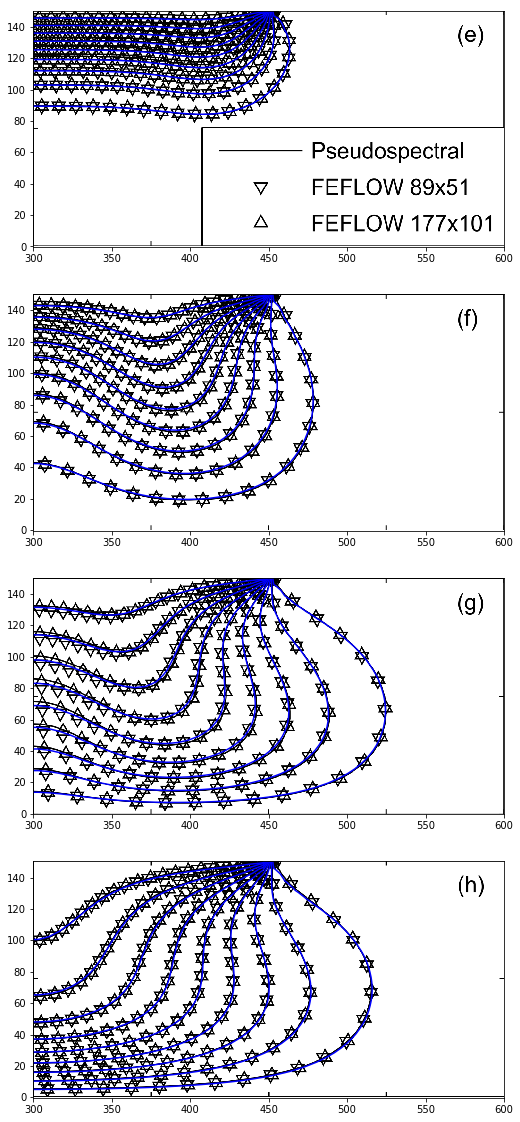

In [24]:
import matplotlib.image as mpimg

imglist = []
fname = os.path.join('data', 'elder_low_ra_t0p03.png')
img = mpimg.imread(fname)
imglist.append(img)
fname = os.path.join('data', 'elder_low_ra_t0p1.png')
img = mpimg.imread(fname)
imglist.append(img)
fname = os.path.join('data', 'elder_low_ra_t0p3.png')
img = mpimg.imread(fname)
imglist.append(img)
fname = os.path.join('data', 'elder_low_ra_t1.png')
img = mpimg.imread(fname)
imglist.append(img)

fig = plt.figure(figsize=(10, 20))
contour_color = 'b'

ax = plt.subplot(4, 1, 1)
kper = 6 - 1
img = imglist[0]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

ax = plt.subplot(4, 1, 2)
kper = 20 - 1
img = imglist[1]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

ax = plt.subplot(4, 1, 3)
kper = 60 - 1
img = imglist[2]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

ax = plt.subplot(4, 1, 4)
kper = 200 - 1
img = imglist[3]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)

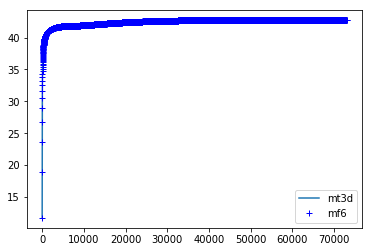

In [25]:
fname = os.path.join(model_ws, 'MT3D001.OBS')
assert os.path.isfile(fname)
mt3dobs =flopy.mt3d.mt.Mt3dms.load_obs(fname)

fname = os.path.join(ws0, 'gwt_elder.obs.csv')
mf6obs = np.genfromtxt(fname, delimiter=',', names=True)

obs1 = '({}, 1, {})'.format(2, ncol // 2 + 1)
plt.plot(mt3dobs['time'], mt3dobs[obs1], label='mt3d')
plt.plot(mf6obs['time'], mf6obs['CONC1'], 'b+', label='mf6')
#plt.xlim(0, 250)
plt.legend()

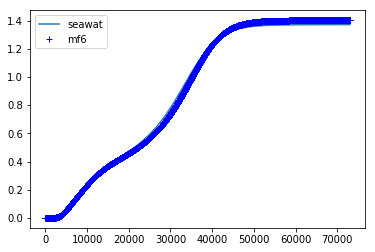

In [26]:
obs2 = '({}, 1, {})'.format(nlay - 1, ncol // 2 + 1)
plt.plot(mt3dobs['time'], mt3dobs[obs2], label='seawat')
plt.plot(mf6obs['time'], mf6obs['CONC2'], 'b+', label='mf6')
#plt.xlim(0, 40000)
plt.legend()

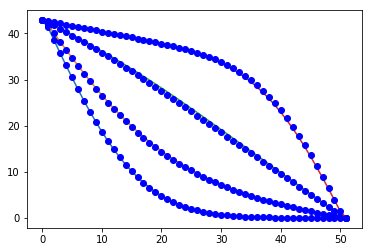

In [27]:
# concentration as a function of layer for the 4 different times
for kper in [5, 19, 59, 199]:
    plt.plot(conc_seawat[kper][:, 0, ncol//2])
    plt.plot(conc_mf6[kper][:, 0, ncol//2], 'bo')

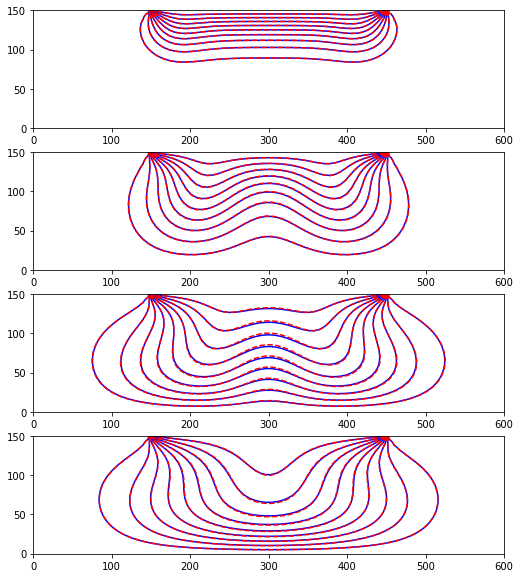

In [28]:
fig = plt.figure(figsize=(10, 10))
contour_color = 'b'
contour_color_mf6 = 'r'
x0 = 0.
aspect = 1.

ax = plt.subplot(4, 1, 1)
kper = 6 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(aspect)

ax = plt.subplot(4, 1, 2)
kper = 20 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(aspect)

ax = plt.subplot(4, 1, 3)
kper = 60 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(aspect)

ax = plt.subplot(4, 1, 4)
kper = 200 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(aspect)

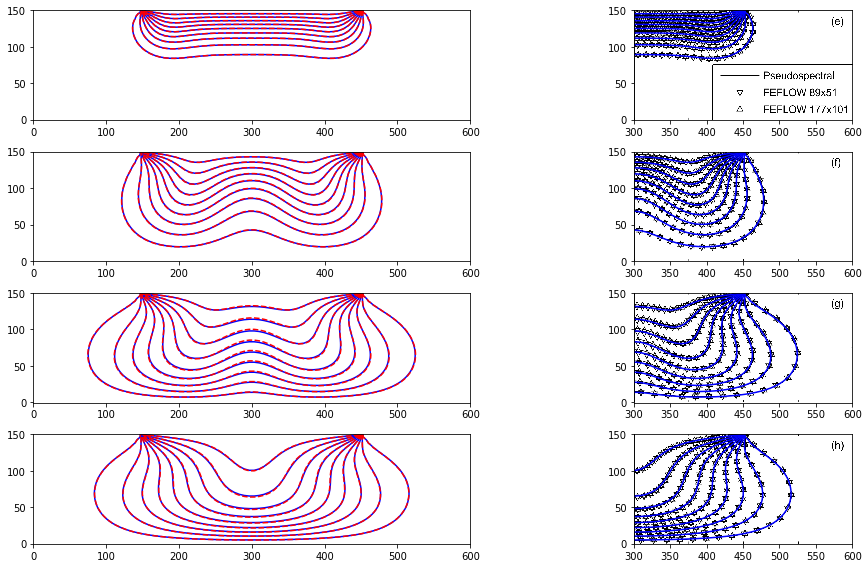

In [29]:
fig = plt.figure(figsize=(15, 8))
contour_color = 'b'
contour_color_mf6 = 'r'
x0 = 0.

ax = plt.subplot(4, 2, 1)
kper = 6 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])

ax.set_xlim(x0, 600)
ax.set_aspect(1.)


ax = plt.subplot(4, 2, 2)
kper = 6 - 1
img = imglist[0]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)
ax.set_aspect(1.)


ax = plt.subplot(4, 2, 3)
kper = 20 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(1.)

ax = plt.subplot(4, 2, 4)
kper = 20 - 1
img = imglist[1]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)
ax.set_aspect(1.)

ax = plt.subplot(4, 2, 5)
kper = 60 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(1.)

ax = plt.subplot(4, 2, 6)
kper = 60 - 1
img = imglist[2]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)
ax.set_aspect(1.)


ax = plt.subplot(4, 2, 7)
kper = 200 - 1
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
cmf6 = conc_mf6[kper]
pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['--'], colors=[contour_color_mf6])
ax.set_xlim(x0, 600)
ax.set_aspect(1.)

ax = plt.subplot(4, 2, 8)
kper = 200 - 1
img = imglist[3]
ax.imshow(img, extent=(300, 600, 0, 150))
conc = conc_seawat[kper]
pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color])
ax.set_xlim(300, 600)
ax.set_aspect(1.)
fig.tight_layout()

inwidth 6.751968503937007


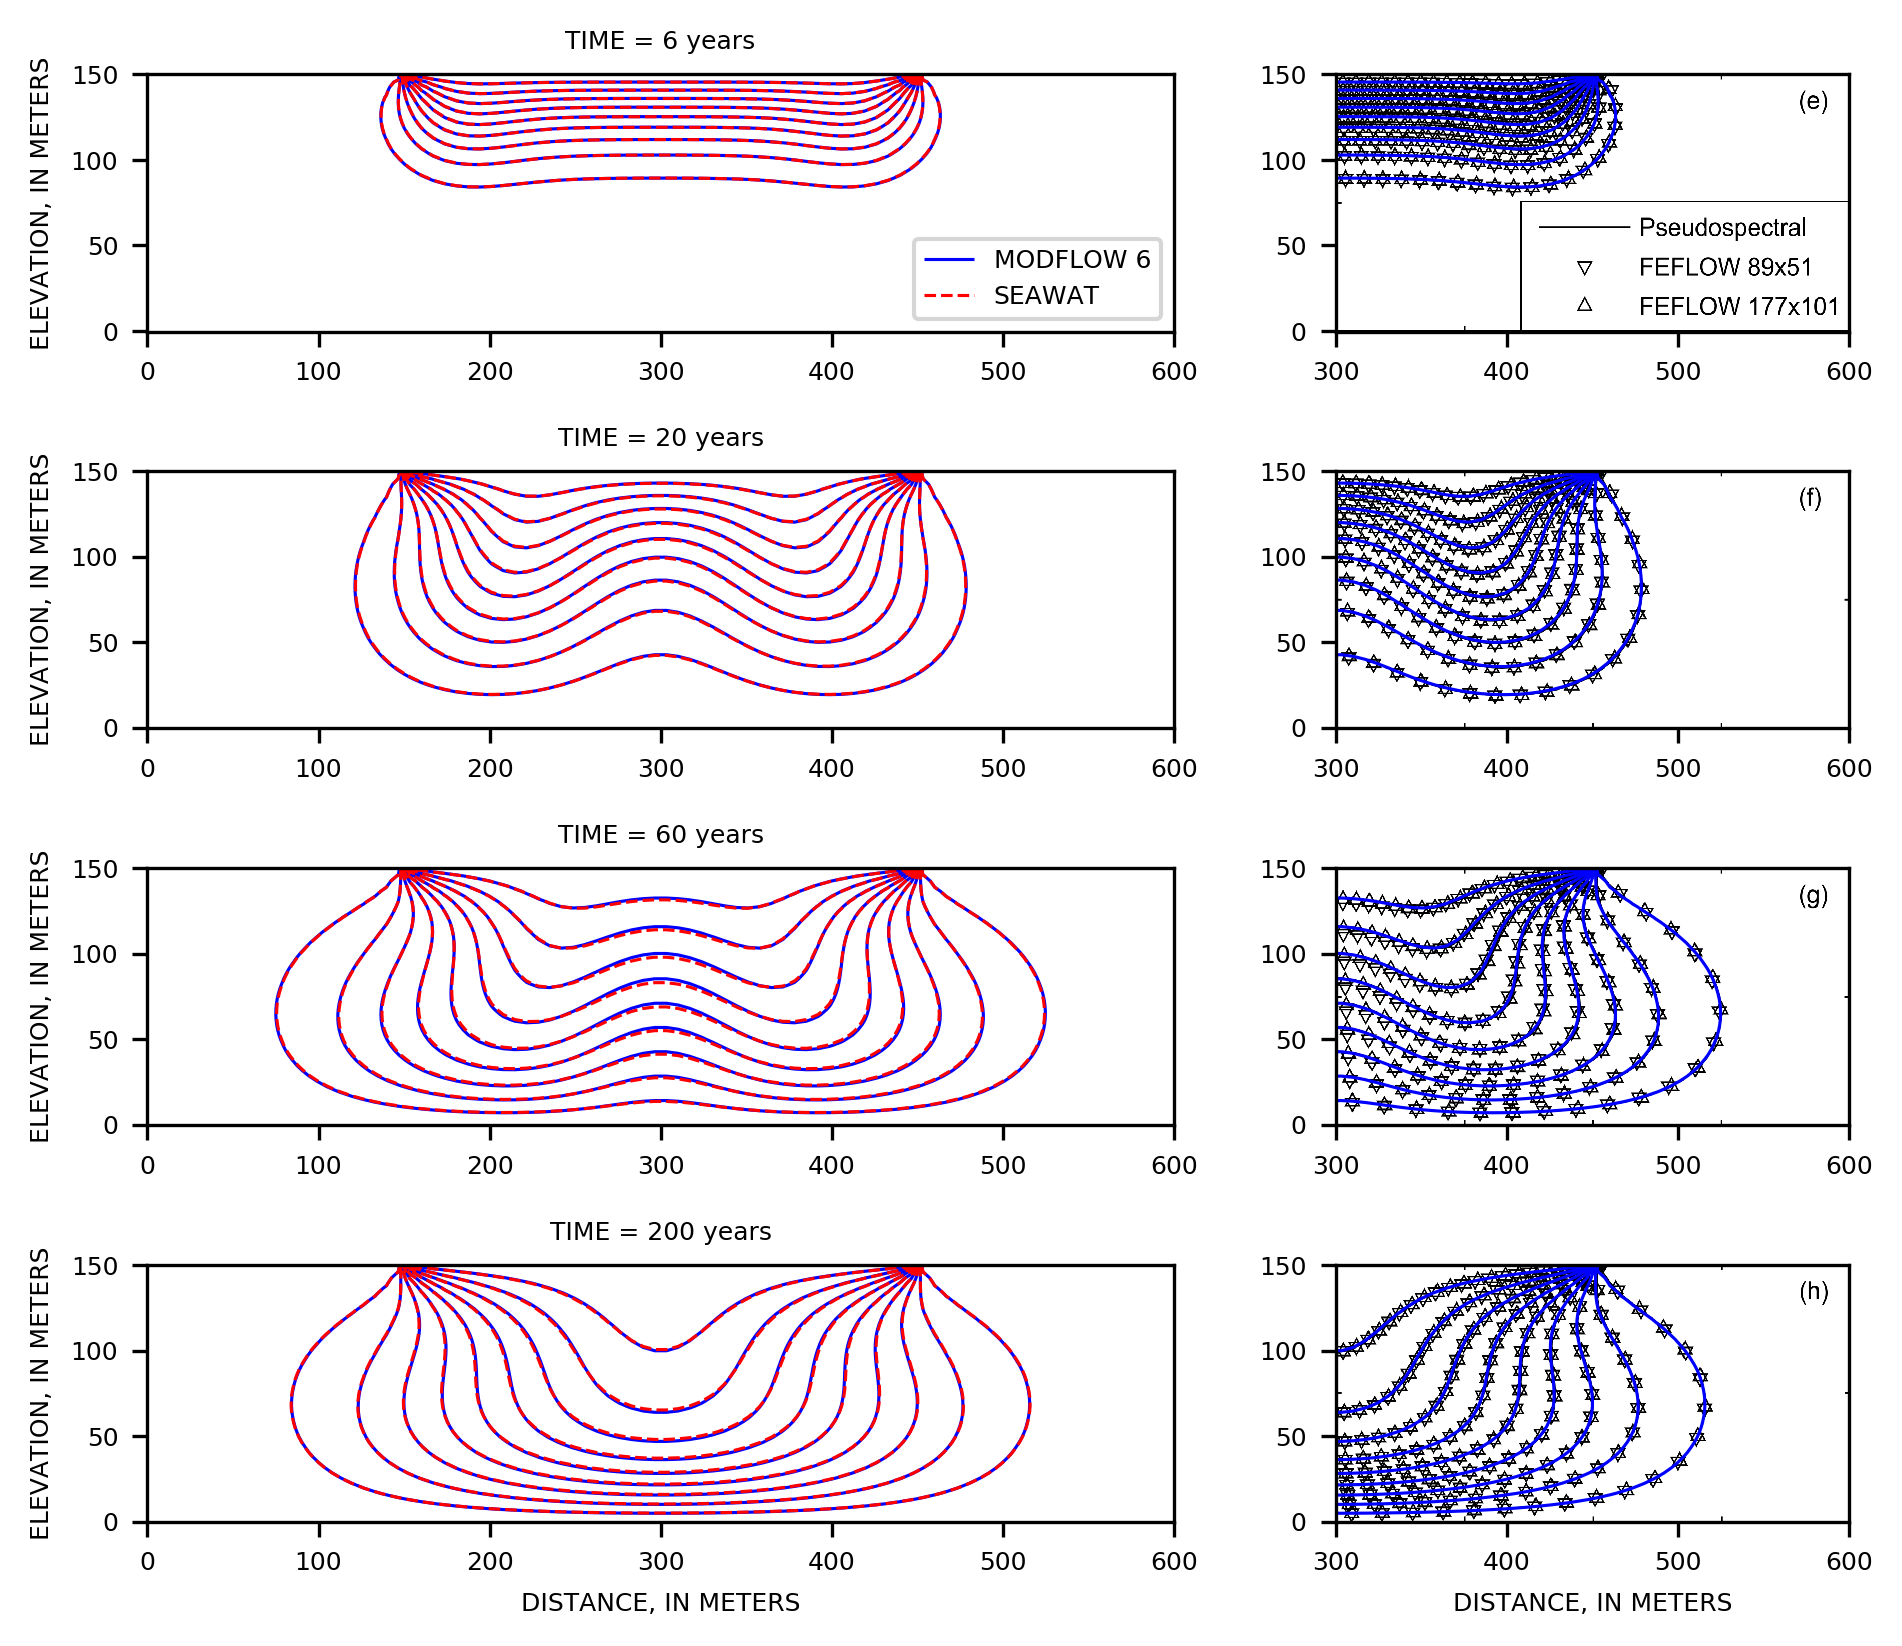

In [30]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
    ax.set_yticks([0, 50, 100, 150])

cmwidth = 17.15 # Groundwater full width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, inwidth - 1), dpi=300)
contour_color_mf6 = 'blue'
contour_color_seawat = 'red'


dp = .08
pheight = (1.0 - 5 * dp) / 4.
pwidth1 = (1.0 - 3 * dp) / 1.5
pwidth2 = 0.5 * pwidth1

axes = []
for ifig in range(4):
    x = dp
    y = 1 - (ifig + 1) * (pheight + dp)
    ax = fig.add_axes([x, y, pwidth1, pheight])
    axes.append(ax)
    
for ifig in range(4):
    x = 2 * dp + pwidth1
    y = 1 - (ifig + 1) * (pheight + dp)
    ax = fig.add_axes([x, y, pwidth2, pheight])
    axes.append(ax)
    
for ax in axes:
    ax_formatter(ax)

# left plots
for iax, kper in enumerate([6, 20, 60, 200]):
    ax = axes[iax]
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    cmf6 = conc_mf6[kper - 1]
    cntr_mf6 = pxs.contour_array(cmf6, levels=np.arange(.1, 1.0, .1) * csalt, 
                                 linestyles = ['-'], colors=[contour_color_mf6], 
                                 linewidths=0.75)
    conc = conc_seawat[kper - 1]
    cntr_seawat = pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                                    linestyles = ['--'], colors=[contour_color_seawat],
                                    linewidths=0.75)


    ax.set_xlim(0, 600)
    ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
    ax.set_title('TIME = {} years'.format(kper), fontsize=6)
    
    if iax == 0:
        h1,_ = cntr_mf6.legend_elements()
        h2,_ = cntr_seawat.legend_elements()
        ax.legend([h1[0], h2[0]], ['MODFLOW 6', 'SEAWAT'], loc=4, fontsize=6)
    
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)


# right plots
for iax, kper in enumerate([6, 20, 60, 200]):
    ax = axes[iax + 4]
    img = imglist[iax]
    ax.imshow(img, extent=(300, 600, 0, 150))
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    conc = conc_mf6[kper - 1]
    pxs.contour_array(conc, levels=np.arange(.1, 1.0, .1) * csalt, 
                      linestyles = ['-'], colors=[contour_color_mf6],
                      linewidths=0.75)
    ax.set_xlim(300, 600)
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
plt.savefig('../Figures/pxx_elder_ra60.pdf')

import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [31]:
3.565e-6 * 60 * 60 *24

0.30801600000000007